In [5]:
#######################
##### Python Modules #####
#######################
import argparse
import contextlib
import gc
import inspect
import logging
import math
import os
import random
import shutil
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
import json

##########################
##### External Libraries #####
##########################
import accelerate
import numpy as np
import PIL.Image
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from packaging import version
import wandb
from torchvision import transforms
from tqdm.auto import tqdm
import transformers
from transformers import (
    AutoTokenizer,
    CLIPImageProcessor,
    CLIPTextModel,
    CLIPTokenizer,
    CLIPVisionModelWithProjection,
    PretrainedConfig,
)
import matplotlib.pyplot as plt

#####################
##### Diffusers #####
#####################
import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    UniPCMultistepScheduler,
)
import logging as std_logging
import diffusers.utils.logging
from diffusers.callbacks import MultiPipelineCallbacks, PipelineCallback
from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.image_processor import PipelineImageInput, VaeImageProcessor
from diffusers.loaders import PeftAdapterMixin, UNet2DConditionLoadersMixin
from diffusers.loaders.single_file_model import FromOriginalModelMixin
from diffusers.models import (
    AutoencoderKL,
    ImageProjection,
)
from diffusers.models.activations import get_activation
from diffusers.models.attention_processor import (
    ADDED_KV_ATTENTION_PROCESSORS,
    CROSS_ATTENTION_PROCESSORS,
    Attention,
    AttentionProcessor,
    AttnAddedKVProcessor,
    AttnProcessor,
    AttnAddedKVProcessor2_0,
    FusedAttnProcessor2_0,
)
from diffusers.models.embeddings import (
    GaussianFourierProjection,
    GLIGENTextBoundingboxProjection,
    ImageHintTimeEmbedding,
    ImageProjection,
    ImageTimeEmbedding,
    TextImageProjection,
    TextImageTimeEmbedding,
    TextTimeEmbedding,
    TimestepEmbedding,
    Timesteps,
)
from diffusers.models.modeling_utils import ModelMixin
from diffusers.models.normalization import AdaGroupNorm
from diffusers.models.resnet import (
    Downsample2D,
    FirDownsample2D,
    FirUpsample2D,
    KDownsample2D,
    KUpsample2D,
    ResnetBlock2D,
    ResnetBlockCondNorm2D,
    Upsample2D,
)
from diffusers.models.transformers.dual_transformer_2d import DualTransformer2DModel
from diffusers.models.transformers.transformer_2d import Transformer2DModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.controlnet.multicontrolnet import MultiControlNetModel
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, StableDiffusionMixin
from diffusers.pipelines.stable_diffusion.pipeline_output import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from diffusers.schedulers import KarrasDiffusionSchedulers
from diffusers.utils import (
    BaseOutput,
    USE_PEFT_BACKEND,
    deprecate,
    is_torch_version,
    logging,
    replace_example_docstring,
    scale_lora_layers,
    unscale_lora_layers,
    check_min_version,
    load_image,
)
from diffusers.utils.torch_utils import apply_freeu
from diffusers.utils.torch_utils import randn_tensor
from diffusers.utils.torch_utils import is_compiled_module
from diffusers.utils import check_min_version, is_wandb_available

#######################
##### Device Setup #####
#######################
device = "cuda:0"


# Utils

In [10]:
def make_train_dataset(args, tokenizer, accelerator):
    """
    Get the datasets: you can either provide your own training and evaluation files (see below)
    or specify a Dataset from the hub (the dataset will be downloaded automatically from the datasets Hub).

    In distributed training, the load_dataset function guarantees that only one local process can concurrently
    download the dataset.
    """
    if args.dataset_name is not None:
        # Downloading and loading a dataset from the hub.
        dataset = load_dataset(
            args.dataset_name,
            args.dataset_config_name,
            cache_dir=args.cache_dir,
        )
    else:
        if args.train_data_dir is not None:
            dataset = load_dataset(
                args.train_data_dir,
                cache_dir=args.cache_dir,
            )
        # See more about loading custom images at
        # https://huggingface.co/docs/datasets/v2.0.0/en/dataset_script

    # Preprocessing the datasets.
    # We need to tokenize inputs and targets.
    column_names = dataset["train"].column_names

    # 6. Get the column names for input/target.
    if args.image_column is None:
        image_column = column_names[0]
        print(f"image column defaulting to {image_column}")
    else:
        image_column = args.image_column
        if image_column not in column_names:
            raise ValueError(
                f"`--image_column` value '{args.image_column}' not found in dataset columns. Dataset columns are: {', '.join(column_names)}"
            )

    if args.caption_column is None:
        caption_column = column_names[1]
        print(f"caption column defaulting to {caption_column}")
    else:
        caption_column = args.caption_column
        if caption_column not in column_names:
            raise ValueError(
                f"`--caption_column` value '{args.caption_column}' not found in dataset columns. Dataset columns are: {', '.join(column_names)}"
            )

    if args.conditioning_image_column is None:
        conditioning_image_column = column_names[2]
        print(f"conditioning image column defaulting to {conditioning_image_column}")
    else:
        conditioning_image_column = args.conditioning_image_column
        if conditioning_image_column not in column_names:
            raise ValueError(
                f"`--conditioning_image_column` value '{args.conditioning_image_column}' not found in dataset columns. Dataset columns are: {', '.join(column_names)}"
            )

    def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if random.random() < args.proportion_empty_prompts:
                captions.append("")
            elif isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return inputs.input_ids

    image_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    conditioning_image_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution),
            transforms.ToTensor(),
        ]
    )

    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        images = [image_transforms(image) for image in images]

        conditioning_images = [image.convert("RGB") for image in examples[conditioning_image_column]]
        conditioning_images = [conditioning_image_transforms(image) for image in conditioning_images]

        examples["pixel_values"] = images
        examples["conditioning_pixel_values"] = conditioning_images
        examples["input_ids"] = tokenize_captions(examples)

        return examples

    with accelerator.main_process_first():
        if args.max_train_samples is not None:
            dataset["train"] = dataset["train"].shuffle(seed=args.seed).select(range(args.max_train_samples))
        
        # Set the training transforms
        train_dataset = dataset["train"].with_transform(preprocess_train)

    return train_dataset


def image_grid(imgs, rows, cols):
    """
    Concatenates multiple images
    """
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

# UNet 2d Blocks

In [11]:
logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


def get_down_block(
    down_block_type: str,
    num_layers: int,
    in_channels: int,
    out_channels: int,
    temb_channels: int,
    add_downsample: bool,
    resnet_eps: float,
    resnet_act_fn: str,
    transformer_layers_per_block: int = 1,
    num_attention_heads: Optional[int] = None,
    resnet_groups: Optional[int] = None,
    cross_attention_dim: Optional[int] = None,
    downsample_padding: Optional[int] = None,
    dual_cross_attention: bool = False,
    use_linear_projection: bool = False,
    only_cross_attention: bool = False,
    upcast_attention: bool = False,
    resnet_time_scale_shift: str = "default",
    attention_type: str = "default",
    resnet_skip_time_act: bool = False,
    resnet_out_scale_factor: float = 1.0,
    cross_attention_norm: Optional[str] = None,
    attention_head_dim: Optional[int] = None,
    downsample_type: Optional[str] = None,
    dropout: float = 0.0,
):
    # If attn head dim is not defined, we default it to the number of heads
    if attention_head_dim is None:
        logger.warning(
            f"It is recommended to provide `attention_head_dim` when calling `get_down_block`. Defaulting `attention_head_dim` to {num_attention_heads}."
        )
        attention_head_dim = num_attention_heads

    down_block_type = down_block_type[7:] if down_block_type.startswith("UNetRes") else down_block_type
    if down_block_type == "DownBlock2D":
        return DownBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            add_downsample=add_downsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            downsample_padding=downsample_padding,
            resnet_time_scale_shift=resnet_time_scale_shift,
        )
    elif down_block_type == "ResnetDownsampleBlock2D":
        return ResnetDownsampleBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            add_downsample=add_downsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            resnet_time_scale_shift=resnet_time_scale_shift,
            skip_time_act=resnet_skip_time_act,
            output_scale_factor=resnet_out_scale_factor,
        )
    elif down_block_type == "AttnDownBlock2D":
        if add_downsample is False:
            downsample_type = None
        else:
            downsample_type = downsample_type or "conv"  # default to 'conv'
        return AttnDownBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            downsample_padding=downsample_padding,
            attention_head_dim=attention_head_dim,
            resnet_time_scale_shift=resnet_time_scale_shift,
            downsample_type=downsample_type,
        )
    elif down_block_type == "CrossAttnDownBlock2D":
        if cross_attention_dim is None:
            raise ValueError("cross_attention_dim must be specified for CrossAttnDownBlock2D")
        return CrossAttnDownBlock2D(
            num_layers=num_layers,
            transformer_layers_per_block=transformer_layers_per_block,
            in_channels=in_channels,
            out_channels=out_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            add_downsample=add_downsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            downsample_padding=downsample_padding,
            cross_attention_dim=cross_attention_dim,
            num_attention_heads=num_attention_heads,
            dual_cross_attention=dual_cross_attention,
            use_linear_projection=use_linear_projection,
            only_cross_attention=only_cross_attention,
            upcast_attention=upcast_attention,
            resnet_time_scale_shift=resnet_time_scale_shift,
            attention_type=attention_type,
        )
    elif down_block_type == "SimpleCrossAttnDownBlock2D":
        if cross_attention_dim is None:
            raise ValueError("cross_attention_dim must be specified for SimpleCrossAttnDownBlock2D")
        return SimpleCrossAttnDownBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            add_downsample=add_downsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            cross_attention_dim=cross_attention_dim,
            attention_head_dim=attention_head_dim,
            resnet_time_scale_shift=resnet_time_scale_shift,
            skip_time_act=resnet_skip_time_act,
            output_scale_factor=resnet_out_scale_factor,
            only_cross_attention=only_cross_attention,
            cross_attention_norm=cross_attention_norm,
        )
    elif down_block_type == "SkipDownBlock2D":
        return SkipDownBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            add_downsample=add_downsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            downsample_padding=downsample_padding,
            resnet_time_scale_shift=resnet_time_scale_shift,
        )
    elif down_block_type == "AttnSkipDownBlock2D":
        return AttnSkipDownBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            add_downsample=add_downsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            attention_head_dim=attention_head_dim,
            resnet_time_scale_shift=resnet_time_scale_shift,
        )
    elif down_block_type == "DownEncoderBlock2D":
        return DownEncoderBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            dropout=dropout,
            add_downsample=add_downsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            downsample_padding=downsample_padding,
            resnet_time_scale_shift=resnet_time_scale_shift,
        )
    elif down_block_type == "AttnDownEncoderBlock2D":
        return AttnDownEncoderBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            dropout=dropout,
            add_downsample=add_downsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            downsample_padding=downsample_padding,
            attention_head_dim=attention_head_dim,
            resnet_time_scale_shift=resnet_time_scale_shift,
        )
    elif down_block_type == "KDownBlock2D":
        return KDownBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            add_downsample=add_downsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
        )
    elif down_block_type == "KCrossAttnDownBlock2D":
        return KCrossAttnDownBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            add_downsample=add_downsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            cross_attention_dim=cross_attention_dim,
            attention_head_dim=attention_head_dim,
            add_self_attention=True if not add_downsample else False,
        )
    raise ValueError(f"{down_block_type} does not exist.")


def get_mid_block(
    mid_block_type: str,
    temb_channels: int,
    in_channels: int,
    resnet_eps: float,
    resnet_act_fn: str,
    resnet_groups: int,
    output_scale_factor: float = 1.0,
    transformer_layers_per_block: int = 1,
    num_attention_heads: Optional[int] = None,
    cross_attention_dim: Optional[int] = None,
    dual_cross_attention: bool = False,
    use_linear_projection: bool = False,
    mid_block_only_cross_attention: bool = False,
    upcast_attention: bool = False,
    resnet_time_scale_shift: str = "default",
    attention_type: str = "default",
    resnet_skip_time_act: bool = False,
    cross_attention_norm: Optional[str] = None,
    attention_head_dim: Optional[int] = 1,
    dropout: float = 0.0,
):
    if mid_block_type == "UNetMidBlock2DCrossAttn":
        return UNetMidBlock2DCrossAttn(
            transformer_layers_per_block=transformer_layers_per_block,
            in_channels=in_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            output_scale_factor=output_scale_factor,
            resnet_time_scale_shift=resnet_time_scale_shift,
            cross_attention_dim=cross_attention_dim,
            num_attention_heads=num_attention_heads,
            resnet_groups=resnet_groups,
            dual_cross_attention=dual_cross_attention,
            use_linear_projection=use_linear_projection,
            upcast_attention=upcast_attention,
            attention_type=attention_type,
        )
    elif mid_block_type == "UNetMidBlock2DSimpleCrossAttn":
        return UNetMidBlock2DSimpleCrossAttn(
            in_channels=in_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            output_scale_factor=output_scale_factor,
            cross_attention_dim=cross_attention_dim,
            attention_head_dim=attention_head_dim,
            resnet_groups=resnet_groups,
            resnet_time_scale_shift=resnet_time_scale_shift,
            skip_time_act=resnet_skip_time_act,
            only_cross_attention=mid_block_only_cross_attention,
            cross_attention_norm=cross_attention_norm,
        )
    elif mid_block_type == "UNetMidBlock2D":
        return UNetMidBlock2D(
            in_channels=in_channels,
            temb_channels=temb_channels,
            dropout=dropout,
            num_layers=0,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            output_scale_factor=output_scale_factor,
            resnet_groups=resnet_groups,
            resnet_time_scale_shift=resnet_time_scale_shift,
            add_attention=False,
        )
    elif mid_block_type is None:
        return None
    else:
        raise ValueError(f"unknown mid_block_type : {mid_block_type}")


def get_up_block(
    up_block_type: str,
    num_layers: int,
    in_channels: int,
    out_channels: int,
    prev_output_channel: int,
    temb_channels: int,
    add_upsample: bool,
    resnet_eps: float,
    resnet_act_fn: str,
    resolution_idx: Optional[int] = None,
    transformer_layers_per_block: int = 1,
    num_attention_heads: Optional[int] = None,
    resnet_groups: Optional[int] = None,
    cross_attention_dim: Optional[int] = None,
    dual_cross_attention: bool = False,
    use_linear_projection: bool = False,
    only_cross_attention: bool = False,
    upcast_attention: bool = False,
    resnet_time_scale_shift: str = "default",
    attention_type: str = "default",
    resnet_skip_time_act: bool = False,
    resnet_out_scale_factor: float = 1.0,
    cross_attention_norm: Optional[str] = None,
    attention_head_dim: Optional[int] = None,
    upsample_type: Optional[str] = None,
    dropout: float = 0.0,
) -> nn.Module:
    # If attn head dim is not defined, we default it to the number of heads
    if attention_head_dim is None:
        logger.warning(
            f"It is recommended to provide `attention_head_dim` when calling `get_up_block`. Defaulting `attention_head_dim` to {num_attention_heads}."
        )
        attention_head_dim = num_attention_heads

    up_block_type = up_block_type[7:] if up_block_type.startswith("UNetRes") else up_block_type
    if up_block_type == "UpBlock2D":
        return UpBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            prev_output_channel=prev_output_channel,
            temb_channels=temb_channels,
            resolution_idx=resolution_idx,
            dropout=dropout,
            add_upsample=add_upsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            resnet_time_scale_shift=resnet_time_scale_shift,
        )
    elif up_block_type == "ResnetUpsampleBlock2D":
        return ResnetUpsampleBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            prev_output_channel=prev_output_channel,
            temb_channels=temb_channels,
            resolution_idx=resolution_idx,
            dropout=dropout,
            add_upsample=add_upsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            resnet_time_scale_shift=resnet_time_scale_shift,
            skip_time_act=resnet_skip_time_act,
            output_scale_factor=resnet_out_scale_factor,
        )
    elif up_block_type == "CrossAttnUpBlock2D":
        if cross_attention_dim is None:
            raise ValueError("cross_attention_dim must be specified for CrossAttnUpBlock2D")
        return CrossAttnUpBlock2D(
            num_layers=num_layers,
            transformer_layers_per_block=transformer_layers_per_block,
            in_channels=in_channels,
            out_channels=out_channels,
            prev_output_channel=prev_output_channel,
            temb_channels=temb_channels,
            resolution_idx=resolution_idx,
            dropout=dropout,
            add_upsample=add_upsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            cross_attention_dim=cross_attention_dim,
            num_attention_heads=num_attention_heads,
            dual_cross_attention=dual_cross_attention,
            use_linear_projection=use_linear_projection,
            only_cross_attention=only_cross_attention,
            upcast_attention=upcast_attention,
            resnet_time_scale_shift=resnet_time_scale_shift,
            attention_type=attention_type,
        )
    elif up_block_type == "SimpleCrossAttnUpBlock2D":
        if cross_attention_dim is None:
            raise ValueError("cross_attention_dim must be specified for SimpleCrossAttnUpBlock2D")
        return SimpleCrossAttnUpBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            prev_output_channel=prev_output_channel,
            temb_channels=temb_channels,
            resolution_idx=resolution_idx,
            dropout=dropout,
            add_upsample=add_upsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            cross_attention_dim=cross_attention_dim,
            attention_head_dim=attention_head_dim,
            resnet_time_scale_shift=resnet_time_scale_shift,
            skip_time_act=resnet_skip_time_act,
            output_scale_factor=resnet_out_scale_factor,
            only_cross_attention=only_cross_attention,
            cross_attention_norm=cross_attention_norm,
        )
    elif up_block_type == "AttnUpBlock2D":
        if add_upsample is False:
            upsample_type = None
        else:
            upsample_type = upsample_type or "conv"  # default to 'conv'

        return AttnUpBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            prev_output_channel=prev_output_channel,
            temb_channels=temb_channels,
            resolution_idx=resolution_idx,
            dropout=dropout,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            attention_head_dim=attention_head_dim,
            resnet_time_scale_shift=resnet_time_scale_shift,
            upsample_type=upsample_type,
        )
    elif up_block_type == "SkipUpBlock2D":
        return SkipUpBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            prev_output_channel=prev_output_channel,
            temb_channels=temb_channels,
            resolution_idx=resolution_idx,
            dropout=dropout,
            add_upsample=add_upsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_time_scale_shift=resnet_time_scale_shift,
        )
    elif up_block_type == "AttnSkipUpBlock2D":
        return AttnSkipUpBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            prev_output_channel=prev_output_channel,
            temb_channels=temb_channels,
            resolution_idx=resolution_idx,
            dropout=dropout,
            add_upsample=add_upsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            attention_head_dim=attention_head_dim,
            resnet_time_scale_shift=resnet_time_scale_shift,
        )
    elif up_block_type == "UpDecoderBlock2D":
        return UpDecoderBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            resolution_idx=resolution_idx,
            dropout=dropout,
            add_upsample=add_upsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            resnet_time_scale_shift=resnet_time_scale_shift,
            temb_channels=temb_channels,
        )
    elif up_block_type == "AttnUpDecoderBlock2D":
        return AttnUpDecoderBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            resolution_idx=resolution_idx,
            dropout=dropout,
            add_upsample=add_upsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            resnet_groups=resnet_groups,
            attention_head_dim=attention_head_dim,
            resnet_time_scale_shift=resnet_time_scale_shift,
            temb_channels=temb_channels,
        )
    elif up_block_type == "KUpBlock2D":
        return KUpBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            temb_channels=temb_channels,
            resolution_idx=resolution_idx,
            dropout=dropout,
            add_upsample=add_upsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
        )
    elif up_block_type == "KCrossAttnUpBlock2D":
        return KCrossAttnUpBlock2D(
            num_layers=num_layers,
            in_channels=in_channels,
            out_channels=out_channels,
            temb_channels=temb_channels,
            resolution_idx=resolution_idx,
            dropout=dropout,
            add_upsample=add_upsample,
            resnet_eps=resnet_eps,
            resnet_act_fn=resnet_act_fn,
            cross_attention_dim=cross_attention_dim,
            attention_head_dim=attention_head_dim,
        )

    raise ValueError(f"{up_block_type} does not exist.")


class AutoencoderTinyBlock(nn.Module):
    """
    Tiny Autoencoder block used in [`AutoencoderTiny`]. It is a mini residual module consisting of plain conv + ReLU
    blocks.

    Args:
        in_channels (`int`): The number of input channels.
        out_channels (`int`): The number of output channels.
        act_fn (`str`):
            ` The activation function to use. Supported values are `"swish"`, `"mish"`, `"gelu"`, and `"relu"`.

    Returns:
        `torch.Tensor`: A tensor with the same shape as the input tensor, but with the number of channels equal to
        `out_channels`.
    """

    def __init__(self, in_channels: int, out_channels: int, act_fn: str):
        super().__init__()
        act_fn = get_activation(act_fn)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            act_fn,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            act_fn,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.skip = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
            if in_channels != out_channels
            else nn.Identity()
        )
        self.fuse = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fuse(self.conv(x) + self.skip(x))


class UNetMidBlock2D(nn.Module):
    """
    A 2D UNet mid-block [`UNetMidBlock2D`] with multiple residual blocks and optional attention blocks.

    Args:
        in_channels (`int`): The number of input channels.
        temb_channels (`int`): The number of temporal embedding channels.
        dropout (`float`, *optional*, defaults to 0.0): The dropout rate.
        num_layers (`int`, *optional*, defaults to 1): The number of residual blocks.
        resnet_eps (`float`, *optional*, 1e-6 ): The epsilon value for the resnet blocks.
        resnet_time_scale_shift (`str`, *optional*, defaults to `default`):
            The type of normalization to apply to the time embeddings. This can help to improve the performance of the
            model on tasks with long-range temporal dependencies.
        resnet_act_fn (`str`, *optional*, defaults to `swish`): The activation function for the resnet blocks.
        resnet_groups (`int`, *optional*, defaults to 32):
            The number of groups to use in the group normalization layers of the resnet blocks.
        attn_groups (`Optional[int]`, *optional*, defaults to None): The number of groups for the attention blocks.
        resnet_pre_norm (`bool`, *optional*, defaults to `True`):
            Whether to use pre-normalization for the resnet blocks.
        add_attention (`bool`, *optional*, defaults to `True`): Whether to add attention blocks.
        attention_head_dim (`int`, *optional*, defaults to 1):
            Dimension of a single attention head. The number of attention heads is determined based on this value and
            the number of input channels.
        output_scale_factor (`float`, *optional*, defaults to 1.0): The output scale factor.

    Returns:
        `torch.Tensor`: The output of the last residual block, which is a tensor of shape `(batch_size, in_channels,
        height, width)`.

    """

    def __init__(
        self,
        in_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",  # default, spatial
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        attn_groups: Optional[int] = None,
        resnet_pre_norm: bool = True,
        add_attention: bool = True,
        attention_head_dim: int = 1,
        output_scale_factor: float = 1.0,
    ):
        super().__init__()
        resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)
        self.add_attention = add_attention

        if attn_groups is None:
            attn_groups = resnet_groups if resnet_time_scale_shift == "default" else None

        # there is always at least one resnet
        if resnet_time_scale_shift == "spatial":
            resnets = [
                ResnetBlockCondNorm2D(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm="spatial",
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                )
            ]
        else:
            resnets = [
                ResnetBlock2D(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            ]
        attentions = []

        if attention_head_dim is None:
            logger.warning(
                f"It is not recommend to pass `attention_head_dim=None`. Defaulting `attention_head_dim` to `in_channels`: {in_channels}."
            )
            attention_head_dim = in_channels

        for _ in range(num_layers):
            if self.add_attention:
                attentions.append(
                    Attention(
                        in_channels,
                        heads=in_channels // attention_head_dim,
                        dim_head=attention_head_dim,
                        rescale_output_factor=output_scale_factor,
                        eps=resnet_eps,
                        norm_num_groups=attn_groups,
                        spatial_norm_dim=temb_channels if resnet_time_scale_shift == "spatial" else None,
                        residual_connection=True,
                        bias=True,
                        upcast_softmax=True,
                        _from_deprecated_attn_block=True,
                    )
                )
            else:
                attentions.append(None)

            if resnet_time_scale_shift == "spatial":
                resnets.append(
                    ResnetBlockCondNorm2D(
                        in_channels=in_channels,
                        out_channels=in_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm="spatial",
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                    )
                )
            else:
                resnets.append(
                    ResnetBlock2D(
                        in_channels=in_channels,
                        out_channels=in_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm=resnet_time_scale_shift,
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                        pre_norm=resnet_pre_norm,
                    )
                )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

    def forward(self, hidden_states: torch.Tensor, temb: Optional[torch.Tensor] = None) -> torch.Tensor:
        hidden_states = self.resnets[0](hidden_states, temb)
        for attn, resnet in zip(self.attentions, self.resnets[1:]):
            if attn is not None:
                hidden_states = attn(hidden_states, temb=temb)
            hidden_states = resnet(hidden_states, temb)

        return hidden_states


class UNetMidBlock2DCrossAttn(nn.Module):
    def __init__(
        self,
        in_channels: int,
        temb_channels: int,
        out_channels: Optional[int] = None,
        dropout: float = 0.0,
        num_layers: int = 1,
        transformer_layers_per_block: Union[int, Tuple[int]] = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_groups_out: Optional[int] = None,
        resnet_pre_norm: bool = True,
        num_attention_heads: int = 1,
        output_scale_factor: float = 1.0,
        cross_attention_dim: int = 1280,
        dual_cross_attention: bool = False,
        use_linear_projection: bool = False,
        upcast_attention: bool = False,
        attention_type: str = "default",
    ):
        super().__init__()

        out_channels = out_channels or in_channels
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.has_cross_attention = True
        self.num_attention_heads = num_attention_heads
        resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)

        # support for variable transformer layers per block
        if isinstance(transformer_layers_per_block, int):
            transformer_layers_per_block = [transformer_layers_per_block] * num_layers

        resnet_groups_out = resnet_groups_out or resnet_groups

        # there is always at least one resnet
        resnets = [
            ResnetBlock2D(
                in_channels=in_channels,
                out_channels=out_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=resnet_groups,
                groups_out=resnet_groups_out,
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
            )
        ]
        attentions = []

        for i in range(num_layers):
            if not dual_cross_attention:
                attentions.append(
                    Transformer2DModel(
                        num_attention_heads,
                        out_channels // num_attention_heads,
                        in_channels=out_channels,
                        num_layers=transformer_layers_per_block[i],
                        cross_attention_dim=cross_attention_dim,
                        norm_num_groups=resnet_groups_out,
                        use_linear_projection=use_linear_projection,
                        upcast_attention=upcast_attention,
                        attention_type=attention_type,
                    )
                )
            else:
                attentions.append(
                    DualTransformer2DModel(
                        num_attention_heads,
                        out_channels // num_attention_heads,
                        in_channels=out_channels,
                        num_layers=1,
                        cross_attention_dim=cross_attention_dim,
                        norm_num_groups=resnet_groups,
                    )
                )
            resnets.append(
                ResnetBlock2D(
                    in_channels=out_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups_out,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        temb: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        if cross_attention_kwargs is not None:
            if cross_attention_kwargs.get("scale", None) is not None:
                logger.warning("Passing `scale` to `cross_attention_kwargs` is deprecated. `scale` will be ignored.")

        hidden_states = self.resnets[0](hidden_states, temb)
        for attn, resnet in zip(self.attentions, self.resnets[1:]):
            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module, return_dict=None):
                    def custom_forward(*inputs):
                        if return_dict is not None:
                            return module(*inputs, return_dict=return_dict)
                        else:
                            return module(*inputs)

                    return custom_forward

                ckpt_kwargs: Dict[str, Any] = {"use_reentrant": False} if is_torch_version(">=", "1.11.0") else {}
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    attention_mask=attention_mask,
                    encoder_attention_mask=encoder_attention_mask,
                    return_dict=False,
                )[0]
                hidden_states = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(resnet),
                    hidden_states,
                    temb,
                    **ckpt_kwargs,
                )
            else:
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    attention_mask=attention_mask,
                    encoder_attention_mask=encoder_attention_mask,
                    return_dict=False,
                )[0]
                hidden_states = resnet(hidden_states, temb)

        return hidden_states


class UNetMidBlock2DSimpleCrossAttn(nn.Module):
    def __init__(
        self,
        in_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attention_head_dim: int = 1,
        output_scale_factor: float = 1.0,
        cross_attention_dim: int = 1280,
        skip_time_act: bool = False,
        only_cross_attention: bool = False,
        cross_attention_norm: Optional[str] = None,
    ):
        super().__init__()

        self.has_cross_attention = True

        self.attention_head_dim = attention_head_dim
        resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)

        self.num_heads = in_channels // self.attention_head_dim

        # there is always at least one resnet
        resnets = [
            ResnetBlock2D(
                in_channels=in_channels,
                out_channels=in_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=resnet_groups,
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
                skip_time_act=skip_time_act,
            )
        ]
        attentions = []

        for _ in range(num_layers):
            processor = (
                AttnAddedKVProcessor2_0() if hasattr(F, "scaled_dot_product_attention") else AttnAddedKVProcessor()
            )

            attentions.append(
                Attention(
                    query_dim=in_channels,
                    cross_attention_dim=in_channels,
                    heads=self.num_heads,
                    dim_head=self.attention_head_dim,
                    added_kv_proj_dim=cross_attention_dim,
                    norm_num_groups=resnet_groups,
                    bias=True,
                    upcast_softmax=True,
                    only_cross_attention=only_cross_attention,
                    cross_attention_norm=cross_attention_norm,
                    processor=processor,
                )
            )
            resnets.append(
                ResnetBlock2D(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                    skip_time_act=skip_time_act,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

    def forward(
        self,
        hidden_states: torch.Tensor,
        temb: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        cross_attention_kwargs = cross_attention_kwargs if cross_attention_kwargs is not None else {}
        if cross_attention_kwargs.get("scale", None) is not None:
            logger.warning("Passing `scale` to `cross_attention_kwargs` is deprecated. `scale` will be ignored.")

        if attention_mask is None:
            # if encoder_hidden_states is defined: we are doing cross-attn, so we should use cross-attn mask.
            mask = None if encoder_hidden_states is None else encoder_attention_mask
        else:
            # when attention_mask is defined: we don't even check for encoder_attention_mask.
            # this is to maintain compatibility with UnCLIP, which uses 'attention_mask' param for cross-attn masks.
            #       then we can simplify this whole if/else block to:
            #         mask = attention_mask if encoder_hidden_states is None else encoder_attention_mask
            mask = attention_mask

        hidden_states = self.resnets[0](hidden_states, temb)
        for attn, resnet in zip(self.attentions, self.resnets[1:]):
            # attn
            hidden_states = attn(
                hidden_states,
                encoder_hidden_states=encoder_hidden_states,
                attention_mask=mask,
                **cross_attention_kwargs,
            )

            # resnet
            hidden_states = resnet(hidden_states, temb)

        return hidden_states


class AttnDownBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attention_head_dim: int = 1,
        output_scale_factor: float = 1.0,
        downsample_padding: int = 1,
        downsample_type: str = "conv",
    ):
        super().__init__()
        resnets = []
        attentions = []
        self.downsample_type = downsample_type

        if attention_head_dim is None:
            logger.warning(
                f"It is not recommend to pass `attention_head_dim=None`. Defaulting `attention_head_dim` to `in_channels`: {out_channels}."
            )
            attention_head_dim = out_channels

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnets.append(
                ResnetBlock2D(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )
            attentions.append(
                Attention(
                    out_channels,
                    heads=out_channels // attention_head_dim,
                    dim_head=attention_head_dim,
                    rescale_output_factor=output_scale_factor,
                    eps=resnet_eps,
                    norm_num_groups=resnet_groups,
                    residual_connection=True,
                    bias=True,
                    upcast_softmax=True,
                    _from_deprecated_attn_block=True,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

        if downsample_type == "conv":
            self.downsamplers = nn.ModuleList(
                [
                    Downsample2D(
                        out_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
                    )
                ]
            )
        elif downsample_type == "resnet":
            self.downsamplers = nn.ModuleList(
                [
                    ResnetBlock2D(
                        in_channels=out_channels,
                        out_channels=out_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm=resnet_time_scale_shift,
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                        pre_norm=resnet_pre_norm,
                        down=True,
                    )
                ]
            )
        else:
            self.downsamplers = None

    def forward(
        self,
        hidden_states: torch.Tensor,
        temb: Optional[torch.Tensor] = None,
        upsample_size: Optional[int] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, ...]]:
        cross_attention_kwargs = cross_attention_kwargs if cross_attention_kwargs is not None else {}
        if cross_attention_kwargs.get("scale", None) is not None:
            logger.warning("Passing `scale` to `cross_attention_kwargs` is deprecated. `scale` will be ignored.")

        output_states = ()

        for resnet, attn in zip(self.resnets, self.attentions):
            hidden_states = resnet(hidden_states, temb)
            hidden_states = attn(hidden_states, **cross_attention_kwargs)
            output_states = output_states + (hidden_states,)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                if self.downsample_type == "resnet":
                    hidden_states = downsampler(hidden_states, temb=temb)
                else:
                    hidden_states = downsampler(hidden_states)

            output_states += (hidden_states,)

        return hidden_states, output_states


class CrossAttnDownBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        transformer_layers_per_block: Union[int, Tuple[int]] = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        num_attention_heads: int = 1,
        cross_attention_dim: int = 1280,
        output_scale_factor: float = 1.0,
        downsample_padding: int = 1,
        add_downsample: bool = True,
        dual_cross_attention: bool = False,
        use_linear_projection: bool = False,
        only_cross_attention: bool = False,
        upcast_attention: bool = False,
        attention_type: str = "default",
    ):
        super().__init__()
        resnets = []
        attentions = []

        self.has_cross_attention = True
        self.num_attention_heads = num_attention_heads
        if isinstance(transformer_layers_per_block, int):
            transformer_layers_per_block = [transformer_layers_per_block] * num_layers

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnets.append(
                ResnetBlock2D(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )
            if not dual_cross_attention:
                attentions.append(
                    Transformer2DModel(
                        num_attention_heads,
                        out_channels // num_attention_heads,
                        in_channels=out_channels,
                        num_layers=transformer_layers_per_block[i],
                        cross_attention_dim=cross_attention_dim,
                        norm_num_groups=resnet_groups,
                        use_linear_projection=use_linear_projection,
                        only_cross_attention=only_cross_attention,
                        upcast_attention=upcast_attention,
                        attention_type=attention_type,
                    )
                )
            else:
                attentions.append(
                    DualTransformer2DModel(
                        num_attention_heads,
                        out_channels // num_attention_heads,
                        in_channels=out_channels,
                        num_layers=1,
                        cross_attention_dim=cross_attention_dim,
                        norm_num_groups=resnet_groups,
                    )
                )
        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    Downsample2D(
                        out_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
                    )
                ]
            )
        else:
            self.downsamplers = None

        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        temb: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        additional_residuals: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, ...]]:
        if cross_attention_kwargs is not None:
            if cross_attention_kwargs.get("scale", None) is not None:
                logger.warning("Passing `scale` to `cross_attention_kwargs` is deprecated. `scale` will be ignored.")

        output_states = ()

        blocks = list(zip(self.resnets, self.attentions))

        for i, (resnet, attn) in enumerate(blocks):
            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module, return_dict=None):
                    def custom_forward(*inputs):
                        if return_dict is not None:
                            return module(*inputs, return_dict=return_dict)
                        else:
                            return module(*inputs)

                    return custom_forward

                ckpt_kwargs: Dict[str, Any] = {"use_reentrant": False} if is_torch_version(">=", "1.11.0") else {}
                hidden_states = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(resnet),
                    hidden_states,
                    temb,
                    **ckpt_kwargs,
                )
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    attention_mask=attention_mask,
                    encoder_attention_mask=encoder_attention_mask,
                    return_dict=False,
                )[0]
            else:
                hidden_states = resnet(hidden_states, temb)
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    attention_mask=attention_mask,
                    encoder_attention_mask=encoder_attention_mask,
                    return_dict=False,
                )[0]

            # apply additional residuals to the output of the last pair of resnet and attention blocks
            if i == len(blocks) - 1 and additional_residuals is not None:
                hidden_states = hidden_states + additional_residuals

            output_states = output_states + (hidden_states,)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

            output_states = output_states + (hidden_states,)

        return hidden_states, output_states


class DownBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor: float = 1.0,
        add_downsample: bool = True,
        downsample_padding: int = 1,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnets.append(
                ResnetBlock2D(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    Downsample2D(
                        out_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
                    )
                ]
            )
        else:
            self.downsamplers = None

        self.gradient_checkpointing = False

    def forward(
        self, hidden_states: torch.Tensor, temb: Optional[torch.Tensor] = None, *args, **kwargs
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, ...]]:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        output_states = ()

        for resnet in self.resnets:
            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs)

                    return custom_forward

                if is_torch_version(">=", "1.11.0"):
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb, use_reentrant=False
                    )
                else:
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb
                    )
            else:
                hidden_states = resnet(hidden_states, temb)

            output_states = output_states + (hidden_states,)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

            output_states = output_states + (hidden_states,)

        return hidden_states, output_states


class DownEncoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor: float = 1.0,
        add_downsample: bool = True,
        downsample_padding: int = 1,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            if resnet_time_scale_shift == "spatial":
                resnets.append(
                    ResnetBlockCondNorm2D(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        temb_channels=None,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm="spatial",
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                    )
                )
            else:
                resnets.append(
                    ResnetBlock2D(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        temb_channels=None,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm=resnet_time_scale_shift,
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                        pre_norm=resnet_pre_norm,
                    )
                )

        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    Downsample2D(
                        out_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
                    )
                ]
            )
        else:
            self.downsamplers = None

    def forward(self, hidden_states: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

        return hidden_states


class AttnDownEncoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attention_head_dim: int = 1,
        output_scale_factor: float = 1.0,
        add_downsample: bool = True,
        downsample_padding: int = 1,
    ):
        super().__init__()
        resnets = []
        attentions = []

        if attention_head_dim is None:
            logger.warning(
                f"It is not recommend to pass `attention_head_dim=None`. Defaulting `attention_head_dim` to `in_channels`: {out_channels}."
            )
            attention_head_dim = out_channels

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            if resnet_time_scale_shift == "spatial":
                resnets.append(
                    ResnetBlockCondNorm2D(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        temb_channels=None,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm="spatial",
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                    )
                )
            else:
                resnets.append(
                    ResnetBlock2D(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        temb_channels=None,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm=resnet_time_scale_shift,
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                        pre_norm=resnet_pre_norm,
                    )
                )
            attentions.append(
                Attention(
                    out_channels,
                    heads=out_channels // attention_head_dim,
                    dim_head=attention_head_dim,
                    rescale_output_factor=output_scale_factor,
                    eps=resnet_eps,
                    norm_num_groups=resnet_groups,
                    residual_connection=True,
                    bias=True,
                    upcast_softmax=True,
                    _from_deprecated_attn_block=True,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    Downsample2D(
                        out_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
                    )
                ]
            )
        else:
            self.downsamplers = None

    def forward(self, hidden_states: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        for resnet, attn in zip(self.resnets, self.attentions):
            hidden_states = resnet(hidden_states, temb=None)
            hidden_states = attn(hidden_states)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

        return hidden_states


class AttnSkipDownBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_pre_norm: bool = True,
        attention_head_dim: int = 1,
        output_scale_factor: float = np.sqrt(2.0),
        add_downsample: bool = True,
    ):
        super().__init__()
        self.attentions = nn.ModuleList([])
        self.resnets = nn.ModuleList([])

        if attention_head_dim is None:
            logger.warning(
                f"It is not recommend to pass `attention_head_dim=None`. Defaulting `attention_head_dim` to `in_channels`: {out_channels}."
            )
            attention_head_dim = out_channels

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            self.resnets.append(
                ResnetBlock2D(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=min(in_channels // 4, 32),
                    groups_out=min(out_channels // 4, 32),
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )
            self.attentions.append(
                Attention(
                    out_channels,
                    heads=out_channels // attention_head_dim,
                    dim_head=attention_head_dim,
                    rescale_output_factor=output_scale_factor,
                    eps=resnet_eps,
                    norm_num_groups=32,
                    residual_connection=True,
                    bias=True,
                    upcast_softmax=True,
                    _from_deprecated_attn_block=True,
                )
            )

        if add_downsample:
            self.resnet_down = ResnetBlock2D(
                in_channels=out_channels,
                out_channels=out_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=min(out_channels // 4, 32),
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
                use_in_shortcut=True,
                down=True,
                kernel="fir",
            )
            self.downsamplers = nn.ModuleList([FirDownsample2D(out_channels, out_channels=out_channels)])
            self.skip_conv = nn.Conv2d(3, out_channels, kernel_size=(1, 1), stride=(1, 1))
        else:
            self.resnet_down = None
            self.downsamplers = None
            self.skip_conv = None

    def forward(
        self,
        hidden_states: torch.Tensor,
        temb: Optional[torch.Tensor] = None,
        skip_sample: Optional[torch.Tensor] = None,
        *args,
        **kwargs,
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, ...], torch.Tensor]:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        output_states = ()

        for resnet, attn in zip(self.resnets, self.attentions):
            hidden_states = resnet(hidden_states, temb)
            hidden_states = attn(hidden_states)
            output_states += (hidden_states,)

        if self.downsamplers is not None:
            hidden_states = self.resnet_down(hidden_states, temb)
            for downsampler in self.downsamplers:
                skip_sample = downsampler(skip_sample)

            hidden_states = self.skip_conv(skip_sample) + hidden_states

            output_states += (hidden_states,)

        return hidden_states, output_states, skip_sample


class SkipDownBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_pre_norm: bool = True,
        output_scale_factor: float = np.sqrt(2.0),
        add_downsample: bool = True,
        downsample_padding: int = 1,
    ):
        super().__init__()
        self.resnets = nn.ModuleList([])

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            self.resnets.append(
                ResnetBlock2D(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=min(in_channels // 4, 32),
                    groups_out=min(out_channels // 4, 32),
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        if add_downsample:
            self.resnet_down = ResnetBlock2D(
                in_channels=out_channels,
                out_channels=out_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=min(out_channels // 4, 32),
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
                use_in_shortcut=True,
                down=True,
                kernel="fir",
            )
            self.downsamplers = nn.ModuleList([FirDownsample2D(out_channels, out_channels=out_channels)])
            self.skip_conv = nn.Conv2d(3, out_channels, kernel_size=(1, 1), stride=(1, 1))
        else:
            self.resnet_down = None
            self.downsamplers = None
            self.skip_conv = None

    def forward(
        self,
        hidden_states: torch.Tensor,
        temb: Optional[torch.Tensor] = None,
        skip_sample: Optional[torch.Tensor] = None,
        *args,
        **kwargs,
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, ...], torch.Tensor]:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        output_states = ()

        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb)
            output_states += (hidden_states,)

        if self.downsamplers is not None:
            hidden_states = self.resnet_down(hidden_states, temb)
            for downsampler in self.downsamplers:
                skip_sample = downsampler(skip_sample)

            hidden_states = self.skip_conv(skip_sample) + hidden_states

            output_states += (hidden_states,)

        return hidden_states, output_states, skip_sample


class ResnetDownsampleBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor: float = 1.0,
        add_downsample: bool = True,
        skip_time_act: bool = False,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnets.append(
                ResnetBlock2D(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                    skip_time_act=skip_time_act,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    ResnetBlock2D(
                        in_channels=out_channels,
                        out_channels=out_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm=resnet_time_scale_shift,
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                        pre_norm=resnet_pre_norm,
                        skip_time_act=skip_time_act,
                        down=True,
                    )
                ]
            )
        else:
            self.downsamplers = None

        self.gradient_checkpointing = False

    def forward(
        self, hidden_states: torch.Tensor, temb: Optional[torch.Tensor] = None, *args, **kwargs
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, ...]]:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        output_states = ()

        for resnet in self.resnets:
            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs)

                    return custom_forward

                if is_torch_version(">=", "1.11.0"):
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb, use_reentrant=False
                    )
                else:
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb
                    )
            else:
                hidden_states = resnet(hidden_states, temb)

            output_states = output_states + (hidden_states,)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states, temb)

            output_states = output_states + (hidden_states,)

        return hidden_states, output_states


class SimpleCrossAttnDownBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attention_head_dim: int = 1,
        cross_attention_dim: int = 1280,
        output_scale_factor: float = 1.0,
        add_downsample: bool = True,
        skip_time_act: bool = False,
        only_cross_attention: bool = False,
        cross_attention_norm: Optional[str] = None,
    ):
        super().__init__()

        self.has_cross_attention = True

        resnets = []
        attentions = []

        self.attention_head_dim = attention_head_dim
        self.num_heads = out_channels // self.attention_head_dim

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnets.append(
                ResnetBlock2D(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                    skip_time_act=skip_time_act,
                )
            )

            processor = (
                AttnAddedKVProcessor2_0() if hasattr(F, "scaled_dot_product_attention") else AttnAddedKVProcessor()
            )

            attentions.append(
                Attention(
                    query_dim=out_channels,
                    cross_attention_dim=out_channels,
                    heads=self.num_heads,
                    dim_head=attention_head_dim,
                    added_kv_proj_dim=cross_attention_dim,
                    norm_num_groups=resnet_groups,
                    bias=True,
                    upcast_softmax=True,
                    only_cross_attention=only_cross_attention,
                    cross_attention_norm=cross_attention_norm,
                    processor=processor,
                )
            )
        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    ResnetBlock2D(
                        in_channels=out_channels,
                        out_channels=out_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm=resnet_time_scale_shift,
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                        pre_norm=resnet_pre_norm,
                        skip_time_act=skip_time_act,
                        down=True,
                    )
                ]
            )
        else:
            self.downsamplers = None

        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        temb: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, ...]]:
        cross_attention_kwargs = cross_attention_kwargs if cross_attention_kwargs is not None else {}
        if cross_attention_kwargs.get("scale", None) is not None:
            logger.warning("Passing `scale` to `cross_attention_kwargs` is deprecated. `scale` will be ignored.")

        output_states = ()

        if attention_mask is None:
            # if encoder_hidden_states is defined: we are doing cross-attn, so we should use cross-attn mask.
            mask = None if encoder_hidden_states is None else encoder_attention_mask
        else:
            # when attention_mask is defined: we don't even check for encoder_attention_mask.
            # this is to maintain compatibility with UnCLIP, which uses 'attention_mask' param for cross-attn masks.
            #       then we can simplify this whole if/else block to:
            #         mask = attention_mask if encoder_hidden_states is None else encoder_attention_mask
            mask = attention_mask

        for resnet, attn in zip(self.resnets, self.attentions):
            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module, return_dict=None):
                    def custom_forward(*inputs):
                        if return_dict is not None:
                            return module(*inputs, return_dict=return_dict)
                        else:
                            return module(*inputs)

                    return custom_forward

                hidden_states = torch.utils.checkpoint.checkpoint(create_custom_forward(resnet), hidden_states, temb)
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=mask,
                    **cross_attention_kwargs,
                )
            else:
                hidden_states = resnet(hidden_states, temb)

                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=mask,
                    **cross_attention_kwargs,
                )

            output_states = output_states + (hidden_states,)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states, temb)

            output_states = output_states + (hidden_states,)

        return hidden_states, output_states


class KDownBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 4,
        resnet_eps: float = 1e-5,
        resnet_act_fn: str = "gelu",
        resnet_group_size: int = 32,
        add_downsample: bool = False,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            groups = in_channels // resnet_group_size
            groups_out = out_channels // resnet_group_size

            resnets.append(
                ResnetBlockCondNorm2D(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout=dropout,
                    temb_channels=temb_channels,
                    groups=groups,
                    groups_out=groups_out,
                    eps=resnet_eps,
                    non_linearity=resnet_act_fn,
                    time_embedding_norm="ada_group",
                    conv_shortcut_bias=False,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            # YiYi's comments- might be able to use FirDownsample2D, look into details later
            self.downsamplers = nn.ModuleList([KDownsample2D()])
        else:
            self.downsamplers = None

        self.gradient_checkpointing = False

    def forward(
        self, hidden_states: torch.Tensor, temb: Optional[torch.Tensor] = None, *args, **kwargs
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, ...]]:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        output_states = ()

        for resnet in self.resnets:
            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs)

                    return custom_forward

                if is_torch_version(">=", "1.11.0"):
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb, use_reentrant=False
                    )
                else:
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb
                    )
            else:
                hidden_states = resnet(hidden_states, temb)

            output_states += (hidden_states,)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

        return hidden_states, output_states


class KCrossAttnDownBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        temb_channels: int,
        cross_attention_dim: int,
        dropout: float = 0.0,
        num_layers: int = 4,
        resnet_group_size: int = 32,
        add_downsample: bool = True,
        attention_head_dim: int = 64,
        add_self_attention: bool = False,
        resnet_eps: float = 1e-5,
        resnet_act_fn: str = "gelu",
    ):
        super().__init__()
        resnets = []
        attentions = []

        self.has_cross_attention = True

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            groups = in_channels // resnet_group_size
            groups_out = out_channels // resnet_group_size

            resnets.append(
                ResnetBlockCondNorm2D(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout=dropout,
                    temb_channels=temb_channels,
                    groups=groups,
                    groups_out=groups_out,
                    eps=resnet_eps,
                    non_linearity=resnet_act_fn,
                    time_embedding_norm="ada_group",
                    conv_shortcut_bias=False,
                )
            )
            attentions.append(
                KAttentionBlock(
                    out_channels,
                    out_channels // attention_head_dim,
                    attention_head_dim,
                    cross_attention_dim=cross_attention_dim,
                    temb_channels=temb_channels,
                    attention_bias=True,
                    add_self_attention=add_self_attention,
                    cross_attention_norm="layer_norm",
                    group_size=resnet_group_size,
                )
            )

        self.resnets = nn.ModuleList(resnets)
        self.attentions = nn.ModuleList(attentions)

        if add_downsample:
            self.downsamplers = nn.ModuleList([KDownsample2D()])
        else:
            self.downsamplers = None

        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        temb: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, ...]]:
        cross_attention_kwargs = cross_attention_kwargs if cross_attention_kwargs is not None else {}
        if cross_attention_kwargs.get("scale", None) is not None:
            logger.warning("Passing `scale` to `cross_attention_kwargs` is deprecated. `scale` will be ignored.")

        output_states = ()

        for resnet, attn in zip(self.resnets, self.attentions):
            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module, return_dict=None):
                    def custom_forward(*inputs):
                        if return_dict is not None:
                            return module(*inputs, return_dict=return_dict)
                        else:
                            return module(*inputs)

                    return custom_forward

                ckpt_kwargs: Dict[str, Any] = {"use_reentrant": False} if is_torch_version(">=", "1.11.0") else {}
                hidden_states = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(resnet),
                    hidden_states,
                    temb,
                    **ckpt_kwargs,
                )
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    emb=temb,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                    encoder_attention_mask=encoder_attention_mask,
                )
            else:
                hidden_states = resnet(hidden_states, temb)
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    emb=temb,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                    encoder_attention_mask=encoder_attention_mask,
                )

            if self.downsamplers is None:
                output_states += (None,)
            else:
                output_states += (hidden_states,)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

        return hidden_states, output_states


class AttnUpBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        prev_output_channel: int,
        out_channels: int,
        temb_channels: int,
        resolution_idx: int = None,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attention_head_dim: int = 1,
        output_scale_factor: float = 1.0,
        upsample_type: str = "conv",
    ):
        super().__init__()
        resnets = []
        attentions = []

        self.upsample_type = upsample_type

        if attention_head_dim is None:
            logger.warning(
                f"It is not recommend to pass `attention_head_dim=None`. Defaulting `attention_head_dim` to `in_channels`: {out_channels}."
            )
            attention_head_dim = out_channels

        for i in range(num_layers):
            res_skip_channels = in_channels if (i == num_layers - 1) else out_channels
            resnet_in_channels = prev_output_channel if i == 0 else out_channels

            resnets.append(
                ResnetBlock2D(
                    in_channels=resnet_in_channels + res_skip_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )
            attentions.append(
                Attention(
                    out_channels,
                    heads=out_channels // attention_head_dim,
                    dim_head=attention_head_dim,
                    rescale_output_factor=output_scale_factor,
                    eps=resnet_eps,
                    norm_num_groups=resnet_groups,
                    residual_connection=True,
                    bias=True,
                    upcast_softmax=True,
                    _from_deprecated_attn_block=True,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

        if upsample_type == "conv":
            self.upsamplers = nn.ModuleList([Upsample2D(out_channels, use_conv=True, out_channels=out_channels)])
        elif upsample_type == "resnet":
            self.upsamplers = nn.ModuleList(
                [
                    ResnetBlock2D(
                        in_channels=out_channels,
                        out_channels=out_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm=resnet_time_scale_shift,
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                        pre_norm=resnet_pre_norm,
                        up=True,
                    )
                ]
            )
        else:
            self.upsamplers = None

        self.resolution_idx = resolution_idx

    def forward(
        self,
        hidden_states: torch.Tensor,
        res_hidden_states_tuple: Tuple[torch.Tensor, ...],
        temb: Optional[torch.Tensor] = None,
        upsample_size: Optional[int] = None,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        for resnet, attn in zip(self.resnets, self.attentions):
            # pop res hidden states
            res_hidden_states = res_hidden_states_tuple[-1]
            res_hidden_states_tuple = res_hidden_states_tuple[:-1]
            hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)

            hidden_states = resnet(hidden_states, temb)
            hidden_states = attn(hidden_states)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                if self.upsample_type == "resnet":
                    hidden_states = upsampler(hidden_states, temb=temb)
                else:
                    hidden_states = upsampler(hidden_states)

        return hidden_states


class CrossAttnUpBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        prev_output_channel: int,
        temb_channels: int,
        resolution_idx: Optional[int] = None,
        dropout: float = 0.0,
        num_layers: int = 1,
        transformer_layers_per_block: Union[int, Tuple[int]] = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        num_attention_heads: int = 1,
        cross_attention_dim: int = 1280,
        output_scale_factor: float = 1.0,
        add_upsample: bool = True,
        dual_cross_attention: bool = False,
        use_linear_projection: bool = False,
        only_cross_attention: bool = False,
        upcast_attention: bool = False,
        attention_type: str = "default",
    ):
        super().__init__()
        resnets = []
        attentions = []

        self.has_cross_attention = True
        self.num_attention_heads = num_attention_heads

        if isinstance(transformer_layers_per_block, int):
            transformer_layers_per_block = [transformer_layers_per_block] * num_layers

        for i in range(num_layers):
            res_skip_channels = in_channels if (i == num_layers - 1) else out_channels
            resnet_in_channels = prev_output_channel if i == 0 else out_channels

            resnets.append(
                ResnetBlock2D(
                    in_channels=resnet_in_channels + res_skip_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )
            if not dual_cross_attention:
                attentions.append(
                    Transformer2DModel(
                        num_attention_heads,
                        out_channels // num_attention_heads,
                        in_channels=out_channels,
                        num_layers=transformer_layers_per_block[i],
                        cross_attention_dim=cross_attention_dim,
                        norm_num_groups=resnet_groups,
                        use_linear_projection=use_linear_projection,
                        only_cross_attention=only_cross_attention,
                        upcast_attention=upcast_attention,
                        attention_type=attention_type,
                    )
                )
            else:
                attentions.append(
                    DualTransformer2DModel(
                        num_attention_heads,
                        out_channels // num_attention_heads,
                        in_channels=out_channels,
                        num_layers=1,
                        cross_attention_dim=cross_attention_dim,
                        norm_num_groups=resnet_groups,
                    )
                )
        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList([Upsample2D(out_channels, use_conv=True, out_channels=out_channels)])
        else:
            self.upsamplers = None

        self.gradient_checkpointing = False
        self.resolution_idx = resolution_idx

    def forward(
        self,
        hidden_states: torch.Tensor,
        res_hidden_states_tuple: Tuple[torch.Tensor, ...],
        temb: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        upsample_size: Optional[int] = None,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        if cross_attention_kwargs is not None:
            if cross_attention_kwargs.get("scale", None) is not None:
                logger.warning("Passing `scale` to `cross_attention_kwargs` is deprecated. `scale` will be ignored.")

        is_freeu_enabled = (
            getattr(self, "s1", None)
            and getattr(self, "s2", None)
            and getattr(self, "b1", None)
            and getattr(self, "b2", None)
        )

        for resnet, attn in zip(self.resnets, self.attentions):
            # pop res hidden states
            res_hidden_states = res_hidden_states_tuple[-1]
            res_hidden_states_tuple = res_hidden_states_tuple[:-1]

            # FreeU: Only operate on the first two stages
            if is_freeu_enabled:
                hidden_states, res_hidden_states = apply_freeu(
                    self.resolution_idx,
                    hidden_states,
                    res_hidden_states,
                    s1=self.s1,
                    s2=self.s2,
                    b1=self.b1,
                    b2=self.b2,
                )

            hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)

            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module, return_dict=None):
                    def custom_forward(*inputs):
                        if return_dict is not None:
                            return module(*inputs, return_dict=return_dict)
                        else:
                            return module(*inputs)

                    return custom_forward

                ckpt_kwargs: Dict[str, Any] = {"use_reentrant": False} if is_torch_version(">=", "1.11.0") else {}
                hidden_states = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(resnet),
                    hidden_states,
                    temb,
                    **ckpt_kwargs,
                )
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    attention_mask=attention_mask,
                    encoder_attention_mask=encoder_attention_mask,
                    return_dict=False,
                )[0]
            else:
                hidden_states = resnet(hidden_states, temb)
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    attention_mask=attention_mask,
                    encoder_attention_mask=encoder_attention_mask,
                    return_dict=False,
                )[0]

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states, upsample_size)

        return hidden_states


class UpBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        prev_output_channel: int,
        out_channels: int,
        temb_channels: int,
        resolution_idx: Optional[int] = None,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor: float = 1.0,
        add_upsample: bool = True,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            res_skip_channels = in_channels if (i == num_layers - 1) else out_channels
            resnet_in_channels = prev_output_channel if i == 0 else out_channels

            resnets.append(
                ResnetBlock2D(
                    in_channels=resnet_in_channels + res_skip_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList([Upsample2D(out_channels, use_conv=True, out_channels=out_channels)])
        else:
            self.upsamplers = None

        self.gradient_checkpointing = False
        self.resolution_idx = resolution_idx

    def forward(
        self,
        hidden_states: torch.Tensor,
        res_hidden_states_tuple: Tuple[torch.Tensor, ...],
        temb: Optional[torch.Tensor] = None,
        upsample_size: Optional[int] = None,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        is_freeu_enabled = (
            getattr(self, "s1", None)
            and getattr(self, "s2", None)
            and getattr(self, "b1", None)
            and getattr(self, "b2", None)
        )

        for resnet in self.resnets:
            # pop res hidden states
            res_hidden_states = res_hidden_states_tuple[-1]
            res_hidden_states_tuple = res_hidden_states_tuple[:-1]

            # FreeU: Only operate on the first two stages
            if is_freeu_enabled:
                hidden_states, res_hidden_states = apply_freeu(
                    self.resolution_idx,
                    hidden_states,
                    res_hidden_states,
                    s1=self.s1,
                    s2=self.s2,
                    b1=self.b1,
                    b2=self.b2,
                )

            hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)

            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs)

                    return custom_forward

                if is_torch_version(">=", "1.11.0"):
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb, use_reentrant=False
                    )
                else:
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb
                    )
            else:
                hidden_states = resnet(hidden_states, temb)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states, upsample_size)

        return hidden_states


class UpDecoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        resolution_idx: Optional[int] = None,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",  # default, spatial
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor: float = 1.0,
        add_upsample: bool = True,
        temb_channels: Optional[int] = None,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            input_channels = in_channels if i == 0 else out_channels

            if resnet_time_scale_shift == "spatial":
                resnets.append(
                    ResnetBlockCondNorm2D(
                        in_channels=input_channels,
                        out_channels=out_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm="spatial",
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                    )
                )
            else:
                resnets.append(
                    ResnetBlock2D(
                        in_channels=input_channels,
                        out_channels=out_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm=resnet_time_scale_shift,
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                        pre_norm=resnet_pre_norm,
                    )
                )

        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList([Upsample2D(out_channels, use_conv=True, out_channels=out_channels)])
        else:
            self.upsamplers = None

        self.resolution_idx = resolution_idx

    def forward(self, hidden_states: torch.Tensor, temb: Optional[torch.Tensor] = None) -> torch.Tensor:
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=temb)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states)

        return hidden_states


class AttnUpDecoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        resolution_idx: Optional[int] = None,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attention_head_dim: int = 1,
        output_scale_factor: float = 1.0,
        add_upsample: bool = True,
        temb_channels: Optional[int] = None,
    ):
        super().__init__()
        resnets = []
        attentions = []

        if attention_head_dim is None:
            logger.warning(
                f"It is not recommend to pass `attention_head_dim=None`. Defaulting `attention_head_dim` to `out_channels`: {out_channels}."
            )
            attention_head_dim = out_channels

        for i in range(num_layers):
            input_channels = in_channels if i == 0 else out_channels

            if resnet_time_scale_shift == "spatial":
                resnets.append(
                    ResnetBlockCondNorm2D(
                        in_channels=input_channels,
                        out_channels=out_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm="spatial",
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                    )
                )
            else:
                resnets.append(
                    ResnetBlock2D(
                        in_channels=input_channels,
                        out_channels=out_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm=resnet_time_scale_shift,
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                        pre_norm=resnet_pre_norm,
                    )
                )

            attentions.append(
                Attention(
                    out_channels,
                    heads=out_channels // attention_head_dim,
                    dim_head=attention_head_dim,
                    rescale_output_factor=output_scale_factor,
                    eps=resnet_eps,
                    norm_num_groups=resnet_groups if resnet_time_scale_shift != "spatial" else None,
                    spatial_norm_dim=temb_channels if resnet_time_scale_shift == "spatial" else None,
                    residual_connection=True,
                    bias=True,
                    upcast_softmax=True,
                    _from_deprecated_attn_block=True,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList([Upsample2D(out_channels, use_conv=True, out_channels=out_channels)])
        else:
            self.upsamplers = None

        self.resolution_idx = resolution_idx

    def forward(self, hidden_states: torch.Tensor, temb: Optional[torch.Tensor] = None) -> torch.Tensor:
        for resnet, attn in zip(self.resnets, self.attentions):
            hidden_states = resnet(hidden_states, temb=temb)
            hidden_states = attn(hidden_states, temb=temb)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states)

        return hidden_states


class AttnSkipUpBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        prev_output_channel: int,
        out_channels: int,
        temb_channels: int,
        resolution_idx: Optional[int] = None,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_pre_norm: bool = True,
        attention_head_dim: int = 1,
        output_scale_factor: float = np.sqrt(2.0),
        add_upsample: bool = True,
    ):
        super().__init__()
        self.attentions = nn.ModuleList([])
        self.resnets = nn.ModuleList([])

        for i in range(num_layers):
            res_skip_channels = in_channels if (i == num_layers - 1) else out_channels
            resnet_in_channels = prev_output_channel if i == 0 else out_channels

            self.resnets.append(
                ResnetBlock2D(
                    in_channels=resnet_in_channels + res_skip_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=min(resnet_in_channels + res_skip_channels // 4, 32),
                    groups_out=min(out_channels // 4, 32),
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        if attention_head_dim is None:
            logger.warning(
                f"It is not recommend to pass `attention_head_dim=None`. Defaulting `attention_head_dim` to `out_channels`: {out_channels}."
            )
            attention_head_dim = out_channels

        self.attentions.append(
            Attention(
                out_channels,
                heads=out_channels // attention_head_dim,
                dim_head=attention_head_dim,
                rescale_output_factor=output_scale_factor,
                eps=resnet_eps,
                norm_num_groups=32,
                residual_connection=True,
                bias=True,
                upcast_softmax=True,
                _from_deprecated_attn_block=True,
            )
        )

        self.upsampler = FirUpsample2D(in_channels, out_channels=out_channels)
        if add_upsample:
            self.resnet_up = ResnetBlock2D(
                in_channels=out_channels,
                out_channels=out_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=min(out_channels // 4, 32),
                groups_out=min(out_channels // 4, 32),
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
                use_in_shortcut=True,
                up=True,
                kernel="fir",
            )
            self.skip_conv = nn.Conv2d(out_channels, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.skip_norm = torch.nn.GroupNorm(
                num_groups=min(out_channels // 4, 32), num_channels=out_channels, eps=resnet_eps, affine=True
            )
            self.act = nn.SiLU()
        else:
            self.resnet_up = None
            self.skip_conv = None
            self.skip_norm = None
            self.act = None

        self.resolution_idx = resolution_idx

    def forward(
        self,
        hidden_states: torch.Tensor,
        res_hidden_states_tuple: Tuple[torch.Tensor, ...],
        temb: Optional[torch.Tensor] = None,
        skip_sample=None,
        *args,
        **kwargs,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        for resnet in self.resnets:
            # pop res hidden states
            res_hidden_states = res_hidden_states_tuple[-1]
            res_hidden_states_tuple = res_hidden_states_tuple[:-1]
            hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)

            hidden_states = resnet(hidden_states, temb)

        hidden_states = self.attentions[0](hidden_states)

        if skip_sample is not None:
            skip_sample = self.upsampler(skip_sample)
        else:
            skip_sample = 0

        if self.resnet_up is not None:
            skip_sample_states = self.skip_norm(hidden_states)
            skip_sample_states = self.act(skip_sample_states)
            skip_sample_states = self.skip_conv(skip_sample_states)

            skip_sample = skip_sample + skip_sample_states

            hidden_states = self.resnet_up(hidden_states, temb)

        return hidden_states, skip_sample


class SkipUpBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        prev_output_channel: int,
        out_channels: int,
        temb_channels: int,
        resolution_idx: Optional[int] = None,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_pre_norm: bool = True,
        output_scale_factor: float = np.sqrt(2.0),
        add_upsample: bool = True,
        upsample_padding: int = 1,
    ):
        super().__init__()
        self.resnets = nn.ModuleList([])

        for i in range(num_layers):
            res_skip_channels = in_channels if (i == num_layers - 1) else out_channels
            resnet_in_channels = prev_output_channel if i == 0 else out_channels

            self.resnets.append(
                ResnetBlock2D(
                    in_channels=resnet_in_channels + res_skip_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=min((resnet_in_channels + res_skip_channels) // 4, 32),
                    groups_out=min(out_channels // 4, 32),
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.upsampler = FirUpsample2D(in_channels, out_channels=out_channels)
        if add_upsample:
            self.resnet_up = ResnetBlock2D(
                in_channels=out_channels,
                out_channels=out_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=min(out_channels // 4, 32),
                groups_out=min(out_channels // 4, 32),
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
                use_in_shortcut=True,
                up=True,
                kernel="fir",
            )
            self.skip_conv = nn.Conv2d(out_channels, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.skip_norm = torch.nn.GroupNorm(
                num_groups=min(out_channels // 4, 32), num_channels=out_channels, eps=resnet_eps, affine=True
            )
            self.act = nn.SiLU()
        else:
            self.resnet_up = None
            self.skip_conv = None
            self.skip_norm = None
            self.act = None

        self.resolution_idx = resolution_idx

    def forward(
        self,
        hidden_states: torch.Tensor,
        res_hidden_states_tuple: Tuple[torch.Tensor, ...],
        temb: Optional[torch.Tensor] = None,
        skip_sample=None,
        *args,
        **kwargs,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        for resnet in self.resnets:
            # pop res hidden states
            res_hidden_states = res_hidden_states_tuple[-1]
            res_hidden_states_tuple = res_hidden_states_tuple[:-1]
            hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)

            hidden_states = resnet(hidden_states, temb)

        if skip_sample is not None:
            skip_sample = self.upsampler(skip_sample)
        else:
            skip_sample = 0

        if self.resnet_up is not None:
            skip_sample_states = self.skip_norm(hidden_states)
            skip_sample_states = self.act(skip_sample_states)
            skip_sample_states = self.skip_conv(skip_sample_states)

            skip_sample = skip_sample + skip_sample_states

            hidden_states = self.resnet_up(hidden_states, temb)

        return hidden_states, skip_sample


class ResnetUpsampleBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        prev_output_channel: int,
        out_channels: int,
        temb_channels: int,
        resolution_idx: Optional[int] = None,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor: float = 1.0,
        add_upsample: bool = True,
        skip_time_act: bool = False,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            res_skip_channels = in_channels if (i == num_layers - 1) else out_channels
            resnet_in_channels = prev_output_channel if i == 0 else out_channels

            resnets.append(
                ResnetBlock2D(
                    in_channels=resnet_in_channels + res_skip_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                    skip_time_act=skip_time_act,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList(
                [
                    ResnetBlock2D(
                        in_channels=out_channels,
                        out_channels=out_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm=resnet_time_scale_shift,
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                        pre_norm=resnet_pre_norm,
                        skip_time_act=skip_time_act,
                        up=True,
                    )
                ]
            )
        else:
            self.upsamplers = None

        self.gradient_checkpointing = False
        self.resolution_idx = resolution_idx

    def forward(
        self,
        hidden_states: torch.Tensor,
        res_hidden_states_tuple: Tuple[torch.Tensor, ...],
        temb: Optional[torch.Tensor] = None,
        upsample_size: Optional[int] = None,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        for resnet in self.resnets:
            # pop res hidden states
            res_hidden_states = res_hidden_states_tuple[-1]
            res_hidden_states_tuple = res_hidden_states_tuple[:-1]
            hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)

            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs)

                    return custom_forward

                if is_torch_version(">=", "1.11.0"):
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb, use_reentrant=False
                    )
                else:
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb
                    )
            else:
                hidden_states = resnet(hidden_states, temb)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states, temb)

        return hidden_states


class SimpleCrossAttnUpBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        prev_output_channel: int,
        temb_channels: int,
        resolution_idx: Optional[int] = None,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attention_head_dim: int = 1,
        cross_attention_dim: int = 1280,
        output_scale_factor: float = 1.0,
        add_upsample: bool = True,
        skip_time_act: bool = False,
        only_cross_attention: bool = False,
        cross_attention_norm: Optional[str] = None,
    ):
        super().__init__()
        resnets = []
        attentions = []

        self.has_cross_attention = True
        self.attention_head_dim = attention_head_dim

        self.num_heads = out_channels // self.attention_head_dim

        for i in range(num_layers):
            res_skip_channels = in_channels if (i == num_layers - 1) else out_channels
            resnet_in_channels = prev_output_channel if i == 0 else out_channels

            resnets.append(
                ResnetBlock2D(
                    in_channels=resnet_in_channels + res_skip_channels,
                    out_channels=out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                    skip_time_act=skip_time_act,
                )
            )

            processor = (
                AttnAddedKVProcessor2_0() if hasattr(F, "scaled_dot_product_attention") else AttnAddedKVProcessor()
            )

            attentions.append(
                Attention(
                    query_dim=out_channels,
                    cross_attention_dim=out_channels,
                    heads=self.num_heads,
                    dim_head=self.attention_head_dim,
                    added_kv_proj_dim=cross_attention_dim,
                    norm_num_groups=resnet_groups,
                    bias=True,
                    upcast_softmax=True,
                    only_cross_attention=only_cross_attention,
                    cross_attention_norm=cross_attention_norm,
                    processor=processor,
                )
            )
        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList(
                [
                    ResnetBlock2D(
                        in_channels=out_channels,
                        out_channels=out_channels,
                        temb_channels=temb_channels,
                        eps=resnet_eps,
                        groups=resnet_groups,
                        dropout=dropout,
                        time_embedding_norm=resnet_time_scale_shift,
                        non_linearity=resnet_act_fn,
                        output_scale_factor=output_scale_factor,
                        pre_norm=resnet_pre_norm,
                        skip_time_act=skip_time_act,
                        up=True,
                    )
                ]
            )
        else:
            self.upsamplers = None

        self.gradient_checkpointing = False
        self.resolution_idx = resolution_idx

    def forward(
        self,
        hidden_states: torch.Tensor,
        res_hidden_states_tuple: Tuple[torch.Tensor, ...],
        temb: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        upsample_size: Optional[int] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        cross_attention_kwargs = cross_attention_kwargs if cross_attention_kwargs is not None else {}
        if cross_attention_kwargs.get("scale", None) is not None:
            logger.warning("Passing `scale` to `cross_attention_kwargs` is deprecated. `scale` will be ignored.")

        if attention_mask is None:
            # if encoder_hidden_states is defined: we are doing cross-attn, so we should use cross-attn mask.
            mask = None if encoder_hidden_states is None else encoder_attention_mask
        else:
            # when attention_mask is defined: we don't even check for encoder_attention_mask.
            # this is to maintain compatibility with UnCLIP, which uses 'attention_mask' param for cross-attn masks.
            #         mask = attention_mask if encoder_hidden_states is None else encoder_attention_mask
            mask = attention_mask

        for resnet, attn in zip(self.resnets, self.attentions):
            # resnet
            # pop res hidden states
            res_hidden_states = res_hidden_states_tuple[-1]
            res_hidden_states_tuple = res_hidden_states_tuple[:-1]
            hidden_states = torch.cat([hidden_states, res_hidden_states], dim=1)

            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module, return_dict=None):
                    def custom_forward(*inputs):
                        if return_dict is not None:
                            return module(*inputs, return_dict=return_dict)
                        else:
                            return module(*inputs)

                    return custom_forward

                hidden_states = torch.utils.checkpoint.checkpoint(create_custom_forward(resnet), hidden_states, temb)
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=mask,
                    **cross_attention_kwargs,
                )
            else:
                hidden_states = resnet(hidden_states, temb)

                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=mask,
                    **cross_attention_kwargs,
                )

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states, temb)

        return hidden_states


class KUpBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        temb_channels: int,
        resolution_idx: int,
        dropout: float = 0.0,
        num_layers: int = 5,
        resnet_eps: float = 1e-5,
        resnet_act_fn: str = "gelu",
        resnet_group_size: Optional[int] = 32,
        add_upsample: bool = True,
    ):
        super().__init__()
        resnets = []
        k_in_channels = 2 * out_channels
        k_out_channels = in_channels
        num_layers = num_layers - 1

        for i in range(num_layers):
            in_channels = k_in_channels if i == 0 else out_channels
            groups = in_channels // resnet_group_size
            groups_out = out_channels // resnet_group_size

            resnets.append(
                ResnetBlockCondNorm2D(
                    in_channels=in_channels,
                    out_channels=k_out_channels if (i == num_layers - 1) else out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=groups,
                    groups_out=groups_out,
                    dropout=dropout,
                    non_linearity=resnet_act_fn,
                    time_embedding_norm="ada_group",
                    conv_shortcut_bias=False,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList([KUpsample2D()])
        else:
            self.upsamplers = None

        self.gradient_checkpointing = False
        self.resolution_idx = resolution_idx

    def forward(
        self,
        hidden_states: torch.Tensor,
        res_hidden_states_tuple: Tuple[torch.Tensor, ...],
        temb: Optional[torch.Tensor] = None,
        upsample_size: Optional[int] = None,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        res_hidden_states_tuple = res_hidden_states_tuple[-1]
        if res_hidden_states_tuple is not None:
            hidden_states = torch.cat([hidden_states, res_hidden_states_tuple], dim=1)

        for resnet in self.resnets:
            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs)

                    return custom_forward

                if is_torch_version(">=", "1.11.0"):
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb, use_reentrant=False
                    )
                else:
                    hidden_states = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(resnet), hidden_states, temb
                    )
            else:
                hidden_states = resnet(hidden_states, temb)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states)

        return hidden_states


class KCrossAttnUpBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        temb_channels: int,
        resolution_idx: int,
        dropout: float = 0.0,
        num_layers: int = 4,
        resnet_eps: float = 1e-5,
        resnet_act_fn: str = "gelu",
        resnet_group_size: int = 32,
        attention_head_dim: int = 1,  # attention dim_head
        cross_attention_dim: int = 768,
        add_upsample: bool = True,
        upcast_attention: bool = False,
    ):
        super().__init__()
        resnets = []
        attentions = []

        is_first_block = in_channels == out_channels == temb_channels
        is_middle_block = in_channels != out_channels
        add_self_attention = True if is_first_block else False

        self.has_cross_attention = True
        self.attention_head_dim = attention_head_dim

        # in_channels, and out_channels for the block (k-unet)
        k_in_channels = out_channels if is_first_block else 2 * out_channels
        k_out_channels = in_channels

        num_layers = num_layers - 1

        for i in range(num_layers):
            in_channels = k_in_channels if i == 0 else out_channels
            groups = in_channels // resnet_group_size
            groups_out = out_channels // resnet_group_size

            if is_middle_block and (i == num_layers - 1):
                conv_2d_out_channels = k_out_channels
            else:
                conv_2d_out_channels = None

            resnets.append(
                ResnetBlockCondNorm2D(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    conv_2d_out_channels=conv_2d_out_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=groups,
                    groups_out=groups_out,
                    dropout=dropout,
                    non_linearity=resnet_act_fn,
                    time_embedding_norm="ada_group",
                    conv_shortcut_bias=False,
                )
            )
            attentions.append(
                KAttentionBlock(
                    k_out_channels if (i == num_layers - 1) else out_channels,
                    k_out_channels // attention_head_dim
                    if (i == num_layers - 1)
                    else out_channels // attention_head_dim,
                    attention_head_dim,
                    cross_attention_dim=cross_attention_dim,
                    temb_channels=temb_channels,
                    attention_bias=True,
                    add_self_attention=add_self_attention,
                    cross_attention_norm="layer_norm",
                    upcast_attention=upcast_attention,
                )
            )

        self.resnets = nn.ModuleList(resnets)
        self.attentions = nn.ModuleList(attentions)

        if add_upsample:
            self.upsamplers = nn.ModuleList([KUpsample2D()])
        else:
            self.upsamplers = None

        self.gradient_checkpointing = False
        self.resolution_idx = resolution_idx

    def forward(
        self,
        hidden_states: torch.Tensor,
        res_hidden_states_tuple: Tuple[torch.Tensor, ...],
        temb: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        upsample_size: Optional[int] = None,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        res_hidden_states_tuple = res_hidden_states_tuple[-1]
        if res_hidden_states_tuple is not None:
            hidden_states = torch.cat([hidden_states, res_hidden_states_tuple], dim=1)

        for resnet, attn in zip(self.resnets, self.attentions):
            if self.training and self.gradient_checkpointing:

                def create_custom_forward(module, return_dict=None):
                    def custom_forward(*inputs):
                        if return_dict is not None:
                            return module(*inputs, return_dict=return_dict)
                        else:
                            return module(*inputs)

                    return custom_forward

                ckpt_kwargs: Dict[str, Any] = {"use_reentrant": False} if is_torch_version(">=", "1.11.0") else {}
                hidden_states = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(resnet),
                    hidden_states,
                    temb,
                    **ckpt_kwargs,
                )
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    emb=temb,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                    encoder_attention_mask=encoder_attention_mask,
                )
            else:
                hidden_states = resnet(hidden_states, temb)
                hidden_states = attn(
                    hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    emb=temb,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                    encoder_attention_mask=encoder_attention_mask,
                )

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states)

        return hidden_states


# can potentially later be renamed to `No-feed-forward` attention
class KAttentionBlock(nn.Module):
    r"""
    A basic Transformer block.

    Parameters:
        dim (`int`): The number of channels in the input and output.
        num_attention_heads (`int`): The number of heads to use for multi-head attention.
        attention_head_dim (`int`): The number of channels in each head.
        dropout (`float`, *optional*, defaults to 0.0): The dropout probability to use.
        cross_attention_dim (`int`, *optional*): The size of the encoder_hidden_states vector for cross attention.
        attention_bias (`bool`, *optional*, defaults to `False`):
            Configure if the attention layers should contain a bias parameter.
        upcast_attention (`bool`, *optional*, defaults to `False`):
            Set to `True` to upcast the attention computation to `float32`.
        temb_channels (`int`, *optional*, defaults to 768):
            The number of channels in the token embedding.
        add_self_attention (`bool`, *optional*, defaults to `False`):
            Set to `True` to add self-attention to the block.
        cross_attention_norm (`str`, *optional*, defaults to `None`):
            The type of normalization to use for the cross attention. Can be `None`, `layer_norm`, or `group_norm`.
        group_size (`int`, *optional*, defaults to 32):
            The number of groups to separate the channels into for group normalization.
    """

    def __init__(
        self,
        dim: int,
        num_attention_heads: int,
        attention_head_dim: int,
        dropout: float = 0.0,
        cross_attention_dim: Optional[int] = None,
        attention_bias: bool = False,
        upcast_attention: bool = False,
        temb_channels: int = 768,  # for ada_group_norm
        add_self_attention: bool = False,
        cross_attention_norm: Optional[str] = None,
        group_size: int = 32,
    ):
        super().__init__()
        self.add_self_attention = add_self_attention

        # 1. Self-Attn
        if add_self_attention:
            self.norm1 = AdaGroupNorm(temb_channels, dim, max(1, dim // group_size))
            self.attn1 = Attention(
                query_dim=dim,
                heads=num_attention_heads,
                dim_head=attention_head_dim,
                dropout=dropout,
                bias=attention_bias,
                cross_attention_dim=None,
                cross_attention_norm=None,
            )

        # 2. Cross-Attn
        self.norm2 = AdaGroupNorm(temb_channels, dim, max(1, dim // group_size))
        self.attn2 = Attention(
            query_dim=dim,
            cross_attention_dim=cross_attention_dim,
            heads=num_attention_heads,
            dim_head=attention_head_dim,
            dropout=dropout,
            bias=attention_bias,
            upcast_attention=upcast_attention,
            cross_attention_norm=cross_attention_norm,
        )

    def _to_3d(self, hidden_states: torch.Tensor, height: int, weight: int) -> torch.Tensor:
        return hidden_states.permute(0, 2, 3, 1).reshape(hidden_states.shape[0], height * weight, -1)

    def _to_4d(self, hidden_states: torch.Tensor, height: int, weight: int) -> torch.Tensor:
        return hidden_states.permute(0, 2, 1).reshape(hidden_states.shape[0], -1, height, weight)

    def forward(
        self,
        hidden_states: torch.Tensor,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        emb: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        cross_attention_kwargs = cross_attention_kwargs if cross_attention_kwargs is not None else {}
        if cross_attention_kwargs.get("scale", None) is not None:
            logger.warning("Passing `scale` to `cross_attention_kwargs` is deprecated. `scale` will be ignored.")

        # 1. Self-Attention
        if self.add_self_attention:
            norm_hidden_states = self.norm1(hidden_states, emb)

            height, weight = norm_hidden_states.shape[2:]
            norm_hidden_states = self._to_3d(norm_hidden_states, height, weight)

            attn_output = self.attn1(
                norm_hidden_states,
                encoder_hidden_states=None,
                attention_mask=attention_mask,
                **cross_attention_kwargs,
            )
            attn_output = self._to_4d(attn_output, height, weight)

            hidden_states = attn_output + hidden_states

        # 2. Cross-Attention/None
        norm_hidden_states = self.norm2(hidden_states, emb)

        height, weight = norm_hidden_states.shape[2:]
        norm_hidden_states = self._to_3d(norm_hidden_states, height, weight)
        attn_output = self.attn2(
            norm_hidden_states,
            encoder_hidden_states=encoder_hidden_states,
            attention_mask=attention_mask if encoder_hidden_states is None else encoder_attention_mask,
            **cross_attention_kwargs,
        )
        attn_output = self._to_4d(attn_output, height, weight)

        hidden_states = attn_output + hidden_states

        return hidden_states


# UNet 2D Condition

In [12]:
logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


@dataclass
class UNet2DConditionOutput(BaseOutput):
    """
    The output of [`UNet2DConditionModel`].

    Args:
        sample (`torch.Tensor` of shape `(batch_size, num_channels, height, width)`):
            The hidden states output conditioned on `encoder_hidden_states` input. Output of last layer of model.
    """

    sample: torch.Tensor = None


class UNet2DConditionModel(
    ModelMixin, ConfigMixin, FromOriginalModelMixin, UNet2DConditionLoadersMixin, PeftAdapterMixin
):
    r"""
    A conditional 2D UNet model that takes a noisy sample, conditional state, and a timestep and returns a sample
    shaped output.

    This model inherits from [`ModelMixin`]. Check the superclass documentation for it's generic methods implemented
    for all models (such as downloading or saving).

    Parameters:
        sample_size (`int` or `Tuple[int, int]`, *optional*, defaults to `None`):
            Height and width of input/output sample.
        in_channels (`int`, *optional*, defaults to 4): Number of channels in the input sample.
        out_channels (`int`, *optional*, defaults to 4): Number of channels in the output.
        center_input_sample (`bool`, *optional*, defaults to `False`): Whether to center the input sample.
        flip_sin_to_cos (`bool`, *optional*, defaults to `True`):
            Whether to flip the sin to cos in the time embedding.
        freq_shift (`int`, *optional*, defaults to 0): The frequency shift to apply to the time embedding.
        down_block_types (`Tuple[str]`, *optional*, defaults to `("CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "DownBlock2D")`):
            The tuple of downsample blocks to use.
        mid_block_type (`str`, *optional*, defaults to `"UNetMidBlock2DCrossAttn"`):
            Block type for middle of UNet, it can be one of `UNetMidBlock2DCrossAttn`, `UNetMidBlock2D`, or
            `UNetMidBlock2DSimpleCrossAttn`. If `None`, the mid block layer is skipped.
        up_block_types (`Tuple[str]`, *optional*, defaults to `("UpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D")`):
            The tuple of upsample blocks to use.
        only_cross_attention(`bool` or `Tuple[bool]`, *optional*, default to `False`):
            Whether to include self-attention in the basic transformer blocks, see
            [`~models.attention.BasicTransformerBlock`].
        block_out_channels (`Tuple[int]`, *optional*, defaults to `(320, 640, 1280, 1280)`):
            The tuple of output channels for each block.
        layers_per_block (`int`, *optional*, defaults to 2): The number of layers per block.
        downsample_padding (`int`, *optional*, defaults to 1): The padding to use for the downsampling convolution.
        mid_block_scale_factor (`float`, *optional*, defaults to 1.0): The scale factor to use for the mid block.
        dropout (`float`, *optional*, defaults to 0.0): The dropout probability to use.
        act_fn (`str`, *optional*, defaults to `"silu"`): The activation function to use.
        norm_num_groups (`int`, *optional*, defaults to 32): The number of groups to use for the normalization.
            If `None`, normalization and activation layers is skipped in post-processing.
        norm_eps (`float`, *optional*, defaults to 1e-5): The epsilon to use for the normalization.
        cross_attention_dim (`int` or `Tuple[int]`, *optional*, defaults to 1280):
            The dimension of the cross attention features.
        transformer_layers_per_block (`int`, `Tuple[int]`, or `Tuple[Tuple]` , *optional*, defaults to 1):
            The number of transformer blocks of type [`~models.attention.BasicTransformerBlock`]. Only relevant for
            [`~models.unets.unet_2d_blocks.CrossAttnDownBlock2D`], [`~models.unets.unet_2d_blocks.CrossAttnUpBlock2D`],
            [`~models.unets.unet_2d_blocks.UNetMidBlock2DCrossAttn`].
        reverse_transformer_layers_per_block : (`Tuple[Tuple]`, *optional*, defaults to None):
            The number of transformer blocks of type [`~models.attention.BasicTransformerBlock`], in the upsampling
            blocks of the U-Net. Only relevant if `transformer_layers_per_block` is of type `Tuple[Tuple]` and for
            [`~models.unets.unet_2d_blocks.CrossAttnDownBlock2D`], [`~models.unets.unet_2d_blocks.CrossAttnUpBlock2D`],
            [`~models.unets.unet_2d_blocks.UNetMidBlock2DCrossAttn`].
        encoder_hid_dim (`int`, *optional*, defaults to None):
            If `encoder_hid_dim_type` is defined, `encoder_hidden_states` will be projected from `encoder_hid_dim`
            dimension to `cross_attention_dim`.
        encoder_hid_dim_type (`str`, *optional*, defaults to `None`):
            If given, the `encoder_hidden_states` and potentially other embeddings are down-projected to text
            embeddings of dimension `cross_attention` according to `encoder_hid_dim_type`.
        attention_head_dim (`int`, *optional*, defaults to 8): The dimension of the attention heads.
        num_attention_heads (`int`, *optional*):
            The number of attention heads. If not defined, defaults to `attention_head_dim`
        resnet_time_scale_shift (`str`, *optional*, defaults to `"default"`): Time scale shift config
            for ResNet blocks (see [`~models.resnet.ResnetBlock2D`]). Choose from `default` or `scale_shift`.
        class_embed_type (`str`, *optional*, defaults to `None`):
            The type of class embedding to use which is ultimately summed with the time embeddings. Choose from `None`,
            `"timestep"`, `"identity"`, `"projection"`, or `"simple_projection"`.
        addition_embed_type (`str`, *optional*, defaults to `None`):
            Configures an optional embedding which will be summed with the time embeddings. Choose from `None` or
            "text". "text" will use the `TextTimeEmbedding` layer.
        addition_time_embed_dim: (`int`, *optional*, defaults to `None`):
            Dimension for the timestep embeddings.
        num_class_embeds (`int`, *optional*, defaults to `None`):
            Input dimension of the learnable embedding matrix to be projected to `time_embed_dim`, when performing
            class conditioning with `class_embed_type` equal to `None`.
        time_embedding_type (`str`, *optional*, defaults to `positional`):
            The type of position embedding to use for timesteps. Choose from `positional` or `fourier`.
        time_embedding_dim (`int`, *optional*, defaults to `None`):
            An optional override for the dimension of the projected time embedding.
        time_embedding_act_fn (`str`, *optional*, defaults to `None`):
            Optional activation function to use only once on the time embeddings before they are passed to the rest of
            the UNet. Choose from `silu`, `mish`, `gelu`, and `swish`.
        timestep_post_act (`str`, *optional*, defaults to `None`):
            The second activation function to use in timestep embedding. Choose from `silu`, `mish` and `gelu`.
        time_cond_proj_dim (`int`, *optional*, defaults to `None`):
            The dimension of `cond_proj` layer in the timestep embedding.
        conv_in_kernel (`int`, *optional*, default to `3`): The kernel size of `conv_in` layer.
        conv_out_kernel (`int`, *optional*, default to `3`): The kernel size of `conv_out` layer.
        projection_class_embeddings_input_dim (`int`, *optional*): The dimension of the `class_labels` input when
            `class_embed_type="projection"`. Required when `class_embed_type="projection"`.
        class_embeddings_concat (`bool`, *optional*, defaults to `False`): Whether to concatenate the time
            embeddings with the class embeddings.
        mid_block_only_cross_attention (`bool`, *optional*, defaults to `None`):
            Whether to use cross attention with the mid block when using the `UNetMidBlock2DSimpleCrossAttn`. If
            `only_cross_attention` is given as a single boolean and `mid_block_only_cross_attention` is `None`, the
            `only_cross_attention` value is used as the value for `mid_block_only_cross_attention`. Default to `False`
            otherwise.
    """

    _supports_gradient_checkpointing = True
    _no_split_modules = ["BasicTransformerBlock", "ResnetBlock2D", "CrossAttnUpBlock2D"]

    @register_to_config
    def __init__(
        self,
        sample_size: Optional[int] = None,
        in_channels: int = 4,
        out_channels: int = 4,
        center_input_sample: bool = False,
        flip_sin_to_cos: bool = True,
        freq_shift: int = 0,
        down_block_types: Tuple[str] = (
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
            "DownBlock2D",
        ),
        mid_block_type: Optional[str] = "UNetMidBlock2DCrossAttn",
        up_block_types: Tuple[str] = ("UpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D"),
        only_cross_attention: Union[bool, Tuple[bool]] = False,
        block_out_channels: Tuple[int] = (320, 640, 1280, 1280),
        layers_per_block: Union[int, Tuple[int]] = 2,
        downsample_padding: int = 1,
        mid_block_scale_factor: float = 1,
        dropout: float = 0.0,
        act_fn: str = "silu",
        norm_num_groups: Optional[int] = 32,
        norm_eps: float = 1e-5,
        cross_attention_dim: Union[int, Tuple[int]] = 1280,
        transformer_layers_per_block: Union[int, Tuple[int], Tuple[Tuple]] = 1,
        reverse_transformer_layers_per_block: Optional[Tuple[Tuple[int]]] = None,
        encoder_hid_dim: Optional[int] = None,
        encoder_hid_dim_type: Optional[str] = None,
        attention_head_dim: Union[int, Tuple[int]] = 8,
        num_attention_heads: Optional[Union[int, Tuple[int]]] = None,
        dual_cross_attention: bool = False,
        use_linear_projection: bool = False,
        class_embed_type: Optional[str] = None,
        addition_embed_type: Optional[str] = None,
        addition_time_embed_dim: Optional[int] = None,
        num_class_embeds: Optional[int] = None,
        upcast_attention: bool = False,
        resnet_time_scale_shift: str = "default",
        resnet_skip_time_act: bool = False,
        resnet_out_scale_factor: float = 1.0,
        time_embedding_type: str = "positional",
        time_embedding_dim: Optional[int] = None,
        time_embedding_act_fn: Optional[str] = None,
        timestep_post_act: Optional[str] = None,
        time_cond_proj_dim: Optional[int] = None,
        conv_in_kernel: int = 3,
        conv_out_kernel: int = 3,
        projection_class_embeddings_input_dim: Optional[int] = None,
        attention_type: str = "default",
        class_embeddings_concat: bool = False,
        mid_block_only_cross_attention: Optional[bool] = None,
        cross_attention_norm: Optional[str] = None,
        addition_embed_type_num_heads: int = 64,
    ):
        super().__init__()

        self.sample_size = sample_size

        if num_attention_heads is not None:
            raise ValueError(
                "At the moment it is not possible to define the number of attention heads via `num_attention_heads` because of a naming issue as described in https://github.com/huggingface/diffusers/issues/2011#issuecomment-1547958131. Passing `num_attention_heads` will only be supported in diffusers v0.19."
            )

        # If `num_attention_heads` is not defined (which is the case for most models)
        # it will default to `attention_head_dim`. This looks weird upon first reading it and it is.
        # The reason for this behavior is to correct for incorrectly named variables that were introduced
        # when this library was created. The incorrect naming was only discovered much later in https://github.com/huggingface/diffusers/issues/2011#issuecomment-1547958131
        # Changing `attention_head_dim` to `num_attention_heads` for 40,000+ configurations is too backwards breaking
        # which is why we correct for the naming here.
        num_attention_heads = num_attention_heads or attention_head_dim

        # Check inputs
        self._check_config(
            down_block_types=down_block_types,
            up_block_types=up_block_types,
            only_cross_attention=only_cross_attention,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            cross_attention_dim=cross_attention_dim,
            transformer_layers_per_block=transformer_layers_per_block,
            reverse_transformer_layers_per_block=reverse_transformer_layers_per_block,
            attention_head_dim=attention_head_dim,
            num_attention_heads=num_attention_heads,
        )

        # input
        conv_in_padding = (conv_in_kernel - 1) // 2
        self.conv_in = nn.Conv2d(
            in_channels, block_out_channels[0], kernel_size=conv_in_kernel, padding=conv_in_padding
        )

        # time
        time_embed_dim, timestep_input_dim = self._set_time_proj(
            time_embedding_type,
            block_out_channels=block_out_channels,
            flip_sin_to_cos=flip_sin_to_cos,
            freq_shift=freq_shift,
            time_embedding_dim=time_embedding_dim,
        )

        self.time_embedding = TimestepEmbedding(
            timestep_input_dim,
            time_embed_dim,
            act_fn=act_fn,
            post_act_fn=timestep_post_act,
            cond_proj_dim=time_cond_proj_dim,
        )

        self._set_encoder_hid_proj(
            encoder_hid_dim_type,
            cross_attention_dim=cross_attention_dim,
            encoder_hid_dim=encoder_hid_dim,
        )

        # class embedding
        self._set_class_embedding(
            class_embed_type,
            act_fn=act_fn,
            num_class_embeds=num_class_embeds,
            projection_class_embeddings_input_dim=projection_class_embeddings_input_dim,
            time_embed_dim=time_embed_dim,
            timestep_input_dim=timestep_input_dim,
        )

        self._set_add_embedding(
            addition_embed_type,
            addition_embed_type_num_heads=addition_embed_type_num_heads,
            addition_time_embed_dim=addition_time_embed_dim,
            cross_attention_dim=cross_attention_dim,
            encoder_hid_dim=encoder_hid_dim,
            flip_sin_to_cos=flip_sin_to_cos,
            freq_shift=freq_shift,
            projection_class_embeddings_input_dim=projection_class_embeddings_input_dim,
            time_embed_dim=time_embed_dim,
        )

        if time_embedding_act_fn is None:
            self.time_embed_act = None
        else:
            self.time_embed_act = get_activation(time_embedding_act_fn)

        self.down_blocks = nn.ModuleList([])
        self.up_blocks = nn.ModuleList([])

        if isinstance(only_cross_attention, bool):
            if mid_block_only_cross_attention is None:
                mid_block_only_cross_attention = only_cross_attention

            only_cross_attention = [only_cross_attention] * len(down_block_types)

        if mid_block_only_cross_attention is None:
            mid_block_only_cross_attention = False

        if isinstance(num_attention_heads, int):
            num_attention_heads = (num_attention_heads,) * len(down_block_types)

        if isinstance(attention_head_dim, int):
            attention_head_dim = (attention_head_dim,) * len(down_block_types)

        if isinstance(cross_attention_dim, int):
            cross_attention_dim = (cross_attention_dim,) * len(down_block_types)

        if isinstance(layers_per_block, int):
            layers_per_block = [layers_per_block] * len(down_block_types)

        if isinstance(transformer_layers_per_block, int):
            transformer_layers_per_block = [transformer_layers_per_block] * len(down_block_types)

        if class_embeddings_concat:
            # The time embeddings are concatenated with the class embeddings. The dimension of the
            # time embeddings passed to the down, middle, and up blocks is twice the dimension of the
            # regular time embeddings
            blocks_time_embed_dim = time_embed_dim * 2
        else:
            blocks_time_embed_dim = time_embed_dim

        # down
        output_channel = block_out_channels[0]
        for i, down_block_type in enumerate(down_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]
            is_final_block = i == len(block_out_channels) - 1

            down_block = get_down_block(
                down_block_type,
                num_layers=layers_per_block[i],
                transformer_layers_per_block=transformer_layers_per_block[i],
                in_channels=input_channel,
                out_channels=output_channel,
                temb_channels=blocks_time_embed_dim,
                add_downsample=not is_final_block,
                resnet_eps=norm_eps,
                resnet_act_fn=act_fn,
                resnet_groups=norm_num_groups,
                cross_attention_dim=cross_attention_dim[i],
                num_attention_heads=num_attention_heads[i],
                downsample_padding=downsample_padding,
                dual_cross_attention=dual_cross_attention,
                use_linear_projection=use_linear_projection,
                only_cross_attention=only_cross_attention[i],
                upcast_attention=upcast_attention,
                resnet_time_scale_shift=resnet_time_scale_shift,
                attention_type=attention_type,
                resnet_skip_time_act=resnet_skip_time_act,
                resnet_out_scale_factor=resnet_out_scale_factor,
                cross_attention_norm=cross_attention_norm,
                attention_head_dim=attention_head_dim[i] if attention_head_dim[i] is not None else output_channel,
                dropout=dropout,
            )
            self.down_blocks.append(down_block)

        # mid
        self.mid_block = get_mid_block(
            mid_block_type,
            temb_channels=blocks_time_embed_dim,
            in_channels=block_out_channels[-1],
            resnet_eps=norm_eps,
            resnet_act_fn=act_fn,
            resnet_groups=norm_num_groups,
            output_scale_factor=mid_block_scale_factor,
            transformer_layers_per_block=transformer_layers_per_block[-1],
            num_attention_heads=num_attention_heads[-1],
            cross_attention_dim=cross_attention_dim[-1],
            dual_cross_attention=dual_cross_attention,
            use_linear_projection=use_linear_projection,
            mid_block_only_cross_attention=mid_block_only_cross_attention,
            upcast_attention=upcast_attention,
            resnet_time_scale_shift=resnet_time_scale_shift,
            attention_type=attention_type,
            resnet_skip_time_act=resnet_skip_time_act,
            cross_attention_norm=cross_attention_norm,
            attention_head_dim=attention_head_dim[-1],
            dropout=dropout,
        )

        # count how many layers upsample the images
        self.num_upsamplers = 0

        # up
        reversed_block_out_channels = list(reversed(block_out_channels))
        reversed_num_attention_heads = list(reversed(num_attention_heads))
        reversed_layers_per_block = list(reversed(layers_per_block))
        reversed_cross_attention_dim = list(reversed(cross_attention_dim))
        reversed_transformer_layers_per_block = (
            list(reversed(transformer_layers_per_block))
            if reverse_transformer_layers_per_block is None
            else reverse_transformer_layers_per_block
        )
        only_cross_attention = list(reversed(only_cross_attention))

        output_channel = reversed_block_out_channels[0]
        for i, up_block_type in enumerate(up_block_types):
            is_final_block = i == len(block_out_channels) - 1

            prev_output_channel = output_channel
            output_channel = reversed_block_out_channels[i]
            input_channel = reversed_block_out_channels[min(i + 1, len(block_out_channels) - 1)]

            # add upsample block for all BUT final layer
            if not is_final_block:
                add_upsample = True
                self.num_upsamplers += 1
            else:
                add_upsample = False

            up_block = get_up_block(
                up_block_type,
                num_layers=reversed_layers_per_block[i] + 1,
                transformer_layers_per_block=reversed_transformer_layers_per_block[i],
                in_channels=input_channel,
                out_channels=output_channel,
                prev_output_channel=prev_output_channel,
                temb_channels=blocks_time_embed_dim,
                add_upsample=add_upsample,
                resnet_eps=norm_eps,
                resnet_act_fn=act_fn,
                resolution_idx=i,
                resnet_groups=norm_num_groups,
                cross_attention_dim=reversed_cross_attention_dim[i],
                num_attention_heads=reversed_num_attention_heads[i],
                dual_cross_attention=dual_cross_attention,
                use_linear_projection=use_linear_projection,
                only_cross_attention=only_cross_attention[i],
                upcast_attention=upcast_attention,
                resnet_time_scale_shift=resnet_time_scale_shift,
                attention_type=attention_type,
                resnet_skip_time_act=resnet_skip_time_act,
                resnet_out_scale_factor=resnet_out_scale_factor,
                cross_attention_norm=cross_attention_norm,
                attention_head_dim=attention_head_dim[i] if attention_head_dim[i] is not None else output_channel,
                dropout=dropout,
            )
            self.up_blocks.append(up_block)
            prev_output_channel = output_channel

        # out
        if norm_num_groups is not None:
            self.conv_norm_out = nn.GroupNorm(
                num_channels=block_out_channels[0], num_groups=norm_num_groups, eps=norm_eps
            )

            self.conv_act = get_activation(act_fn)

        else:
            self.conv_norm_out = None
            self.conv_act = None

        conv_out_padding = (conv_out_kernel - 1) // 2
        self.conv_out = nn.Conv2d(
            block_out_channels[0], out_channels, kernel_size=conv_out_kernel, padding=conv_out_padding
        )

        self._set_pos_net_if_use_gligen(attention_type=attention_type, cross_attention_dim=cross_attention_dim)

    def _check_config(
        self,
        down_block_types: Tuple[str],
        up_block_types: Tuple[str],
        only_cross_attention: Union[bool, Tuple[bool]],
        block_out_channels: Tuple[int],
        layers_per_block: Union[int, Tuple[int]],
        cross_attention_dim: Union[int, Tuple[int]],
        transformer_layers_per_block: Union[int, Tuple[int], Tuple[Tuple[int]]],
        reverse_transformer_layers_per_block: bool,
        attention_head_dim: int,
        num_attention_heads: Optional[Union[int, Tuple[int]]],
    ):
        if len(down_block_types) != len(up_block_types):
            raise ValueError(
                f"Must provide the same number of `down_block_types` as `up_block_types`. `down_block_types`: {down_block_types}. `up_block_types`: {up_block_types}."
            )

        if len(block_out_channels) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `block_out_channels` as `down_block_types`. `block_out_channels`: {block_out_channels}. `down_block_types`: {down_block_types}."
            )

        if not isinstance(only_cross_attention, bool) and len(only_cross_attention) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `only_cross_attention` as `down_block_types`. `only_cross_attention`: {only_cross_attention}. `down_block_types`: {down_block_types}."
            )

        if not isinstance(num_attention_heads, int) and len(num_attention_heads) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `num_attention_heads` as `down_block_types`. `num_attention_heads`: {num_attention_heads}. `down_block_types`: {down_block_types}."
            )

        if not isinstance(attention_head_dim, int) and len(attention_head_dim) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `attention_head_dim` as `down_block_types`. `attention_head_dim`: {attention_head_dim}. `down_block_types`: {down_block_types}."
            )

        if isinstance(cross_attention_dim, list) and len(cross_attention_dim) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `cross_attention_dim` as `down_block_types`. `cross_attention_dim`: {cross_attention_dim}. `down_block_types`: {down_block_types}."
            )

        if not isinstance(layers_per_block, int) and len(layers_per_block) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `layers_per_block` as `down_block_types`. `layers_per_block`: {layers_per_block}. `down_block_types`: {down_block_types}."
            )
        if isinstance(transformer_layers_per_block, list) and reverse_transformer_layers_per_block is None:
            for layer_number_per_block in transformer_layers_per_block:
                if isinstance(layer_number_per_block, list):
                    raise ValueError("Must provide 'reverse_transformer_layers_per_block` if using asymmetrical UNet.")

    def _set_time_proj(
        self,
        time_embedding_type: str,
        block_out_channels: int,
        flip_sin_to_cos: bool,
        freq_shift: float,
        time_embedding_dim: int,
    ) -> Tuple[int, int]:
        if time_embedding_type == "fourier":
            time_embed_dim = time_embedding_dim or block_out_channels[0] * 2
            if time_embed_dim % 2 != 0:
                raise ValueError(f"`time_embed_dim` should be divisible by 2, but is {time_embed_dim}.")
            self.time_proj = GaussianFourierProjection(
                time_embed_dim // 2, set_W_to_weight=False, log=False, flip_sin_to_cos=flip_sin_to_cos
            )
            timestep_input_dim = time_embed_dim
        elif time_embedding_type == "positional":
            time_embed_dim = time_embedding_dim or block_out_channels[0] * 4

            self.time_proj = Timesteps(block_out_channels[0], flip_sin_to_cos, freq_shift)
            timestep_input_dim = block_out_channels[0]
        else:
            raise ValueError(
                f"{time_embedding_type} does not exist. Please make sure to use one of `fourier` or `positional`."
            )

        return time_embed_dim, timestep_input_dim

    def _set_encoder_hid_proj(
        self,
        encoder_hid_dim_type: Optional[str],
        cross_attention_dim: Union[int, Tuple[int]],
        encoder_hid_dim: Optional[int],
    ):
        if encoder_hid_dim_type is None and encoder_hid_dim is not None:
            encoder_hid_dim_type = "text_proj"
            self.register_to_config(encoder_hid_dim_type=encoder_hid_dim_type)
            logger.info("encoder_hid_dim_type defaults to 'text_proj' as `encoder_hid_dim` is defined.")

        if encoder_hid_dim is None and encoder_hid_dim_type is not None:
            raise ValueError(
                f"`encoder_hid_dim` has to be defined when `encoder_hid_dim_type` is set to {encoder_hid_dim_type}."
            )

        if encoder_hid_dim_type == "text_proj":
            self.encoder_hid_proj = nn.Linear(encoder_hid_dim, cross_attention_dim)
        elif encoder_hid_dim_type == "text_image_proj":
            # image_embed_dim DOESN'T have to be `cross_attention_dim`. To not clutter the __init__ too much
            # they are set to `cross_attention_dim` here as this is exactly the required dimension for the currently only use
            # case when `addition_embed_type == "text_image_proj"` (Kandinsky 2.1)`
            self.encoder_hid_proj = TextImageProjection(
                text_embed_dim=encoder_hid_dim,
                image_embed_dim=cross_attention_dim,
                cross_attention_dim=cross_attention_dim,
            )
        elif encoder_hid_dim_type == "image_proj":
            # Kandinsky 2.2
            self.encoder_hid_proj = ImageProjection(
                image_embed_dim=encoder_hid_dim,
                cross_attention_dim=cross_attention_dim,
            )
        elif encoder_hid_dim_type is not None:
            raise ValueError(
                f"encoder_hid_dim_type: {encoder_hid_dim_type} must be None, 'text_proj' or 'text_image_proj'."
            )
        else:
            self.encoder_hid_proj = None

    def _set_class_embedding(
        self,
        class_embed_type: Optional[str],
        act_fn: str,
        num_class_embeds: Optional[int],
        projection_class_embeddings_input_dim: Optional[int],
        time_embed_dim: int,
        timestep_input_dim: int,
    ):
        if class_embed_type is None and num_class_embeds is not None:
            self.class_embedding = nn.Embedding(num_class_embeds, time_embed_dim)
        elif class_embed_type == "timestep":
            self.class_embedding = TimestepEmbedding(timestep_input_dim, time_embed_dim, act_fn=act_fn)
        elif class_embed_type == "identity":
            self.class_embedding = nn.Identity(time_embed_dim, time_embed_dim)
        elif class_embed_type == "projection":
            if projection_class_embeddings_input_dim is None:
                raise ValueError(
                    "`class_embed_type`: 'projection' requires `projection_class_embeddings_input_dim` be set"
                )
            # The projection `class_embed_type` is the same as the timestep `class_embed_type` except
            # 1. the `class_labels` inputs are not first converted to sinusoidal embeddings
            # 2. it projects from an arbitrary input dimension.
            #
            # Note that `TimestepEmbedding` is quite general, being mainly linear layers and activations.
            # When used for embedding actual timesteps, the timesteps are first converted to sinusoidal embeddings.
            # As a result, `TimestepEmbedding` can be passed arbitrary vectors.
            self.class_embedding = TimestepEmbedding(projection_class_embeddings_input_dim, time_embed_dim)
        elif class_embed_type == "simple_projection":
            if projection_class_embeddings_input_dim is None:
                raise ValueError(
                    "`class_embed_type`: 'simple_projection' requires `projection_class_embeddings_input_dim` be set"
                )
            self.class_embedding = nn.Linear(projection_class_embeddings_input_dim, time_embed_dim)
        else:
            self.class_embedding = None

    def _set_add_embedding(
        self,
        addition_embed_type: str,
        addition_embed_type_num_heads: int,
        addition_time_embed_dim: Optional[int],
        flip_sin_to_cos: bool,
        freq_shift: float,
        cross_attention_dim: Optional[int],
        encoder_hid_dim: Optional[int],
        projection_class_embeddings_input_dim: Optional[int],
        time_embed_dim: int,
    ):
        if addition_embed_type == "text":
            if encoder_hid_dim is not None:
                text_time_embedding_from_dim = encoder_hid_dim
            else:
                text_time_embedding_from_dim = cross_attention_dim

            self.add_embedding = TextTimeEmbedding(
                text_time_embedding_from_dim, time_embed_dim, num_heads=addition_embed_type_num_heads
            )
        elif addition_embed_type == "text_image":
            # text_embed_dim and image_embed_dim DON'T have to be `cross_attention_dim`. To not clutter the __init__ too much
            # they are set to `cross_attention_dim` here as this is exactly the required dimension for the currently only use
            # case when `addition_embed_type == "text_image"` (Kandinsky 2.1)`
            self.add_embedding = TextImageTimeEmbedding(
                text_embed_dim=cross_attention_dim, image_embed_dim=cross_attention_dim, time_embed_dim=time_embed_dim
            )
        elif addition_embed_type == "text_time":
            self.add_time_proj = Timesteps(addition_time_embed_dim, flip_sin_to_cos, freq_shift)
            self.add_embedding = TimestepEmbedding(projection_class_embeddings_input_dim, time_embed_dim)
        elif addition_embed_type == "image":
            # Kandinsky 2.2
            self.add_embedding = ImageTimeEmbedding(image_embed_dim=encoder_hid_dim, time_embed_dim=time_embed_dim)
        elif addition_embed_type == "image_hint":
            # Kandinsky 2.2 ControlNet
            self.add_embedding = ImageHintTimeEmbedding(image_embed_dim=encoder_hid_dim, time_embed_dim=time_embed_dim)
        elif addition_embed_type is not None:
            raise ValueError(f"addition_embed_type: {addition_embed_type} must be None, 'text' or 'text_image'.")

    def _set_pos_net_if_use_gligen(self, attention_type: str, cross_attention_dim: int):
        if attention_type in ["gated", "gated-text-image"]:
            positive_len = 768
            if isinstance(cross_attention_dim, int):
                positive_len = cross_attention_dim
            elif isinstance(cross_attention_dim, (list, tuple)):
                positive_len = cross_attention_dim[0]

            feature_type = "text-only" if attention_type == "gated" else "text-image"
            self.position_net = GLIGENTextBoundingboxProjection(
                positive_len=positive_len, out_dim=cross_attention_dim, feature_type=feature_type
            )

    @property
    def attn_processors(self) -> Dict[str, AttentionProcessor]:
        r"""
        Returns:
            `dict` of attention processors: A dictionary containing all attention processors used in the model with
            indexed by its weight name.
        """
        # set recursively
        processors = {}

        def fn_recursive_add_processors(name: str, module: torch.nn.Module, processors: Dict[str, AttentionProcessor]):
            if hasattr(module, "get_processor"):
                processors[f"{name}.processor"] = module.get_processor()

            for sub_name, child in module.named_children():
                fn_recursive_add_processors(f"{name}.{sub_name}", child, processors)

            return processors

        for name, module in self.named_children():
            fn_recursive_add_processors(name, module, processors)

        return processors

    def set_attn_processor(self, processor: Union[AttentionProcessor, Dict[str, AttentionProcessor]]):
        r"""
        Sets the attention processor to use to compute attention.

        Parameters:
            processor (`dict` of `AttentionProcessor` or only `AttentionProcessor`):
                The instantiated processor class or a dictionary of processor classes that will be set as the processor
                for **all** `Attention` layers.

                If `processor` is a dict, the key needs to define the path to the corresponding cross attention
                processor. This is strongly recommended when setting trainable attention processors.

        """
        count = len(self.attn_processors.keys())

        if isinstance(processor, dict) and len(processor) != count:
            raise ValueError(
                f"A dict of processors was passed, but the number of processors {len(processor)} does not match the"
                f" number of attention layers: {count}. Please make sure to pass {count} processor classes."
            )

        def fn_recursive_attn_processor(name: str, module: torch.nn.Module, processor):
            if hasattr(module, "set_processor"):
                if not isinstance(processor, dict):
                    module.set_processor(processor)
                else:
                    module.set_processor(processor.pop(f"{name}.processor"))

            for sub_name, child in module.named_children():
                fn_recursive_attn_processor(f"{name}.{sub_name}", child, processor)

        for name, module in self.named_children():
            fn_recursive_attn_processor(name, module, processor)

    def set_default_attn_processor(self):
        """
        Disables custom attention processors and sets the default attention implementation.
        """
        if all(proc.__class__ in ADDED_KV_ATTENTION_PROCESSORS for proc in self.attn_processors.values()):
            processor = AttnAddedKVProcessor()
        elif all(proc.__class__ in CROSS_ATTENTION_PROCESSORS for proc in self.attn_processors.values()):
            processor = AttnProcessor()
        else:
            raise ValueError(
                f"Cannot call `set_default_attn_processor` when attention processors are of type {next(iter(self.attn_processors.values()))}"
            )

        self.set_attn_processor(processor)

    def set_attention_slice(self, slice_size: Union[str, int, List[int]] = "auto"):
        r"""
        Enable sliced attention computation.

        When this option is enabled, the attention module splits the input tensor in slices to compute attention in
        several steps. This is useful for saving some memory in exchange for a small decrease in speed.

        Args:
            slice_size (`str` or `int` or `list(int)`, *optional*, defaults to `"auto"`):
                When `"auto"`, input to the attention heads is halved, so attention is computed in two steps. If
                `"max"`, maximum amount of memory is saved by running only one slice at a time. If a number is
                provided, uses as many slices as `attention_head_dim // slice_size`. In this case, `attention_head_dim`
                must be a multiple of `slice_size`.
        """
        sliceable_head_dims = []

        def fn_recursive_retrieve_sliceable_dims(module: torch.nn.Module):
            if hasattr(module, "set_attention_slice"):
                sliceable_head_dims.append(module.sliceable_head_dim)

            for child in module.children():
                fn_recursive_retrieve_sliceable_dims(child)

        # retrieve number of attention layers
        for module in self.children():
            fn_recursive_retrieve_sliceable_dims(module)

        num_sliceable_layers = len(sliceable_head_dims)

        if slice_size == "auto":
            # half the attention head size is usually a good trade-off between
            # speed and memory
            slice_size = [dim // 2 for dim in sliceable_head_dims]
        elif slice_size == "max":
            # make smallest slice possible
            slice_size = num_sliceable_layers * [1]

        slice_size = num_sliceable_layers * [slice_size] if not isinstance(slice_size, list) else slice_size

        if len(slice_size) != len(sliceable_head_dims):
            raise ValueError(
                f"You have provided {len(slice_size)}, but {self.config} has {len(sliceable_head_dims)} different"
                f" attention layers. Make sure to match `len(slice_size)` to be {len(sliceable_head_dims)}."
            )

        for i in range(len(slice_size)):
            size = slice_size[i]
            dim = sliceable_head_dims[i]
            if size is not None and size > dim:
                raise ValueError(f"size {size} has to be smaller or equal to {dim}.")

        # Recursively walk through all the children.
        # Any children which exposes the set_attention_slice method
        # gets the message
        def fn_recursive_set_attention_slice(module: torch.nn.Module, slice_size: List[int]):
            if hasattr(module, "set_attention_slice"):
                module.set_attention_slice(slice_size.pop())

            for child in module.children():
                fn_recursive_set_attention_slice(child, slice_size)

        reversed_slice_size = list(reversed(slice_size))
        for module in self.children():
            fn_recursive_set_attention_slice(module, reversed_slice_size)

    def _set_gradient_checkpointing(self, module, value=False):
        if hasattr(module, "gradient_checkpointing"):
            module.gradient_checkpointing = value

    def enable_freeu(self, s1: float, s2: float, b1: float, b2: float):
        r"""Enables the FreeU mechanism from https://arxiv.org/abs/2309.11497.

        The suffixes after the scaling factors represent the stage blocks where they are being applied.

        Please refer to the [official repository](https://github.com/ChenyangSi/FreeU) for combinations of values that
        are known to work well for different pipelines such as Stable Diffusion v1, v2, and Stable Diffusion XL.

        Args:
            s1 (`float`):
                Scaling factor for stage 1 to attenuate the contributions of the skip features. This is done to
                mitigate the "oversmoothing effect" in the enhanced denoising process.
            s2 (`float`):
                Scaling factor for stage 2 to attenuate the contributions of the skip features. This is done to
                mitigate the "oversmoothing effect" in the enhanced denoising process.
            b1 (`float`): Scaling factor for stage 1 to amplify the contributions of backbone features.
            b2 (`float`): Scaling factor for stage 2 to amplify the contributions of backbone features.
        """
        for i, upsample_block in enumerate(self.up_blocks):
            setattr(upsample_block, "s1", s1)
            setattr(upsample_block, "s2", s2)
            setattr(upsample_block, "b1", b1)
            setattr(upsample_block, "b2", b2)

    def disable_freeu(self):
        """Disables the FreeU mechanism."""
        freeu_keys = {"s1", "s2", "b1", "b2"}
        for i, upsample_block in enumerate(self.up_blocks):
            for k in freeu_keys:
                if hasattr(upsample_block, k) or getattr(upsample_block, k, None) is not None:
                    setattr(upsample_block, k, None)

    def fuse_qkv_projections(self):
        """
        Enables fused QKV projections. For self-attention modules, all projection matrices (i.e., query, key, value)
        are fused. For cross-attention modules, key and value projection matrices are fused.

        <Tip warning={true}>

        This API is 🧪 experimental.

        </Tip>
        """
        self.original_attn_processors = None

        for _, attn_processor in self.attn_processors.items():
            if "Added" in str(attn_processor.__class__.__name__):
                raise ValueError("`fuse_qkv_projections()` is not supported for models having added KV projections.")

        self.original_attn_processors = self.attn_processors

        for module in self.modules():
            if isinstance(module, Attention):
                module.fuse_projections(fuse=True)

        self.set_attn_processor(FusedAttnProcessor2_0())

    def unfuse_qkv_projections(self):
        """Disables the fused QKV projection if enabled.

        <Tip warning={true}>

        This API is 🧪 experimental.

        </Tip>

        """
        if self.original_attn_processors is not None:
            self.set_attn_processor(self.original_attn_processors)

    def get_time_embed(
        self, sample: torch.Tensor, timestep: Union[torch.Tensor, float, int]
    ) -> Optional[torch.Tensor]:
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # This would be a good case for the `match` statement (Python 3.10+)
            is_mps = sample.device.type == "mps"
            if isinstance(timestep, float):
                dtype = torch.float32 if is_mps else torch.float64
            else:
                dtype = torch.int32 if is_mps else torch.int64
            timesteps = torch.tensor([timesteps], dtype=dtype, device=sample.device)
        elif len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)

        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        t_emb = self.time_proj(timesteps)
        # `Timesteps` does not contain any weights and will always return f32 tensors
        # but time_embedding might actually be running in fp16. so we need to cast here.
        # there might be better ways to encapsulate this.
        t_emb = t_emb.to(dtype=sample.dtype)
        return t_emb

    def get_class_embed(self, sample: torch.Tensor, class_labels: Optional[torch.Tensor]) -> Optional[torch.Tensor]:
        class_emb = None
        if self.class_embedding is not None:
            if class_labels is None:
                raise ValueError("class_labels should be provided when num_class_embeds > 0")

            if self.config.class_embed_type == "timestep":
                class_labels = self.time_proj(class_labels)

                # `Timesteps` does not contain any weights and will always return f32 tensors
                # there might be better ways to encapsulate this.
                class_labels = class_labels.to(dtype=sample.dtype)

            class_emb = self.class_embedding(class_labels).to(dtype=sample.dtype)
        return class_emb

    def get_aug_embed(
        self, emb: torch.Tensor, encoder_hidden_states: torch.Tensor, added_cond_kwargs: Dict[str, Any]
    ) -> Optional[torch.Tensor]:
        aug_emb = None
        if self.config.addition_embed_type == "text":
            aug_emb = self.add_embedding(encoder_hidden_states)
        elif self.config.addition_embed_type == "text_image":
            # Kandinsky 2.1 - style
            if "image_embeds" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `addition_embed_type` set to 'text_image' which requires the keyword argument `image_embeds` to be passed in `added_cond_kwargs`"
                )

            image_embs = added_cond_kwargs.get("image_embeds")
            text_embs = added_cond_kwargs.get("text_embeds", encoder_hidden_states)
            aug_emb = self.add_embedding(text_embs, image_embs)
        elif self.config.addition_embed_type == "text_time":
            # SDXL - style
            if "text_embeds" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `addition_embed_type` set to 'text_time' which requires the keyword argument `text_embeds` to be passed in `added_cond_kwargs`"
                )
            text_embeds = added_cond_kwargs.get("text_embeds")
            if "time_ids" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `addition_embed_type` set to 'text_time' which requires the keyword argument `time_ids` to be passed in `added_cond_kwargs`"
                )
            time_ids = added_cond_kwargs.get("time_ids")
            time_embeds = self.add_time_proj(time_ids.flatten())
            time_embeds = time_embeds.reshape((text_embeds.shape[0], -1))
            add_embeds = torch.concat([text_embeds, time_embeds], dim=-1)
            add_embeds = add_embeds.to(emb.dtype)
            aug_emb = self.add_embedding(add_embeds)
        elif self.config.addition_embed_type == "image":
            # Kandinsky 2.2 - style
            if "image_embeds" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `addition_embed_type` set to 'image' which requires the keyword argument `image_embeds` to be passed in `added_cond_kwargs`"
                )
            image_embs = added_cond_kwargs.get("image_embeds")
            aug_emb = self.add_embedding(image_embs)
        elif self.config.addition_embed_type == "image_hint":
            # Kandinsky 2.2 - style
            if "image_embeds" not in added_cond_kwargs or "hint" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `addition_embed_type` set to 'image_hint' which requires the keyword arguments `image_embeds` and `hint` to be passed in `added_cond_kwargs`"
                )
            image_embs = added_cond_kwargs.get("image_embeds")
            hint = added_cond_kwargs.get("hint")
            aug_emb = self.add_embedding(image_embs, hint)
        return aug_emb

    def process_encoder_hidden_states(
        self, encoder_hidden_states: torch.Tensor, added_cond_kwargs: Dict[str, Any]
    ) -> torch.Tensor:
        if self.encoder_hid_proj is not None and self.config.encoder_hid_dim_type == "text_proj":
            encoder_hidden_states = self.encoder_hid_proj(encoder_hidden_states)
        elif self.encoder_hid_proj is not None and self.config.encoder_hid_dim_type == "text_image_proj":
            # Kandinsky 2.1 - style
            if "image_embeds" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `encoder_hid_dim_type` set to 'text_image_proj' which requires the keyword argument `image_embeds` to be passed in  `added_conditions`"
                )

            image_embeds = added_cond_kwargs.get("image_embeds")
            encoder_hidden_states = self.encoder_hid_proj(encoder_hidden_states, image_embeds)
        elif self.encoder_hid_proj is not None and self.config.encoder_hid_dim_type == "image_proj":
            # Kandinsky 2.2 - style
            if "image_embeds" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `encoder_hid_dim_type` set to 'image_proj' which requires the keyword argument `image_embeds` to be passed in  `added_conditions`"
                )
            image_embeds = added_cond_kwargs.get("image_embeds")
            encoder_hidden_states = self.encoder_hid_proj(image_embeds)
        elif self.encoder_hid_proj is not None and self.config.encoder_hid_dim_type == "ip_image_proj":
            if "image_embeds" not in added_cond_kwargs:
                raise ValueError(
                    f"{self.__class__} has the config param `encoder_hid_dim_type` set to 'ip_image_proj' which requires the keyword argument `image_embeds` to be passed in  `added_conditions`"
                )

            if hasattr(self, "text_encoder_hid_proj") and self.text_encoder_hid_proj is not None:
                encoder_hidden_states = self.text_encoder_hid_proj(encoder_hidden_states)

            image_embeds = added_cond_kwargs.get("image_embeds")
            image_embeds = self.encoder_hid_proj(image_embeds)
            encoder_hidden_states = (encoder_hidden_states, image_embeds)
        return encoder_hidden_states

    def forward(
        self,
        sample: torch.Tensor,
        timestep: Union[torch.Tensor, float, int],
        encoder_hidden_states: torch.Tensor,
        class_labels: Optional[torch.Tensor] = None,
        timestep_cond: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        added_cond_kwargs: Optional[Dict[str, torch.Tensor]] = None,
        down_block_additional_residuals: Optional[Tuple[torch.Tensor]] = None,
        mid_block_additional_residual: Optional[torch.Tensor] = None,
        down_intrablock_additional_residuals: Optional[Tuple[torch.Tensor]] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        return_dict: bool = True,
    ) -> Union[UNet2DConditionOutput, Tuple]:
        r"""
        The [`UNet2DConditionModel`] forward method.

        Args:
            sample (`torch.Tensor`):
                The noisy input tensor with the following shape `(batch, channel, height, width)`.
            timestep (`torch.Tensor` or `float` or `int`): The number of timesteps to denoise an input.
            encoder_hidden_states (`torch.Tensor`):
                The encoder hidden states with shape `(batch, sequence_length, feature_dim)`.
            class_labels (`torch.Tensor`, *optional*, defaults to `None`):
                Optional class labels for conditioning. Their embeddings will be summed with the timestep embeddings.
            timestep_cond: (`torch.Tensor`, *optional*, defaults to `None`):
                Conditional embeddings for timestep. If provided, the embeddings will be summed with the samples passed
                through the `self.time_embedding` layer to obtain the timestep embeddings.
            attention_mask (`torch.Tensor`, *optional*, defaults to `None`):
                An attention mask of shape `(batch, key_tokens)` is applied to `encoder_hidden_states`. If `1` the mask
                is kept, otherwise if `0` it is discarded. Mask will be converted into a bias, which adds large
                negative values to the attention scores corresponding to "discard" tokens.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
                `self.processor` in
                [diffusers.models.attention_processor](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            added_cond_kwargs: (`dict`, *optional*):
                A kwargs dictionary containing additional embeddings that if specified are added to the embeddings that
                are passed along to the UNet blocks.
            down_block_additional_residuals: (`tuple` of `torch.Tensor`, *optional*):
                A tuple of tensors that if specified are added to the residuals of down unet blocks.
            mid_block_additional_residual: (`torch.Tensor`, *optional*):
                A tensor that if specified is added to the residual of the middle unet block.
            down_intrablock_additional_residuals (`tuple` of `torch.Tensor`, *optional*):
                additional residuals to be added within UNet down blocks, for example from T2I-Adapter side model(s)
            encoder_attention_mask (`torch.Tensor`):
                A cross-attention mask of shape `(batch, sequence_length)` is applied to `encoder_hidden_states`. If
                `True` the mask is kept, otherwise if `False` it is discarded. Mask will be converted into a bias,
                which adds large negative values to the attention scores corresponding to "discard" tokens.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~models.unets.unet_2d_condition.UNet2DConditionOutput`] instead of a plain
                tuple.

        Returns:
            [`~models.unets.unet_2d_condition.UNet2DConditionOutput`] or `tuple`:
                If `return_dict` is True, an [`~models.unets.unet_2d_condition.UNet2DConditionOutput`] is returned,
                otherwise a `tuple` is returned where the first element is the sample tensor.
        """
        # By default samples have to be AT least a multiple of the overall upsampling factor.
        # The overall upsampling factor is equal to 2 ** (# num of upsampling layers).
        # However, the upsampling interpolation output size can be forced to fit any upsampling size
        # on the fly if necessary.
        default_overall_up_factor = 2**self.num_upsamplers

        # upsample size should be forwarded when sample is not a multiple of `default_overall_up_factor`
        forward_upsample_size = False
        upsample_size = None

        for dim in sample.shape[-2:]:
            if dim % default_overall_up_factor != 0:
                # Forward upsample size to force interpolation output size.
                forward_upsample_size = True
                break

        # ensure attention_mask is a bias, and give it a singleton query_tokens dimension
        # expects mask of shape:
        #   [batch, key_tokens]
        # adds singleton query_tokens dimension:
        #   [batch,                    1, key_tokens]
        # this helps to broadcast it as a bias over attention scores, which will be in one of the following shapes:
        #   [batch,  heads, query_tokens, key_tokens] (e.g. torch sdp attn)
        #   [batch * heads, query_tokens, key_tokens] (e.g. xformers or classic attn)
        if attention_mask is not None:
            # assume that mask is expressed as:
            #   (1 = keep,      0 = discard)
            # convert mask into a bias that can be added to attention scores:
            #       (keep = +0,     discard = -10000.0)
            attention_mask = (1 - attention_mask.to(sample.dtype)) * -10000.0
            attention_mask = attention_mask.unsqueeze(1)

        # convert encoder_attention_mask to a bias the same way we do for attention_mask
        if encoder_attention_mask is not None:
            encoder_attention_mask = (1 - encoder_attention_mask.to(sample.dtype)) * -10000.0
            encoder_attention_mask = encoder_attention_mask.unsqueeze(1)

        # 0. center input if necessary
        if self.config.center_input_sample:
            sample = 2 * sample - 1.0

        # 1. time
        t_emb = self.get_time_embed(sample=sample, timestep=timestep)
        emb = self.time_embedding(t_emb, timestep_cond)
        aug_emb = None

        class_emb = self.get_class_embed(sample=sample, class_labels=class_labels)
        if class_emb is not None:
            if self.config.class_embeddings_concat:
                emb = torch.cat([emb, class_emb], dim=-1)
            else:
                emb = emb + class_emb

        aug_emb = self.get_aug_embed(
            emb=emb, encoder_hidden_states=encoder_hidden_states, added_cond_kwargs=added_cond_kwargs
        )
        if self.config.addition_embed_type == "image_hint":
            aug_emb, hint = aug_emb
            sample = torch.cat([sample, hint], dim=1)

        emb = emb + aug_emb if aug_emb is not None else emb

        if self.time_embed_act is not None:
            emb = self.time_embed_act(emb)

        encoder_hidden_states = self.process_encoder_hidden_states(
            encoder_hidden_states=encoder_hidden_states, added_cond_kwargs=added_cond_kwargs
        )

        # 2. pre-process
        sample = self.conv_in(sample)

        # 2.5 GLIGEN position net
        if cross_attention_kwargs is not None and cross_attention_kwargs.get("gligen", None) is not None:
            cross_attention_kwargs = cross_attention_kwargs.copy()
            gligen_args = cross_attention_kwargs.pop("gligen")
            cross_attention_kwargs["gligen"] = {"objs": self.position_net(**gligen_args)}

        # 3. down
        # we're popping the `scale` instead of getting it because otherwise `scale` will be propagated
        # to the internal blocks and will raise deprecation warnings. this will be confusing for our users.
        if cross_attention_kwargs is not None:
            cross_attention_kwargs = cross_attention_kwargs.copy()
            lora_scale = cross_attention_kwargs.pop("scale", 1.0)
        else:
            lora_scale = 1.0

        if USE_PEFT_BACKEND:
            # weight the lora layers by setting `lora_scale` for each PEFT layer
            scale_lora_layers(self, lora_scale)

        is_controlnet = mid_block_additional_residual is not None and down_block_additional_residuals is not None
        # using new arg down_intrablock_additional_residuals for T2I-Adapters, to distinguish from controlnets
        is_adapter = down_intrablock_additional_residuals is not None
        # maintain backward compatibility for legacy usage, where
        #       T2I-Adapter and ControlNet both use down_block_additional_residuals arg
        #       but can only use one or the other
        if not is_adapter and mid_block_additional_residual is None and down_block_additional_residuals is not None:
            deprecate(
                "T2I should not use down_block_additional_residuals",
                "1.3.0",
                "Passing intrablock residual connections with `down_block_additional_residuals` is deprecated \
                       and will be removed in diffusers 1.3.0.  `down_block_additional_residuals` should only be used \
                       for ControlNet. Please make sure use `down_intrablock_additional_residuals` instead. ",
                standard_warn=False,
            )
            down_intrablock_additional_residuals = down_block_additional_residuals
            is_adapter = True

        down_block_res_samples = (sample,)
        for downsample_block in self.down_blocks:
            if hasattr(downsample_block, "has_cross_attention") and downsample_block.has_cross_attention:
                # For t2i-adapter CrossAttnDownBlock2D
                additional_residuals = {}
                if is_adapter and len(down_intrablock_additional_residuals) > 0:
                    additional_residuals["additional_residuals"] = down_intrablock_additional_residuals.pop(0)

                sample, res_samples = downsample_block(
                    hidden_states=sample,
                    temb=emb,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                    encoder_attention_mask=encoder_attention_mask,
                    **additional_residuals,
                )
            else:
                sample, res_samples = downsample_block(hidden_states=sample, temb=emb)
                if is_adapter and len(down_intrablock_additional_residuals) > 0:
                    sample += down_intrablock_additional_residuals.pop(0)

            down_block_res_samples += res_samples
        
        ######## TODO (4-1) ########
        # DO NOT change the code outside this part.
        # Add the residual features from the ControlNet block to 'down_block_res_samples'.
        if is_controlnet:
            for res_unet, res_control in zip(down_block_res_samples, down_block_additional_residuals):
                res_unet += res_control
        ######## TODO (4-1) ########

        # 4. mid
        if self.mid_block is not None:
            if hasattr(self.mid_block, "has_cross_attention") and self.mid_block.has_cross_attention:
                sample = self.mid_block(
                    sample,
                    emb,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                    encoder_attention_mask=encoder_attention_mask,
                )
            else:
                sample = self.mid_block(sample, emb)

            # To support T2I-Adapter-XL
            if (
                is_adapter
                and len(down_intrablock_additional_residuals) > 0
                and sample.shape == down_intrablock_additional_residuals[0].shape
            ):
                sample += down_intrablock_additional_residuals.pop(0)

        if is_controlnet:
            ######## TODO (4-2) ########
            # DO NOT change the code outside this part.
            # Add the residual features from the ControlNet block to 'sample'.
            sample += mid_block_additional_residual
            ######## TODO (4-2) ########

        # 5. up
        for i, upsample_block in enumerate(self.up_blocks):
            is_final_block = i == len(self.up_blocks) - 1

            res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
            down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

            # if we have not reached the final block and need to forward the
            # upsample size, we do it here
            if not is_final_block and forward_upsample_size:
                upsample_size = down_block_res_samples[-1].shape[2:]

            if hasattr(upsample_block, "has_cross_attention") and upsample_block.has_cross_attention:
                sample = upsample_block(
                    hidden_states=sample,
                    temb=emb,
                    res_hidden_states_tuple=res_samples,
                    encoder_hidden_states=encoder_hidden_states,
                    cross_attention_kwargs=cross_attention_kwargs,
                    upsample_size=upsample_size,
                    attention_mask=attention_mask,
                    encoder_attention_mask=encoder_attention_mask,
                )
            else:
                sample = upsample_block(
                    hidden_states=sample,
                    temb=emb,
                    res_hidden_states_tuple=res_samples,
                    upsample_size=upsample_size,
                )

        # 6. post-process
        if self.conv_norm_out:
            sample = self.conv_norm_out(sample)
            sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        if USE_PEFT_BACKEND:
            # remove `lora_scale` from each PEFT layer
            unscale_lora_layers(self, lora_scale)

        if not return_dict:
            return (sample,)

        return UNet2DConditionOutput(sample=sample)


# ControlNet

In [13]:
logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


def zero_convolution(
    in_channels, out_channels, 
    kernel_size=1, stride=1, padding=0
):
    """
    Return a 'zero-convolution layer'
    (Initialized weight & bias as zeros.)
    """
    ######## TODO (1) ########
    # DO NOT change the code outside this part.
    # Return a zero-convolution layer,
    # with the weight & bias initialized as zeros.
    module = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    
    for p in module.parameters():
        nn.init.zeros_(p)
    ######## TODO (1) ########

    return module


@dataclass
class ControlNetOutput(BaseOutput):
    """
    The output of [`ControlNetModel`].

    Args:
        down_block_res_samples (`tuple[torch.Tensor]`):
            A tuple of downsample activations at different resolutions for each downsampling block. Each tensor should
            be of shape `(batch_size, channel * resolution, height //resolution, width // resolution)`. Output can be
            used to condition the original UNet's downsampling activations.
        mid_down_block_re_sample (`torch.Tensor`):
            The activation of the middle block (the lowest sample resolution). Each tensor should be of shape
            `(batch_size, channel * lowest_resolution, height // lowest_resolution, width // lowest_resolution)`.
            Output can be used to condition the original UNet's middle block activation.
    """

    down_block_res_samples: Tuple[torch.Tensor]
    mid_block_res_sample: torch.Tensor


class ControlNetConditioningEmbedding(nn.Module):
    """
    Quoting from https://arxiv.org/abs/2302.05543: "Stable Diffusion uses a pre-processing method similar to VQ-GAN
    [11] to convert the entire dataset of 512 × 512 images into smaller 64 × 64 “latent images” for stabilized
    training. This requires ControlNets to convert image-based conditions to 64 × 64 feature space to match the
    convolution size. We use a tiny network E(·) of four convolution layers with 4 × 4 kernels and 2 × 2 strides
    (activated by ReLU, channels are 16, 32, 64, 128, initialized with Gaussian weights, trained jointly with the full
    model) to encode image-space conditions ... into feature maps ..."
    """

    def __init__(
        self,
        conditioning_embedding_channels: int,
        conditioning_channels: int = 3,
        block_out_channels: Tuple[int, ...] = (16, 32, 96, 256),
    ):
        super().__init__()

        self.conv_in = nn.Conv2d(conditioning_channels, block_out_channels[0], kernel_size=3, padding=1)

        self.blocks = nn.ModuleList([])

        for i in range(len(block_out_channels) - 1):
            channel_in = block_out_channels[i]
            channel_out = block_out_channels[i + 1]
            self.blocks.append(nn.Conv2d(channel_in, channel_in, kernel_size=3, padding=1))
            self.blocks.append(nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1, stride=2))

        self.conv_out = zero_convolution(
            block_out_channels[-1], conditioning_embedding_channels,
            kernel_size=3, padding=1
        )

    def forward(self, conditioning):
        embedding = self.conv_in(conditioning)
        embedding = F.silu(embedding)

        for block in self.blocks:
            embedding = block(embedding)
            embedding = F.silu(embedding)

        embedding = self.conv_out(embedding)

        return embedding


class ControlNetModel(ModelMixin, ConfigMixin, FromOriginalModelMixin):
    """
    A ControlNet model.

    Args:
        in_channels (`int`, defaults to 4):
            The number of channels in the input sample.
        flip_sin_to_cos (`bool`, defaults to `True`):
            Whether to flip the sin to cos in the time embedding.
        freq_shift (`int`, defaults to 0):
            The frequency shift to apply to the time embedding.
        down_block_types (`tuple[str]`, defaults to `("CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "DownBlock2D")`):
            The tuple of downsample blocks to use.
        only_cross_attention (`Union[bool, Tuple[bool]]`, defaults to `False`):
        block_out_channels (`tuple[int]`, defaults to `(320, 640, 1280, 1280)`):
            The tuple of output channels for each block.
        layers_per_block (`int`, defaults to 2):
            The number of layers per block.
        downsample_padding (`int`, defaults to 1):
            The padding to use for the downsampling convolution.
        mid_block_scale_factor (`float`, defaults to 1):
            The scale factor to use for the mid block.
        act_fn (`str`, defaults to "silu"):
            The activation function to use.
        norm_num_groups (`int`, *optional*, defaults to 32):
            The number of groups to use for the normalization. If None, normalization and activation layers is skipped
            in post-processing.
        norm_eps (`float`, defaults to 1e-5):
            The epsilon to use for the normalization.
        cross_attention_dim (`int`, defaults to 1280):
            The dimension of the cross attention features.
        transformer_layers_per_block (`int` or `Tuple[int]`, *optional*, defaults to 1):
            The number of transformer blocks of type [`~models.attention.BasicTransformerBlock`]. Only relevant for
            [`~models.unet_2d_blocks.CrossAttnDownBlock2D`], [`~models.unet_2d_blocks.CrossAttnUpBlock2D`],
            [`~models.unet_2d_blocks.UNetMidBlock2DCrossAttn`].
        encoder_hid_dim (`int`, *optional*, defaults to None):
            If `encoder_hid_dim_type` is defined, `encoder_hidden_states` will be projected from `encoder_hid_dim`
            dimension to `cross_attention_dim`.
        encoder_hid_dim_type (`str`, *optional*, defaults to `None`):
            If given, the `encoder_hidden_states` and potentially other embeddings are down-projected to text
            embeddings of dimension `cross_attention` according to `encoder_hid_dim_type`.
        attention_head_dim (`Union[int, Tuple[int]]`, defaults to 8):
            The dimension of the attention heads.
        use_linear_projection (`bool`, defaults to `False`):
        class_embed_type (`str`, *optional*, defaults to `None`):
            The type of class embedding to use which is ultimately summed with the time embeddings. Choose from None,
            `"timestep"`, `"identity"`, `"projection"`, or `"simple_projection"`.
        addition_embed_type (`str`, *optional*, defaults to `None`):
            Configures an optional embedding which will be summed with the time embeddings. Choose from `None` or
            "text". "text" will use the `TextTimeEmbedding` layer.
        num_class_embeds (`int`, *optional*, defaults to 0):
            Input dimension of the learnable embedding matrix to be projected to `time_embed_dim`, when performing
            class conditioning with `class_embed_type` equal to `None`.
        upcast_attention (`bool`, defaults to `False`):
        resnet_time_scale_shift (`str`, defaults to `"default"`):
            Time scale shift config for ResNet blocks (see `ResnetBlock2D`). Choose from `default` or `scale_shift`.
        projection_class_embeddings_input_dim (`int`, *optional*, defaults to `None`):
            The dimension of the `class_labels` input when `class_embed_type="projection"`. Required when
            `class_embed_type="projection"`.
        controlnet_conditioning_channel_order (`str`, defaults to `"rgb"`):
            The channel order of conditional image. Will convert to `rgb` if it's `bgr`.
        conditioning_embedding_out_channels (`tuple[int]`, *optional*, defaults to `(16, 32, 96, 256)`):
            The tuple of output channel for each block in the `conditioning_embedding` layer.
        global_pool_conditions (`bool`, defaults to `False`):
        addition_embed_type_num_heads (`int`, defaults to 64):
            The number of heads to use for the `TextTimeEmbedding` layer.
    """

    _supports_gradient_checkpointing = True

    @register_to_config
    def __init__(
        self,
        in_channels: int = 4,
        conditioning_channels: int = 3,
        flip_sin_to_cos: bool = True,
        freq_shift: int = 0,
        down_block_types: Tuple[str, ...] = (
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
            "DownBlock2D",
        ),
        mid_block_type: Optional[str] = "UNetMidBlock2DCrossAttn",
        only_cross_attention: Union[bool, Tuple[bool]] = False,
        block_out_channels: Tuple[int, ...] = (320, 640, 1280, 1280),
        layers_per_block: int = 2,
        downsample_padding: int = 1,
        mid_block_scale_factor: float = 1,
        act_fn: str = "silu",
        norm_num_groups: Optional[int] = 32,
        norm_eps: float = 1e-5,
        cross_attention_dim: int = 1280,
        transformer_layers_per_block: Union[int, Tuple[int, ...]] = 1,
        encoder_hid_dim: Optional[int] = None,
        encoder_hid_dim_type: Optional[str] = None,
        attention_head_dim: Union[int, Tuple[int, ...]] = 8,
        num_attention_heads: Optional[Union[int, Tuple[int, ...]]] = None,
        resnet_time_scale_shift: str = "default",
        controlnet_conditioning_channel_order: str = "rgb",
        conditioning_embedding_out_channels: Optional[Tuple[int, ...]] = (16, 32, 96, 256),
        global_pool_conditions: bool = False,
    ):
        super().__init__()

        # If `num_attention_heads` is not defined (which is the case for most models)
        # it will default to `attention_head_dim`. This looks weird upon first reading it and it is.
        # The reason for this behavior is to correct for incorrectly named variables that were introduced
        # when this library was created. The incorrect naming was only discovered much later in https://github.com/huggingface/diffusers/issues/2011#issuecomment-1547958131
        # Changing `attention_head_dim` to `num_attention_heads` for 40,000+ configurations is too backwards breaking
        # which is why we correct for the naming here.
        num_attention_heads = num_attention_heads or attention_head_dim

        # Check inputs
        if len(block_out_channels) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `block_out_channels` as `down_block_types`. `block_out_channels`: {block_out_channels}. `down_block_types`: {down_block_types}."
            )

        if not isinstance(only_cross_attention, bool) and len(only_cross_attention) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `only_cross_attention` as `down_block_types`. `only_cross_attention`: {only_cross_attention}. `down_block_types`: {down_block_types}."
            )

        if not isinstance(num_attention_heads, int) and len(num_attention_heads) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `num_attention_heads` as `down_block_types`. `num_attention_heads`: {num_attention_heads}. `down_block_types`: {down_block_types}."
            )

        if isinstance(transformer_layers_per_block, int):
            transformer_layers_per_block = [transformer_layers_per_block] * len(down_block_types)

        # input
        conv_in_kernel = 3
        conv_in_padding = (conv_in_kernel - 1) // 2

        self.conv_in = nn.Conv2d(
            in_channels, block_out_channels[0], 
            kernel_size=conv_in_kernel, 
            padding=conv_in_padding
        )

        # time
        time_embed_dim = block_out_channels[0] * 4
        self.time_proj = Timesteps(block_out_channels[0], flip_sin_to_cos, freq_shift)
        timestep_input_dim = block_out_channels[0]

        self.time_embedding = TimestepEmbedding(
            timestep_input_dim,
            time_embed_dim,
            act_fn=act_fn,
        )

        if encoder_hid_dim_type is None and encoder_hid_dim is not None:
            encoder_hid_dim_type = "text_proj"
            self.register_to_config(encoder_hid_dim_type=encoder_hid_dim_type)
            logger.info("encoder_hid_dim_type defaults to 'text_proj' as `encoder_hid_dim` is defined.")

        if encoder_hid_dim is None and encoder_hid_dim_type is not None:
            raise ValueError(
                f"`encoder_hid_dim` has to be defined when `encoder_hid_dim_type` is set to {encoder_hid_dim_type}."
            )

        if encoder_hid_dim_type == "text_proj":
            self.encoder_hid_proj = nn.Linear(encoder_hid_dim, cross_attention_dim)
        elif encoder_hid_dim_type == "text_image_proj":
            # image_embed_dim DOESN'T have to be `cross_attention_dim`. To not clutter the __init__ too much
            # they are set to `cross_attention_dim` here as this is exactly the required dimension for the currently only use
            # case when `addition_embed_type == "text_image_proj"` (Kandinsky 2.1)`
            self.encoder_hid_proj = TextImageProjection(
                text_embed_dim=encoder_hid_dim,
                image_embed_dim=cross_attention_dim,
                cross_attention_dim=cross_attention_dim,
            )
        elif encoder_hid_dim_type is not None:
            raise ValueError(
                f"encoder_hid_dim_type: {encoder_hid_dim_type} must be None, 'text_proj' or 'text_image_proj'."
            )
        else:
            self.encoder_hid_proj = None

        # class embedding
        self.class_embedding = None

        # control net conditioning embedding
        self.controlnet_cond_embedding = ControlNetConditioningEmbedding(
            conditioning_embedding_channels=block_out_channels[0],
            block_out_channels=conditioning_embedding_out_channels,
            conditioning_channels=conditioning_channels,
        )

        self.down_blocks = nn.ModuleList([])
        self.controlnet_down_blocks = nn.ModuleList([])

        if isinstance(only_cross_attention, bool):
            only_cross_attention = [only_cross_attention] * len(down_block_types)

        if isinstance(attention_head_dim, int):
            attention_head_dim = (attention_head_dim,) * len(down_block_types)

        if isinstance(num_attention_heads, int):
            num_attention_heads = (num_attention_heads,) * len(down_block_types)

        # down
        output_channel = block_out_channels[0]
        controlnet_block = zero_convolution(output_channel, output_channel, kernel_size=1)

        self.controlnet_down_blocks.append(controlnet_block)

        for i, down_block_type in enumerate(down_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]
            is_final_block = i == len(block_out_channels) - 1

            down_block = get_down_block(
                down_block_type,
                num_layers=layers_per_block,
                transformer_layers_per_block=transformer_layers_per_block[i],
                in_channels=input_channel,
                out_channels=output_channel,
                temb_channels=time_embed_dim,
                add_downsample=not is_final_block,
                resnet_eps=norm_eps,
                resnet_act_fn=act_fn,
                resnet_groups=norm_num_groups,
                cross_attention_dim=cross_attention_dim,
                num_attention_heads=num_attention_heads[i],
                attention_head_dim=attention_head_dim[i] if attention_head_dim[i] is not None else output_channel,
                downsample_padding=downsample_padding,
                only_cross_attention=only_cross_attention[i],
                resnet_time_scale_shift=resnet_time_scale_shift,
            )
            self.down_blocks.append(down_block)

            for _ in range(layers_per_block):
                controlnet_block = zero_convolution(output_channel, output_channel, kernel_size=1)
                self.controlnet_down_blocks.append(controlnet_block)

            if not is_final_block:
                controlnet_block = zero_convolution(output_channel, output_channel, kernel_size=1)

                self.controlnet_down_blocks.append(controlnet_block)

        # mid
        mid_block_channel = block_out_channels[-1]
        controlnet_block = zero_convolution(mid_block_channel, mid_block_channel, kernel_size=1)

        self.controlnet_mid_block = controlnet_block

        if mid_block_type == "UNetMidBlock2DCrossAttn":
            self.mid_block = UNetMidBlock2DCrossAttn(
                transformer_layers_per_block=transformer_layers_per_block[-1],
                in_channels=mid_block_channel,
                temb_channels=time_embed_dim,
                resnet_eps=norm_eps,
                resnet_act_fn=act_fn,
                output_scale_factor=mid_block_scale_factor,
                resnet_time_scale_shift=resnet_time_scale_shift,
                cross_attention_dim=cross_attention_dim,
                num_attention_heads=num_attention_heads[-1],
                resnet_groups=norm_num_groups,
            )
        elif mid_block_type == "UNetMidBlock2D":
            self.mid_block = UNetMidBlock2D(
                in_channels=block_out_channels[-1],
                temb_channels=time_embed_dim,
                num_layers=0,
                resnet_eps=norm_eps,
                resnet_act_fn=act_fn,
                output_scale_factor=mid_block_scale_factor,
                resnet_groups=norm_num_groups,
                resnet_time_scale_shift=resnet_time_scale_shift,
                add_attention=False,
            )
        else:
            raise ValueError(f"unknown mid_block_type : {mid_block_type}")

    @classmethod
    def from_unet(
        cls,
        unet: UNet2DConditionModel,
        controlnet_conditioning_channel_order: str = "rgb",
        conditioning_embedding_out_channels: Optional[Tuple[int, ...]] = (16, 32, 96, 256),
        conditioning_channels: int = 3,
    ):
        r"""
        Instantiate a [`ControlNetModel`] from [`UNet2DConditionModel`].

        Parameters:
            unet (`UNet2DConditionModel`):
                The UNet model weights to copy to the [`ControlNetModel`]. All configuration options are also copied
                where applicable.
        """
        transformer_layers_per_block = (
            unet.config.transformer_layers_per_block if "transformer_layers_per_block" in unet.config else 1
        )
        encoder_hid_dim = unet.config.encoder_hid_dim if "encoder_hid_dim" in unet.config else None
        encoder_hid_dim_type = unet.config.encoder_hid_dim_type if "encoder_hid_dim_type" in unet.config else None

        controlnet = cls(
            encoder_hid_dim=encoder_hid_dim,
            encoder_hid_dim_type=encoder_hid_dim_type,
            transformer_layers_per_block=transformer_layers_per_block,
            in_channels=unet.config.in_channels,
            flip_sin_to_cos=unet.config.flip_sin_to_cos,
            freq_shift=unet.config.freq_shift,
            down_block_types=unet.config.down_block_types,
            only_cross_attention=unet.config.only_cross_attention,
            block_out_channels=unet.config.block_out_channels,
            layers_per_block=unet.config.layers_per_block,
            downsample_padding=unet.config.downsample_padding,
            mid_block_scale_factor=unet.config.mid_block_scale_factor,
            act_fn=unet.config.act_fn,
            norm_num_groups=unet.config.norm_num_groups,
            norm_eps=unet.config.norm_eps,
            cross_attention_dim=unet.config.cross_attention_dim,
            attention_head_dim=unet.config.attention_head_dim,
            num_attention_heads=unet.config.num_attention_heads,
            resnet_time_scale_shift=unet.config.resnet_time_scale_shift,
            mid_block_type=unet.config.mid_block_type,
            conditioning_embedding_out_channels=conditioning_embedding_out_channels,
            conditioning_channels=conditioning_channels,
        )

        ######## TODO (2) ########
        # DO NOT change the code outside this part.
        # Initialize 'controlnet' using the pretrained 'unet' model
        # NOTE: Modules to initialize: 'conv_in', 'time_proj', 'time_embedding', 'down_blocks', 'mid_block'
        import copy
        controlnet.conv_in.load_state_dict(unet.conv_in.state_dict())
        controlnet.time_proj.load_state_dict(unet.time_proj.state_dict())
        controlnet.time_embedding.load_state_dict(unet.time_embedding.state_dict())
        controlnet.down_blocks.load_state_dict(unet.down_blocks.state_dict())
        controlnet.mid_block.load_state_dict(unet.mid_block.state_dict())

        # modules_init = ["conv_in", "time_proj", "time_embedding", "down_blocks", "mid_block"]
        # for target, source in zip(controlnet.named_parameters(), unet.named_parameters()):
        #     # if modules_init in source[0]:
        #     if any(module in source[0] for module in modules_init):
        #         target[1].data = copy.deepcopy(source[1].data)    
                
        # Another way
        # for module in modules_init:
        #   controlnet.module.load_state_dict(unet.module.state_dict())             
        ######## TODO (2) ########

        return controlnet

    @property
    # Copied from diffusers.models.unets.unet_2d_condition.UNet2DConditionModel.attn_processors
    def attn_processors(self) -> Dict[str, AttentionProcessor]:
        r"""
        Returns:
            `dict` of attention processors: A dictionary containing all attention processors used in the model with
            indexed by its weight name.
        """
        # set recursively
        processors = {}

        def fn_recursive_add_processors(name: str, module: torch.nn.Module, processors: Dict[str, AttentionProcessor]):
            if hasattr(module, "get_processor"):
                processors[f"{name}.processor"] = module.get_processor()

            for sub_name, child in module.named_children():
                fn_recursive_add_processors(f"{name}.{sub_name}", child, processors)

            return processors

        for name, module in self.named_children():
            fn_recursive_add_processors(name, module, processors)

        return processors

    # Copied from diffusers.models.unets.unet_2d_condition.UNet2DConditionModel.set_attn_processor
    def set_attn_processor(self, processor: Union[AttentionProcessor, Dict[str, AttentionProcessor]]):
        r"""
        Sets the attention processor to use to compute attention.

        Parameters:
            processor (`dict` of `AttentionProcessor` or only `AttentionProcessor`):
                The instantiated processor class or a dictionary of processor classes that will be set as the processor
                for **all** `Attention` layers.

                If `processor` is a dict, the key needs to define the path to the corresponding cross attention
                processor. This is strongly recommended when setting trainable attention processors.

        """
        count = len(self.attn_processors.keys())

        if isinstance(processor, dict) and len(processor) != count:
            raise ValueError(
                f"A dict of processors was passed, but the number of processors {len(processor)} does not match the"
                f" number of attention layers: {count}. Please make sure to pass {count} processor classes."
            )

        def fn_recursive_attn_processor(name: str, module: torch.nn.Module, processor):
            if hasattr(module, "set_processor"):
                if not isinstance(processor, dict):
                    module.set_processor(processor)
                else:
                    module.set_processor(processor.pop(f"{name}.processor"))

            for sub_name, child in module.named_children():
                fn_recursive_attn_processor(f"{name}.{sub_name}", child, processor)

        for name, module in self.named_children():
            fn_recursive_attn_processor(name, module, processor)

    # Copied from diffusers.models.unets.unet_2d_condition.UNet2DConditionModel.set_default_attn_processor
    def set_default_attn_processor(self):
        """
        Disables custom attention processors and sets the default attention implementation.
        """
        if all(proc.__class__ in ADDED_KV_ATTENTION_PROCESSORS for proc in self.attn_processors.values()):
            processor = AttnAddedKVProcessor()
        elif all(proc.__class__ in CROSS_ATTENTION_PROCESSORS for proc in self.attn_processors.values()):
            processor = AttnProcessor()
        else:
            raise ValueError(
                f"Cannot call `set_default_attn_processor` when attention processors are of type {next(iter(self.attn_processors.values()))}"
            )

        self.set_attn_processor(processor)

    # Copied from diffusers.models.unets.unet_2d_condition.UNet2DConditionModel.set_attention_slice
    def set_attention_slice(self, slice_size: Union[str, int, List[int]]) -> None:
        r"""
        Enable sliced attention computation.

        When this option is enabled, the attention module splits the input tensor in slices to compute attention in
        several steps. This is useful for saving some memory in exchange for a small decrease in speed.

        Args:
            slice_size (`str` or `int` or `list(int)`, *optional*, defaults to `"auto"`):
                When `"auto"`, input to the attention heads is halved, so attention is computed in two steps. If
                `"max"`, maximum amount of memory is saved by running only one slice at a time. If a number is
                provided, uses as many slices as `attention_head_dim // slice_size`. In this case, `attention_head_dim`
                must be a multiple of `slice_size`.
        """
        sliceable_head_dims = []

        def fn_recursive_retrieve_sliceable_dims(module: torch.nn.Module):
            if hasattr(module, "set_attention_slice"):
                sliceable_head_dims.append(module.sliceable_head_dim)

            for child in module.children():
                fn_recursive_retrieve_sliceable_dims(child)

        # retrieve number of attention layers
        for module in self.children():
            fn_recursive_retrieve_sliceable_dims(module)

        num_sliceable_layers = len(sliceable_head_dims)

        if slice_size == "auto":
            # half the attention head size is usually a good trade-off between
            # speed and memory
            slice_size = [dim // 2 for dim in sliceable_head_dims]
        elif slice_size == "max":
            # make smallest slice possible
            slice_size = num_sliceable_layers * [1]

        slice_size = num_sliceable_layers * [slice_size] if not isinstance(slice_size, list) else slice_size

        if len(slice_size) != len(sliceable_head_dims):
            raise ValueError(
                f"You have provided {len(slice_size)}, but {self.config} has {len(sliceable_head_dims)} different"
                f" attention layers. Make sure to match `len(slice_size)` to be {len(sliceable_head_dims)}."
            )

        for i in range(len(slice_size)):
            size = slice_size[i]
            dim = sliceable_head_dims[i]
            if size is not None and size > dim:
                raise ValueError(f"size {size} has to be smaller or equal to {dim}.")

        # Recursively walk through all the children.
        # Any children which exposes the set_attention_slice method
        # gets the message
        def fn_recursive_set_attention_slice(module: torch.nn.Module, slice_size: List[int]):
            if hasattr(module, "set_attention_slice"):
                module.set_attention_slice(slice_size.pop())

            for child in module.children():
                fn_recursive_set_attention_slice(child, slice_size)

        reversed_slice_size = list(reversed(slice_size))
        for module in self.children():
            fn_recursive_set_attention_slice(module, reversed_slice_size)

    def _set_gradient_checkpointing(self, module, value: bool = False) -> None:
        if isinstance(module, (CrossAttnDownBlock2D, DownBlock2D)):
            module.gradient_checkpointing = value

    def forward(
        self,
        sample: torch.Tensor,
        timestep: Union[torch.Tensor, float, int],
        encoder_hidden_states: torch.Tensor,
        controlnet_cond: torch.Tensor,
        conditioning_scale: float = 1.0,
        class_labels: Optional[torch.Tensor] = None,
        timestep_cond: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        added_cond_kwargs: Optional[Dict[str, torch.Tensor]] = None,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        return_dict: bool = True,
    ) -> Union[ControlNetOutput, Tuple[Tuple[torch.Tensor, ...], torch.Tensor]]:
        """
        The [`ControlNetModel`] forward method.

        Args:
            sample (`torch.Tensor`):
                The noisy input tensor.
            timestep (`Union[torch.Tensor, float, int]`):
                The number of timesteps to denoise an input.
            encoder_hidden_states (`torch.Tensor`):
                The encoder hidden states.
            controlnet_cond (`torch.Tensor`):
                The conditional input tensor of shape `(batch_size, sequence_length, hidden_size)`.
            conditioning_scale (`float`, defaults to `1.0`):
                The scale factor for ControlNet outputs.
            class_labels (`torch.Tensor`, *optional*, defaults to `None`):
                Optional class labels for conditioning. Their embeddings will be summed with the timestep embeddings.
            timestep_cond (`torch.Tensor`, *optional*, defaults to `None`):
                Additional conditional embeddings for timestep. If provided, the embeddings will be summed with the
                timestep_embedding passed through the `self.time_embedding` layer to obtain the final timestep
                embeddings.
            attention_mask (`torch.Tensor`, *optional*, defaults to `None`):
                An attention mask of shape `(batch, key_tokens)` is applied to `encoder_hidden_states`. If `1` the mask
                is kept, otherwise if `0` it is discarded. Mask will be converted into a bias, which adds large
                negative values to the attention scores corresponding to "discard" tokens.
            added_cond_kwargs (`dict`):
                Additional conditions for the Stable Diffusion XL UNet.
            cross_attention_kwargs (`dict[str]`, *optional*, defaults to `None`):
                A kwargs dictionary that if specified is passed along to the `AttnProcessor`.
            return_dict (`bool`, defaults to `True`):
                Whether or not to return a [`~models.controlnet.ControlNetOutput`] instead of a plain tuple.

        Returns:
            [`~models.controlnet.ControlNetOutput`] **or** `tuple`:
                If `return_dict` is `True`, a [`~models.controlnet.ControlNetOutput`] is returned, otherwise a tuple is
                returned where the first element is the sample tensor.
        """
        # check channel order
        channel_order = self.config.controlnet_conditioning_channel_order

        if channel_order == "rgb":
            # in rgb order by default
            ...
        elif channel_order == "bgr":
            controlnet_cond = torch.flip(controlnet_cond, dims=[1])
        else:
            raise ValueError(f"unknown `controlnet_conditioning_channel_order`: {channel_order}")

        # prepare attention_mask
        if attention_mask is not None:
            attention_mask = (1 - attention_mask.to(sample.dtype)) * -10000.0
            attention_mask = attention_mask.unsqueeze(1)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # This would be a good case for the `match` statement (Python 3.10+)
            is_mps = sample.device.type == "mps"
            if isinstance(timestep, float):
                dtype = torch.float32 if is_mps else torch.float64
            else:
                dtype = torch.int32 if is_mps else torch.int64
            timesteps = torch.tensor([timesteps], dtype=dtype, device=sample.device)
            
        elif len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)

        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        t_emb = self.time_proj(timesteps)

        # timesteps does not contain any weights and will always return f32 tensors
        # but time_embedding might actually be running in fp16. so we need to cast here.
        # there might be better ways to encapsulate this.
        t_emb = t_emb.to(dtype=sample.dtype)

        emb = self.time_embedding(t_emb, timestep_cond)

        # 2. Pre-process
        sample = self.conv_in(sample)

        controlnet_cond = self.controlnet_cond_embedding(controlnet_cond)
        sample = sample + controlnet_cond

        # -------------------- 4. Down Blocks -------------------- #
        down_block_res_samples = (sample,)

        for downsample_block in self.down_blocks:
            if hasattr(downsample_block, "has_cross_attention") and downsample_block.has_cross_attention:
                sample, res_samples = downsample_block(
                    hidden_states=sample,
                    temb=emb,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                )
            else:
                sample, res_samples = downsample_block(hidden_states=sample, temb=emb)

            down_block_res_samples += res_samples
        # --------------------------------------------------------- #

        # -------------------- 4. Mid Block -------------------- #
        if self.mid_block is not None:
            if hasattr(self.mid_block, "has_cross_attention") and self.mid_block.has_cross_attention:
                sample = self.mid_block(
                    sample,
                    emb,
                    encoder_hidden_states=encoder_hidden_states,
                    attention_mask=attention_mask,
                    cross_attention_kwargs=cross_attention_kwargs,
                )
            else:
                sample = self.mid_block(sample, emb)
        # ------------------------------------------------------- #

        ######## TODO (3) ########
        # DO NOT change the code outside this part.
        # Apply zero-convolution to the residual features of each ControlNet block.
        # NOTE: Each 'controlnet_block' is used here.

        
        down_block_res_samples = list(down_block_res_samples)
        for idx, (res_sample, each_control_conv) in enumerate(zip(down_block_res_samples, self.controlnet_down_blocks)):
            down_block_res_samples[idx] = each_control_conv(res_sample)
        # for d_sample, layer in zip(down_block_res_samples, self.controlnet_down_blocks):
        #     d_sample = layer(d_sample)
            
        mid_block_res_sample = self.controlnet_mid_block(sample)

        ######## TODO (3) ########

        # 6. scaling
        down_block_res_samples = [sample * conditioning_scale for sample in down_block_res_samples]
        mid_block_res_sample = mid_block_res_sample * conditioning_scale

        if not return_dict:
            return (down_block_res_samples, mid_block_res_sample)

        return ControlNetOutput(
            down_block_res_samples=down_block_res_samples, 
            mid_block_res_sample=mid_block_res_sample
        )


# Pipeline-controlNet

In [14]:
logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


EXAMPLE_DOC_STRING = """
    Examples:
        ```py
        >>> # !pip install opencv-python transformers accelerate
        >>> from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
        >>> from diffusers.utils import load_image
        >>> import numpy as np
        >>> import torch

        >>> import cv2
        >>> from PIL import Image

        >>> # download an image
        >>> image = load_image(
        ...     "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
        ... )
        >>> image = np.array(image)

        >>> # get canny image
        >>> image = cv2.Canny(image, 100, 200)
        >>> image = image[:, :, None]
        >>> image = np.concatenate([image, image, image], axis=2)
        >>> canny_image = Image.fromarray(image)

        >>> # load control net and stable diffusion v1-5
        >>> controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
        >>> pipe = StableDiffusionControlNetPipeline.from_pretrained(
        ...     "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
        ... )

        >>> # speed up diffusion process with faster scheduler and memory optimization
        >>> pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
        >>> # remove following line if xformers is not installed
        >>> pipe.enable_xformers_memory_efficient_attention()

        >>> pipe.enable_model_cpu_offload()

        >>> # generate image
        >>> generator = torch.manual_seed(0)
        >>> image = pipe(
        ...     "futuristic-looking woman", num_inference_steps=20, generator=generator, image=canny_image
        ... ).images[0]
        ```
"""


# Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.retrieve_timesteps
def retrieve_timesteps(
    scheduler,
    num_inference_steps: Optional[int] = None,
    device: Optional[Union[str, torch.device]] = None,
    timesteps: Optional[List[int]] = None,
    sigmas: Optional[List[float]] = None,
    **kwargs,
):
    """
    Calls the scheduler's `set_timesteps` method and retrieves timesteps from the scheduler after the call. Handles
    custom timesteps. Any kwargs will be supplied to `scheduler.set_timesteps`.

    Args:
        scheduler (`SchedulerMixin`):
            The scheduler to get timesteps from.
        num_inference_steps (`int`):
            The number of diffusion steps used when generating samples with a pre-trained model. If used, `timesteps`
            must be `None`.
        device (`str` or `torch.device`, *optional*):
            The device to which the timesteps should be moved to. If `None`, the timesteps are not moved.
        timesteps (`List[int]`, *optional*):
            Custom timesteps used to override the timestep spacing strategy of the scheduler. If `timesteps` is passed,
            `num_inference_steps` and `sigmas` must be `None`.
        sigmas (`List[float]`, *optional*):
            Custom sigmas used to override the timestep spacing strategy of the scheduler. If `sigmas` is passed,
            `num_inference_steps` and `timesteps` must be `None`.

    Returns:
        `Tuple[torch.Tensor, int]`: A tuple where the first element is the timestep schedule from the scheduler and the
        second element is the number of inference steps.
    """
    if timesteps is not None and sigmas is not None:
        raise ValueError("Only one of `timesteps` or `sigmas` can be passed. Please choose one to set custom values")
    if timesteps is not None:
        accepts_timesteps = "timesteps" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accepts_timesteps:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" timestep schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(timesteps=timesteps, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    elif sigmas is not None:
        accept_sigmas = "sigmas" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accept_sigmas:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" sigmas schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(sigmas=sigmas, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    else:
        scheduler.set_timesteps(num_inference_steps, device=device, **kwargs)
        timesteps = scheduler.timesteps
    return timesteps, num_inference_steps


class StableDiffusionControlNetPipeline(
    DiffusionPipeline,
    StableDiffusionMixin
):
    r"""
    Pipeline for text-to-image generation using Stable Diffusion with ControlNet guidance.

    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods
    implemented for all pipelines (downloading, saving, running on a particular device, etc.).

    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) model to encode and decode images to and from latent representations.
        text_encoder ([`~transformers.CLIPTextModel`]):
            Frozen text-encoder ([clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14)).
        tokenizer ([`~transformers.CLIPTokenizer`]):
            A `CLIPTokenizer` to tokenize text.
        unet ([`UNet2DConditionModel`]):
            A `UNet2DConditionModel` to denoise the encoded image latents.
        controlnet ([`ControlNetModel`] or `List[ControlNetModel]`):
            Provides additional conditioning to the `unet` during the denoising process. If you set multiple
            ControlNets as a list, the outputs from each ControlNet are added together to create one combined
            additional conditioning.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        safety_checker ([`StableDiffusionSafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please refer to the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5) for more details
            about a model's potential harms.
        feature_extractor ([`~transformers.CLIPImageProcessor`]):
            A `CLIPImageProcessor` to extract features from generated images; used as inputs to the `safety_checker`.
    """

    model_cpu_offload_seq = "text_encoder->image_encoder->unet->vae"
    _optional_components = ["safety_checker", "feature_extractor", "image_encoder"]
    _exclude_from_cpu_offload = ["safety_checker"]
    _callback_tensor_inputs = ["latents", "prompt_embeds", "negative_prompt_embeds"]

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        controlnet: Union[ControlNetModel, List[ControlNetModel], Tuple[ControlNetModel], MultiControlNetModel],
        scheduler: KarrasDiffusionSchedulers,
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPImageProcessor,
        image_encoder: CLIPVisionModelWithProjection = None,
        requires_safety_checker: bool = True,
    ):
        super().__init__()

        if safety_checker is None and requires_safety_checker:
            logger.warning(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        if safety_checker is not None and feature_extractor is None:
            raise ValueError(
                "Make sure to define a feature extractor when loading {self.__class__} if you want to use the safety"
                " checker. If you do not want to use the safety checker, you can pass `'safety_checker=None'` instead."
            )

        if isinstance(controlnet, (list, tuple)):
            controlnet = MultiControlNetModel(controlnet)

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            controlnet=controlnet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
            image_encoder=image_encoder,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor, do_convert_rgb=True)
        self.control_image_processor = VaeImageProcessor(
            vae_scale_factor=self.vae_scale_factor, do_convert_rgb=True, do_normalize=False
        )
        self.register_to_config(requires_safety_checker=requires_safety_checker)

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline._encode_prompt
    def _encode_prompt(
        self,
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        lora_scale: Optional[float] = None,
        **kwargs,
    ):
        deprecation_message = "`_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple."
        deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)

        prompt_embeds_tuple = self.encode_prompt(
            prompt=prompt,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=lora_scale,
            **kwargs,
        )

        # concatenate for backwards comp
        prompt_embeds = torch.cat([prompt_embeds_tuple[1], prompt_embeds_tuple[0]])

        return prompt_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.encode_prompt
    def encode_prompt(
        self,
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        lora_scale: Optional[float] = None,
        clip_skip: Optional[int] = None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            lora_scale (`float`, *optional*):
                A LoRA scale that will be applied to all LoRA layers of the text encoder if LoRA layers are loaded.
            clip_skip (`int`, *optional*):
                Number of layers to be skipped from CLIP while computing the prompt embeddings. A value of 1 means that
                the output of the pre-final layer will be used for computing the prompt embeddings.
        """
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        if prompt_embeds is None:
            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = self.tokenizer.batch_decode(
                    untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
                )
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = text_inputs.attention_mask.to(device)
            else:
                attention_mask = None

            if clip_skip is None:
                prompt_embeds = self.text_encoder(text_input_ids.to(device), attention_mask=attention_mask)
                prompt_embeds = prompt_embeds[0]
            else:
                prompt_embeds = self.text_encoder(
                    text_input_ids.to(device), attention_mask=attention_mask, output_hidden_states=True
                )
                # Access the `hidden_states` first, that contains a tuple of
                # all the hidden states from the encoder layers. Then index into
                # the tuple to access the hidden states from the desired layer.
                prompt_embeds = prompt_embeds[-1][-(clip_skip + 1)]
                # We also need to apply the final LayerNorm here to not mess with the
                # representations. The `last_hidden_states` that we typically use for
                # obtaining the final prompt representations passes through the LayerNorm
                # layer.
                prompt_embeds = self.text_encoder.text_model.final_layer_norm(prompt_embeds)

        if self.text_encoder is not None:
            prompt_embeds_dtype = self.text_encoder.dtype
        elif self.unet is not None:
            prompt_embeds_dtype = self.unet.dtype
        else:
            prompt_embeds_dtype = prompt_embeds.dtype

        prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif prompt is not None and type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            max_length = prompt_embeds.shape[1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = uncond_input.attention_mask.to(device)
            else:
                attention_mask = None

            negative_prompt_embeds = self.text_encoder(
                uncond_input.input_ids.to(device),
                attention_mask=attention_mask,
            )
            negative_prompt_embeds = negative_prompt_embeds[0]

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

        return prompt_embeds, negative_prompt_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.encode_image
    def encode_image(self, image, device, num_images_per_prompt, output_hidden_states=None):
        dtype = next(self.image_encoder.parameters()).dtype

        if not isinstance(image, torch.Tensor):
            image = self.feature_extractor(image, return_tensors="pt").pixel_values

        image = image.to(device=device, dtype=dtype)
        if output_hidden_states:
            image_enc_hidden_states = self.image_encoder(image, output_hidden_states=True).hidden_states[-2]
            image_enc_hidden_states = image_enc_hidden_states.repeat_interleave(num_images_per_prompt, dim=0)
            uncond_image_enc_hidden_states = self.image_encoder(
                torch.zeros_like(image), output_hidden_states=True
            ).hidden_states[-2]
            uncond_image_enc_hidden_states = uncond_image_enc_hidden_states.repeat_interleave(
                num_images_per_prompt, dim=0
            )
            return image_enc_hidden_states, uncond_image_enc_hidden_states
        else:
            image_embeds = self.image_encoder(image).image_embeds
            image_embeds = image_embeds.repeat_interleave(num_images_per_prompt, dim=0)
            uncond_image_embeds = torch.zeros_like(image_embeds)

            return image_embeds, uncond_image_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_ip_adapter_image_embeds
    def prepare_ip_adapter_image_embeds(
        self, ip_adapter_image, ip_adapter_image_embeds, device, num_images_per_prompt, do_classifier_free_guidance
    ):
        image_embeds = []
        if do_classifier_free_guidance:
            negative_image_embeds = []
        if ip_adapter_image_embeds is None:
            if not isinstance(ip_adapter_image, list):
                ip_adapter_image = [ip_adapter_image]

            if len(ip_adapter_image) != len(self.unet.encoder_hid_proj.image_projection_layers):
                raise ValueError(
                    f"`ip_adapter_image` must have same length as the number of IP Adapters. Got {len(ip_adapter_image)} images and {len(self.unet.encoder_hid_proj.image_projection_layers)} IP Adapters."
                )

            for single_ip_adapter_image, image_proj_layer in zip(
                ip_adapter_image, self.unet.encoder_hid_proj.image_projection_layers
            ):
                output_hidden_state = not isinstance(image_proj_layer, ImageProjection)
                single_image_embeds, single_negative_image_embeds = self.encode_image(
                    single_ip_adapter_image, device, 1, output_hidden_state
                )

                image_embeds.append(single_image_embeds[None, :])
                if do_classifier_free_guidance:
                    negative_image_embeds.append(single_negative_image_embeds[None, :])
        else:
            for single_image_embeds in ip_adapter_image_embeds:
                if do_classifier_free_guidance:
                    single_negative_image_embeds, single_image_embeds = single_image_embeds.chunk(2)
                    negative_image_embeds.append(single_negative_image_embeds)
                image_embeds.append(single_image_embeds)

        ip_adapter_image_embeds = []
        for i, single_image_embeds in enumerate(image_embeds):
            single_image_embeds = torch.cat([single_image_embeds] * num_images_per_prompt, dim=0)
            if do_classifier_free_guidance:
                single_negative_image_embeds = torch.cat([negative_image_embeds[i]] * num_images_per_prompt, dim=0)
                single_image_embeds = torch.cat([single_negative_image_embeds, single_image_embeds], dim=0)

            single_image_embeds = single_image_embeds.to(device=device)
            ip_adapter_image_embeds.append(single_image_embeds)

        return ip_adapter_image_embeds

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.run_safety_checker
    def run_safety_checker(self, image, device, dtype):
        if self.safety_checker is None:
            has_nsfw_concept = None
        else:
            if torch.is_tensor(image):
                feature_extractor_input = self.image_processor.postprocess(image, output_type="pil")
            else:
                feature_extractor_input = self.image_processor.numpy_to_pil(image)
            safety_checker_input = self.feature_extractor(feature_extractor_input, return_tensors="pt").to(device)
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(dtype)
            )
        return image, has_nsfw_concept

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.decode_latents
    def decode_latents(self, latents):
        deprecation_message = "The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead"
        deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)

        latents = 1 / self.vae.config.scaling_factor * latents
        image = self.vae.decode(latents, return_dict=False)[0]
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        return image

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_extra_step_kwargs
    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(inspect.signature(self.scheduler.step).parameters.keys())
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    def check_inputs(
        self,
        prompt,
        image,
        callback_steps,
        negative_prompt=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
        ip_adapter_image=None,
        ip_adapter_image_embeds=None,
        controlnet_conditioning_scale=1.0,
        control_guidance_start=0.0,
        control_guidance_end=1.0,
        callback_on_step_end_tensor_inputs=None,
    ):
        if callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

        if callback_on_step_end_tensor_inputs is not None and not all(
            k in self._callback_tensor_inputs for k in callback_on_step_end_tensor_inputs
        ):
            raise ValueError(
                f"`callback_on_step_end_tensor_inputs` has to be in {self._callback_tensor_inputs}, but found {[k for k in callback_on_step_end_tensor_inputs if k not in self._callback_tensor_inputs]}"
            )

        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two."
            )
        elif prompt is None and prompt_embeds is None:
            raise ValueError(
                "Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined."
            )
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )

        if prompt_embeds is not None and negative_prompt_embeds is not None:
            if prompt_embeds.shape != negative_prompt_embeds.shape:
                raise ValueError(
                    "`prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but"
                    f" got: `prompt_embeds` {prompt_embeds.shape} != `negative_prompt_embeds`"
                    f" {negative_prompt_embeds.shape}."
                )

        # Check `image`
        is_compiled = hasattr(F, "scaled_dot_product_attention") and isinstance(
            self.controlnet, torch._dynamo.eval_frame.OptimizedModule
        )
        
        if (
            isinstance(self.controlnet, ControlNetModel)
            or is_compiled
            and isinstance(self.controlnet._orig_mod, ControlNetModel)
        ):
            self.check_image(image, prompt, prompt_embeds)
        elif (
            isinstance(self.controlnet, MultiControlNetModel)
            or is_compiled
            and isinstance(self.controlnet._orig_mod, MultiControlNetModel)
        ):
            if not isinstance(image, list):
                raise TypeError("For multiple controlnets: `image` must be type `list`")

            # When `image` is a nested list:
            # (e.g. [[canny_image_1, pose_image_1], [canny_image_2, pose_image_2]])
            elif any(isinstance(i, list) for i in image):
                transposed_image = [list(t) for t in zip(*image)]
                if len(transposed_image) != len(self.controlnet.nets):
                    raise ValueError(
                        f"For multiple controlnets: if you pass`image` as a list of list, each sublist must have the same length as the number of controlnets, but the sublists in `image` got {len(transposed_image)} images and {len(self.controlnet.nets)} ControlNets."
                    )
                for image_ in transposed_image:
                    self.check_image(image_, prompt, prompt_embeds)
            elif len(image) != len(self.controlnet.nets):
                raise ValueError(
                    f"For multiple controlnets: `image` must have the same length as the number of controlnets, but got {len(image)} images and {len(self.controlnet.nets)} ControlNets."
                )
            else:
                for image_ in image:
                    self.check_image(image_, prompt, prompt_embeds)
        else:
            assert False

        # Check `controlnet_conditioning_scale`
        if (
            isinstance(self.controlnet, ControlNetModel)
            or is_compiled
            and isinstance(self.controlnet._orig_mod, ControlNetModel)
        ):
            if not isinstance(controlnet_conditioning_scale, float):
                raise TypeError("For single controlnet: `controlnet_conditioning_scale` must be type `float`.")
        elif (
            isinstance(self.controlnet, MultiControlNetModel)
            or is_compiled
            and isinstance(self.controlnet._orig_mod, MultiControlNetModel)
        ):
            if isinstance(controlnet_conditioning_scale, list):
                if any(isinstance(i, list) for i in controlnet_conditioning_scale):
                    raise ValueError(
                        "A single batch of varying conditioning scale settings (e.g. [[1.0, 0.5], [0.2, 0.8]]) is not supported at the moment. "
                        "The conditioning scale must be fixed across the batch."
                    )
            elif isinstance(controlnet_conditioning_scale, list) and len(controlnet_conditioning_scale) != len(
                self.controlnet.nets
            ):
                raise ValueError(
                    "For multiple controlnets: When `controlnet_conditioning_scale` is specified as `list`, it must have"
                    " the same length as the number of controlnets"
                )
        else:
            assert False

        if not isinstance(control_guidance_start, (tuple, list)):
            control_guidance_start = [control_guidance_start]

        if not isinstance(control_guidance_end, (tuple, list)):
            control_guidance_end = [control_guidance_end]

        if len(control_guidance_start) != len(control_guidance_end):
            raise ValueError(
                f"`control_guidance_start` has {len(control_guidance_start)} elements, but `control_guidance_end` has {len(control_guidance_end)} elements. Make sure to provide the same number of elements to each list."
            )

        if isinstance(self.controlnet, MultiControlNetModel):
            if len(control_guidance_start) != len(self.controlnet.nets):
                raise ValueError(
                    f"`control_guidance_start`: {control_guidance_start} has {len(control_guidance_start)} elements but there are {len(self.controlnet.nets)} controlnets available. Make sure to provide {len(self.controlnet.nets)}."
                )

        for start, end in zip(control_guidance_start, control_guidance_end):
            if start >= end:
                raise ValueError(
                    f"control guidance start: {start} cannot be larger or equal to control guidance end: {end}."
                )
            if start < 0.0:
                raise ValueError(f"control guidance start: {start} can't be smaller than 0.")
            if end > 1.0:
                raise ValueError(f"control guidance end: {end} can't be larger than 1.0.")

        if ip_adapter_image is not None and ip_adapter_image_embeds is not None:
            raise ValueError(
                "Provide either `ip_adapter_image` or `ip_adapter_image_embeds`. Cannot leave both `ip_adapter_image` and `ip_adapter_image_embeds` defined."
            )

        if ip_adapter_image_embeds is not None:
            if not isinstance(ip_adapter_image_embeds, list):
                raise ValueError(
                    f"`ip_adapter_image_embeds` has to be of type `list` but is {type(ip_adapter_image_embeds)}"
                )
            elif ip_adapter_image_embeds[0].ndim not in [3, 4]:
                raise ValueError(
                    f"`ip_adapter_image_embeds` has to be a list of 3D or 4D tensors but is {ip_adapter_image_embeds[0].ndim}D"
                )

    def check_image(self, image, prompt, prompt_embeds):
        image_is_pil = isinstance(image, PIL.Image.Image)
        image_is_tensor = isinstance(image, torch.Tensor)
        image_is_np = isinstance(image, np.ndarray)
        image_is_pil_list = isinstance(image, list) and isinstance(image[0], PIL.Image.Image)
        image_is_tensor_list = isinstance(image, list) and isinstance(image[0], torch.Tensor)
        image_is_np_list = isinstance(image, list) and isinstance(image[0], np.ndarray)

        if (
            not image_is_pil
            and not image_is_tensor
            and not image_is_np
            and not image_is_pil_list
            and not image_is_tensor_list
            and not image_is_np_list
        ):
            raise TypeError(
                f"image must be passed and be one of PIL image, numpy array, torch tensor, list of PIL images, list of numpy arrays or list of torch tensors, but is {type(image)}"
            )

        if image_is_pil:
            image_batch_size = 1
        else:
            image_batch_size = len(image)

        if prompt is not None and isinstance(prompt, str):
            prompt_batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            prompt_batch_size = len(prompt)
        elif prompt_embeds is not None:
            prompt_batch_size = prompt_embeds.shape[0]

        if image_batch_size != 1 and image_batch_size != prompt_batch_size:
            raise ValueError(
                f"If image batch size is not 1, image batch size must be same as prompt batch size. image batch size: {image_batch_size}, prompt batch size: {prompt_batch_size}"
            )

    def prepare_image(
        self,
        image,
        width,
        height,
        batch_size,
        num_images_per_prompt,
        device,
        dtype,
        do_classifier_free_guidance=False,
    ):
        image = self.control_image_processor.preprocess(image, height=height, width=width).to(dtype=torch.float32)
        image_batch_size = image.shape[0]

        if image_batch_size == 1:
            repeat_by = batch_size
        else:
            # image batch size is the same as prompt batch size
            repeat_by = num_images_per_prompt

        image = image.repeat_interleave(repeat_by, dim=0)

        image = image.to(device=device, dtype=dtype)

        if do_classifier_free_guidance:
            image = torch.cat([image] * 2)

        return image

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_latents
    def prepare_latents(self, batch_size, num_channels_latents, height, width, dtype, device, generator, latents=None):
        shape = (
            batch_size,
            num_channels_latents,
            int(height) // self.vae_scale_factor,
            int(width) // self.vae_scale_factor,
        )
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if latents is None:
            latents = randn_tensor(shape, generator=generator, device=device, dtype=dtype)
        else:
            latents = latents.to(device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    # Copied from diffusers.pipelines.latent_consistency_models.pipeline_latent_consistency_text2img.LatentConsistencyModelPipeline.get_guidance_scale_embedding
    def get_guidance_scale_embedding(
        self, w: torch.Tensor, embedding_dim: int = 512, dtype: torch.dtype = torch.float32
    ) -> torch.Tensor:
        """
        See https://github.com/google-research/vdm/blob/dc27b98a554f65cdc654b800da5aa1846545d41b/model_vdm.py#L298

        Args:
            w (`torch.Tensor`):
                Generate embedding vectors with a specified guidance scale to subsequently enrich timestep embeddings.
            embedding_dim (`int`, *optional*, defaults to 512):
                Dimension of the embeddings to generate.
            dtype (`torch.dtype`, *optional*, defaults to `torch.float32`):
                Data type of the generated embeddings.

        Returns:
            `torch.Tensor`: Embedding vectors with shape `(len(w), embedding_dim)`.
        """
        assert len(w.shape) == 1
        w = w * 1000.0

        half_dim = embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb)
        emb = w.to(dtype)[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if embedding_dim % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0, 1))
        assert emb.shape == (w.shape[0], embedding_dim)
        return emb

    @property
    def guidance_scale(self):
        return self._guidance_scale

    @property
    def clip_skip(self):
        return self._clip_skip

    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    @property
    def do_classifier_free_guidance(self):
        return self._guidance_scale > 1 and self.unet.config.time_cond_proj_dim is None

    @property
    def cross_attention_kwargs(self):
        return self._cross_attention_kwargs

    @property
    def num_timesteps(self):
        return self._num_timesteps

    @torch.no_grad()
    @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        image: PipelineImageInput = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.Tensor] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        ip_adapter_image: Optional[PipelineImageInput] = None,
        ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        controlnet_conditioning_scale: Union[float, List[float]] = 1.0,
        control_guidance_start: Union[float, List[float]] = 0.0,
        control_guidance_end: Union[float, List[float]] = 1.0,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[
            Union[Callable[[int, int, Dict], None], PipelineCallback, MultiPipelineCallbacks]
        ] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        **kwargs,
    ):
        r"""
        The call function to the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide image generation. If not defined, you need to pass `prompt_embeds`.
            image (`torch.Tensor`, `PIL.Image.Image`, `np.ndarray`, `List[torch.Tensor]`, `List[PIL.Image.Image]`, `List[np.ndarray]`,:
                    `List[List[torch.Tensor]]`, `List[List[np.ndarray]]` or `List[List[PIL.Image.Image]]`):
                The ControlNet input condition to provide guidance to the `unet` for generation. If the type is
                specified as `torch.Tensor`, it is passed to ControlNet as is. `PIL.Image.Image` can also be accepted
                as an image. The dimensions of the output image defaults to `image`'s dimensions. If height and/or
                width are passed, `image` is resized accordingly. If multiple ControlNets are specified in `init`,
                images must be passed as a list such that each element of the list can be correctly batched for input
                to a single ControlNet. When `prompt` is a list, and if a list of images is passed for a single
                ControlNet, each will be paired with each prompt in the `prompt` list. This also applies to multiple
                ControlNets, where a list of image lists can be passed to batch for each prompt and each ControlNet.
            height (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            timesteps (`List[int]`, *optional*):
                Custom timesteps to use for the denoising process with schedulers which support a `timesteps` argument
                in their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is
                passed will be used. Must be in descending order.
            sigmas (`List[float]`, *optional*):
                Custom sigmas to use for the denoising process with schedulers which support a `sigmas` argument in
                their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is passed
                will be used.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                A higher guidance scale value encourages the model to generate images closely linked to the text
                `prompt` at the expense of lower image quality. Guidance scale is enabled when `guidance_scale > 1`.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide what to not include in image generation. If not defined, you need to
                pass `negative_prompt_embeds` instead. Ignored when not using guidance (`guidance_scale < 1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) from the [DDIM](https://arxiv.org/abs/2010.02502) paper. Only applies
                to the [`~schedulers.DDIMScheduler`], and is ignored in other schedulers.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make
                generation deterministic.
            latents (`torch.Tensor`, *optional*):
                Pre-generated noisy latents sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor is generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs (prompt weighting). If not
                provided, text embeddings are generated from the `prompt` input argument.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs (prompt weighting). If
                not provided, `negative_prompt_embeds` are generated from the `negative_prompt` input argument.
            ip_adapter_image: (`PipelineImageInput`, *optional*): Optional image input to work with IP Adapters.
            ip_adapter_image_embeds (`List[torch.Tensor]`, *optional*):
                Pre-generated image embeddings for IP-Adapter. It should be a list of length same as number of
                IP-adapters. Each element should be a tensor of shape `(batch_size, num_images, emb_dim)`. It should
                contain the negative image embedding if `do_classifier_free_guidance` is set to `True`. If not
                provided, embeddings are computed from the `ip_adapter_image` input argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generated image. Choose between `PIL.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that calls every `callback_steps` steps during inference. The function is called with the
                following arguments: `callback(step: int, timestep: int, latents: torch.Tensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function is called. If not specified, the callback is called at
                every step.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the [`AttentionProcessor`] as defined in
                [`self.processor`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            controlnet_conditioning_scale (`float` or `List[float]`, *optional*, defaults to 1.0):
                The outputs of the ControlNet are multiplied by `controlnet_conditioning_scale` before they are added
                to the residual in the original `unet`. If multiple ControlNets are specified in `init`, you can set
                the corresponding scale as a list.
            control_guidance_start (`float` or `List[float]`, *optional*, defaults to 0.0):
                The percentage of total steps at which the ControlNet starts applying.
            control_guidance_end (`float` or `List[float]`, *optional*, defaults to 1.0):
                The percentage of total steps at which the ControlNet stops applying.
            clip_skip (`int`, *optional*):
                Number of layers to be skipped from CLIP while computing the prompt embeddings. A value of 1 means that
                the output of the pre-final layer will be used for computing the prompt embeddings.
            callback_on_step_end (`Callable`, `PipelineCallback`, `MultiPipelineCallbacks`, *optional*):
                A function or a subclass of `PipelineCallback` or `MultiPipelineCallbacks` that is called at the end of
                each denoising step during the inference. with the following arguments: `callback_on_step_end(self:
                DiffusionPipeline, step: int, timestep: int, callback_kwargs: Dict)`. `callback_kwargs` will include a
                list of all tensors as specified by `callback_on_step_end_tensor_inputs`.
            callback_on_step_end_tensor_inputs (`List`, *optional*):
                The list of tensor inputs for the `callback_on_step_end` function. The tensors specified in the list
                will be passed as `callback_kwargs` argument. You will only be able to include variables listed in the
                `._callback_tensor_inputs` attribute of your pipeline class.

        Examples:

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] is returned,
                otherwise a `tuple` is returned where the first element is a list with the generated images and the
                second element is a list of `bool`s indicating whether the corresponding generated image contains
                "not-safe-for-work" (nsfw) content.
        """

        callback = kwargs.pop("callback", None)
        callback_steps = kwargs.pop("callback_steps", None)

        if callback is not None:
            deprecate(
                "callback",
                "1.0.0",
                "Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
            )
        if callback_steps is not None:
            deprecate(
                "callback_steps",
                "1.0.0",
                "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
            )

        if isinstance(callback_on_step_end, (PipelineCallback, MultiPipelineCallbacks)):
            callback_on_step_end_tensor_inputs = callback_on_step_end.tensor_inputs

        controlnet = self.controlnet._orig_mod if is_compiled_module(self.controlnet) else self.controlnet

        # align format for control guidance
        if not isinstance(control_guidance_start, list) and isinstance(control_guidance_end, list):
            control_guidance_start = len(control_guidance_end) * [control_guidance_start]
        elif not isinstance(control_guidance_end, list) and isinstance(control_guidance_start, list):
            control_guidance_end = len(control_guidance_start) * [control_guidance_end]
        elif not isinstance(control_guidance_start, list) and not isinstance(control_guidance_end, list):
            mult = len(controlnet.nets) if isinstance(controlnet, MultiControlNetModel) else 1
            control_guidance_start, control_guidance_end = (
                mult * [control_guidance_start],
                mult * [control_guidance_end],
            )

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            image,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
            ip_adapter_image,
            ip_adapter_image_embeds,
            controlnet_conditioning_scale,
            control_guidance_start,
            control_guidance_end,
            callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._clip_skip = clip_skip
        self._cross_attention_kwargs = cross_attention_kwargs

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        if isinstance(controlnet, MultiControlNetModel) and isinstance(controlnet_conditioning_scale, float):
            controlnet_conditioning_scale = [controlnet_conditioning_scale] * len(controlnet.nets)

        # 3. Encode input prompt
        text_encoder_lora_scale = (
            self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None
        )
        prompt_embeds, negative_prompt_embeds = self.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            self.do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=text_encoder_lora_scale,
            clip_skip=self.clip_skip,
        )
        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        # 4. Prepare image
        if isinstance(controlnet, ControlNetModel):
            image = self.prepare_image(
                image=image,
                width=width,
                height=height,
                batch_size=batch_size * num_images_per_prompt,
                num_images_per_prompt=num_images_per_prompt,
                device=device,
                dtype=controlnet.dtype,
                do_classifier_free_guidance=self.do_classifier_free_guidance,
            )
            height, width = image.shape[-2:]
        elif isinstance(controlnet, MultiControlNetModel):
            images = []

            # Nested lists as ControlNet condition
            if isinstance(image[0], list):
                # Transpose the nested image list
                image = [list(t) for t in zip(*image)]

            for image_ in image:
                image_ = self.prepare_image(
                    image=image_,
                    width=width,
                    height=height,
                    batch_size=batch_size * num_images_per_prompt,
                    num_images_per_prompt=num_images_per_prompt,
                    device=device,
                    dtype=controlnet.dtype,
                    do_classifier_free_guidance=self.do_classifier_free_guidance,
                )

                images.append(image_)

            image = images
            height, width = image[0].shape[-2:]
        else:
            assert False

        # 5. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps, sigmas
        )
        self._num_timesteps = len(timesteps)

        # 6. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6.5 Optionally get Guidance Scale Embedding
        timestep_cond = None
        if self.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            timestep_cond = self.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)

        # 7. Prepare extra step kwargs.
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7.2 Create tensor stating which controlnets to keep
        controlnet_keep = []
        for i in range(len(timesteps)):
            keeps = [
                1.0 - float(i / len(timesteps) < s or (i + 1) / len(timesteps) > e)
                for s, e in zip(control_guidance_start, control_guidance_end)
            ]
            controlnet_keep.append(keeps[0] if isinstance(controlnet, ControlNetModel) else keeps)

        # 8. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        is_unet_compiled = is_compiled_module(self.unet)
        is_controlnet_compiled = is_compiled_module(self.controlnet)
        is_torch_higher_equal_2_1 = is_torch_version(">=", "2.1")
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # Relevant thread:
                # https://dev-discuss.pytorch.org/t/cudagraphs-in-pytorch-2-0/1428
                if (is_unet_compiled and is_controlnet_compiled) and is_torch_higher_equal_2_1:
                    torch._inductor.cudagraph_mark_step_begin()
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # controlnet(s) inference
                control_model_input = latent_model_input
                controlnet_prompt_embeds = prompt_embeds

                if isinstance(controlnet_keep[i], list):
                    cond_scale = [c * s for c, s in zip(controlnet_conditioning_scale, controlnet_keep[i])]
                else:
                    controlnet_cond_scale = controlnet_conditioning_scale
                    if isinstance(controlnet_cond_scale, list):
                        controlnet_cond_scale = controlnet_cond_scale[0]
                    cond_scale = controlnet_cond_scale * controlnet_keep[i]
                down_block_res_samples, mid_block_res_sample = self.controlnet(
                    control_model_input,
                    t,
                    encoder_hidden_states=controlnet_prompt_embeds,
                    controlnet_cond=image,
                    conditioning_scale=cond_scale,
                    return_dict=False,
                )
                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    timestep_cond=timestep_cond,
                    cross_attention_kwargs=self.cross_attention_kwargs,
                    down_block_additional_residuals=down_block_res_samples,
                    mid_block_additional_residual=mid_block_res_sample,
                    added_cond_kwargs=(None),
                    return_dict=False,
                )[0]

                # perform guidance
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

        # If we do sequential model offloading, let's offload unet and controlnet
        # manually for max memory savings
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.unet.to("cpu")
            self.controlnet.to("cpu")
            torch.cuda.empty_cache()

        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False, generator=generator)[
                0
            ]
            has_nsfw_concept = None
            # image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        else:
            image = latents
            has_nsfw_concept = None

        do_denormalize = [True] * image.shape[0]
        # if has_nsfw_concept is None:
            # do_denormalize = [True] * image.shape[0]
        # else:
        #     do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)


# Training

In [28]:
#!/usr/bin/env python
# coding=utf-8
# Copyright 2024 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and

# Modified by Yuseung Lee (phillip0701@kaist.ac.kr)

if is_wandb_available():
    import wandb

logger = get_logger(__name__)

def log_validation(
    vae, text_encoder, tokenizer, unet, controlnet, 
    args, accelerator, weight_dtype, step, 
    is_final_validation=False,
    save_dir=None,
):
    logger.info("Running validation... ")

    if not is_final_validation:
        controlnet = accelerator.unwrap_model(controlnet)
    else:
        controlnet = ControlNetModel.from_pretrained(args.output_dir, torch_dtype=weight_dtype)

    pipeline = StableDiffusionControlNetPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=unet,
        controlnet=controlnet,
        safety_checker=None,
        torch_dtype=weight_dtype,
    )
    pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    if args.seed is None:
        generator = None
    else:
        generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

    if len(args.validation_image) == len(args.validation_prompt):
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt
    elif len(args.validation_image) == 1:
        validation_images = args.validation_image * len(args.validation_prompt)
        validation_prompts = args.validation_prompt
    elif len(args.validation_prompt) == 1:
        validation_images = args.validation_image
        validation_prompts = args.validation_prompt * len(args.validation_image)
    else:
        raise ValueError(
            "number of `args.validation_image` and `args.validation_prompt` should be checked in `parse_args`"
        )

    image_logs = []
    inference_ctx = contextlib.nullcontext() if is_final_validation else torch.autocast("cuda")

    for validation_prompt, validation_image in zip(validation_prompts, validation_images):
        validation_image = Image.open(validation_image).convert("RGB")

        images = []

        for _ in range(args.num_validation_images):
            with inference_ctx:
                image = pipeline(
                    validation_prompt, 
                    validation_image, 
                    num_inference_steps=20, 
                    generator=generator
                ).images[0]

            images.append(image)

        image_logs.append(
            {
                "validation_image": validation_image, 
                "images": images, 
                "validation_prompt": validation_prompt
            }
        )
    
    # Save the concatenated validation output
    if save_dir is not None:
        image_list = []
        for image_log in image_logs:
            images = [image_log["validation_image"]] + image_log["images"]
            image_concat = image_grid(images, 1, len(images))
            image_list.append(image_concat)
        
        image_val_full = image_grid(image_list, len(image_list), 1)
        image_val_full.save(
            os.path.join(save_dir, f"step_{step:06d}.png")
        )

    tracker_key = "test" if is_final_validation else "validation"
    
    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            for log in image_logs:
                images = log["images"]
                validation_prompt = log["validation_prompt"]
                validation_image = log["validation_image"]

                formatted_images = []
                formatted_images.append(np.asarray(validation_image))

                for image in images:
                    formatted_images.append(np.asarray(image))

                formatted_images = np.stack(formatted_images)

                tracker.writer.add_images(validation_prompt, formatted_images, step, dataformats="NHWC")
        elif tracker.name == "wandb":
            formatted_images = []

            for log in image_logs:
                images = log["images"]
                validation_prompt = log["validation_prompt"]
                validation_image = log["validation_image"]

                formatted_images.append(wandb.Image(validation_image, caption="Controlnet conditioning"))

                for image in images:
                    image = wandb.Image(image, caption=validation_prompt)
                    formatted_images.append(image)

            tracker.log({tracker_key: formatted_images})
        else:
            logger.warning(f"image logging not implemented for {tracker.name}")

        del pipeline
        gc.collect()
        torch.cuda.empty_cache()

        return image_logs


def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
    )
    model_class = text_encoder_config.architectures[0]

    assert model_class == "CLIPTextModel", f"model_class should be CLIPTextModel"

    from transformers import CLIPTextModel
    return CLIPTextModel


def parse_args(input_args=None):
    parser = argparse.ArgumentParser(description="Simple example of a ControlNet training script.")
    parser.add_argument(
        "--pretrained_model_name_or_path",
        type=str,
        default=None,
        required=True,
        help="Path to pretrained model or model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="controlnet-model",
        help="The output directory where the model predictions and checkpoints will be written.",
    )
    parser.add_argument(
        "--cache_dir",
        type=str,
        default=None,
        help="The directory where the downloaded models and datasets will be stored.",
    )
    parser.add_argument("--seed", type=int, default=None, help="A seed for reproducible training.")
    parser.add_argument(
        "--resolution",
        type=int,
        default=512,
        help=(
            "The resolution for input images, all the images in the train/validation dataset will be resized to this"
            " resolution"
        ),
    )
    parser.add_argument(
        "--train_batch_size", type=int, default=4, help="Batch size (per device) for the training dataloader."
    )
    parser.add_argument("--num_train_epochs", type=int, default=1)
    parser.add_argument(
        "--max_train_steps",
        type=int,
        default=None,
        help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
    )
    parser.add_argument(
        "--checkpointing_steps",
        type=int,
        default=500,
        help=(
            "Save a checkpoint of the training state every X updates. Checkpoints can be used for resuming training via `--resume_from_checkpoint`. "
            "In the case that the checkpoint is better than the final trained model, the checkpoint can also be used for inference."
            "Using a checkpoint for inference requires separate loading of the original pipeline and the individual checkpointed model components."
            "See https://huggingface.co/docs/diffusers/main/en/training/dreambooth#performing-inference-using-a-saved-checkpoint for step by step"
            "instructions."
        ),
    )
    parser.add_argument(
        "--resume_from_checkpoint",
        type=str,
        default=None,
        help=(
            "Whether training should be resumed from a previous checkpoint. Use a path saved by"
            ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
        ),
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of updates steps to accumulate before performing a backward/update pass.",
    )
    parser.add_argument(
        "--gradient_checkpointing",
        action="store_true",
        help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=5e-6,
        help="Initial learning rate (after the potential warmup period) to use.",
    )
    parser.add_argument(
        "--scale_lr",
        action="store_true",
        default=False,
        help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
    )
    parser.add_argument(
        "--lr_scheduler",
        type=str,
        default="constant",
        help=(
            'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
            ' "constant", "constant_with_warmup"]'
        ),
    )
    parser.add_argument(
        "--lr_warmup_steps", type=int, default=500, help="Number of steps for the warmup in the lr scheduler."
    )
    parser.add_argument(
        "--lr_num_cycles",
        type=int,
        default=1,
        help="Number of hard resets of the lr in cosine_with_restarts scheduler.",
    )
    parser.add_argument("--lr_power", type=float, default=1.0, help="Power factor of the polynomial scheduler.")
    parser.add_argument(
        "--use_8bit_adam", action="store_true", help="Whether or not to use 8-bit Adam from bitsandbytes."
    )
    parser.add_argument(
        "--dataloader_num_workers",
        type=int,
        default=0,
        help=(
            "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
        ),
    )
    parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
    parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
    parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
    parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")
    parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
    parser.add_argument(
        "--logging_dir",
        type=str,
        default="logs",
        help=(
            "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
            " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
        ),
    )
    parser.add_argument(
        "--report_to",
        type=str,
        default="tensorboard",
        help=(
            'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
            ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
        ),
    )
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default=None,
        choices=["no", "fp16", "bf16"],
        help=(
            "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
            " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
            " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
        ),
    )
    parser.add_argument(
        "--set_grads_to_none",
        action="store_true",
        help=(
            "Save more memory by using setting grads to None instead of zero. Be aware, that this changes certain"
            " behaviors, so disable this argument if it causes any problems. More info:"
            " https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html"
        ),
    )
    parser.add_argument(
        "--checkpoints_total_limit",
        type=int,
        default=None,
        help=("Max number of checkpoints to store."),
    )
    parser.add_argument(
        "--dataset_name",
        type=str,
        default=None,
        help=(
            "The name of the Dataset (from the HuggingFace hub) to train on (could be your own, possibly private,"
            " dataset). It can also be a path pointing to a local copy of a dataset in your filesystem,"
            " or to a folder containing files that 🤗 Datasets can understand."
        ),
    )
    parser.add_argument(
        "--dataset_config_name",
        type=str,
        default=None,
        help="The config of the Dataset, leave as None if there's only one config.",
    )
    parser.add_argument(
        "--train_data_dir",
        type=str,
        default=None,
        help=(
            "A folder containing the training data. Folder contents must follow the structure described in"
            " https://huggingface.co/docs/datasets/image_dataset#imagefolder. In particular, a `metadata.jsonl` file"
            " must exist to provide the captions for the images. Ignored if `dataset_name` is specified."
        ),
    )
    parser.add_argument(
        "--image_column", type=str, default="image", help="The column of the dataset containing the target image."
    )
    parser.add_argument(
        "--conditioning_image_column",
        type=str,
        default="conditioning_image",
        help="The column of the dataset containing the controlnet conditioning image.",
    )
    parser.add_argument(
        "--caption_column",
        type=str,
        default="text",
        help="The column of the dataset containing a caption or a list of captions.",
    )
    parser.add_argument(
        "--max_train_samples",
        type=int,
        default=None,
        help=(
            "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        ),
    )
    parser.add_argument(
        "--proportion_empty_prompts",
        type=float,
        default=0,
        help="Proportion of image prompts to be replaced with empty strings. Defaults to 0 (no prompt replacement).",
    )
    parser.add_argument(
        "--validation_prompt",
        type=str,
        default=None,
        nargs="+",
        help=(
            "A set of prompts evaluated every `--validation_steps` and logged to `--report_to`."
            " Provide either a matching number of `--validation_image`s, a single `--validation_image`"
            " to be used with all prompts, or a single prompt that will be used with all `--validation_image`s."
        ),
    )
    parser.add_argument(
        "--validation_image",
        type=str,
        default=None,
        nargs="+",
        help=(
            "A set of paths to the controlnet conditioning image be evaluated every `--validation_steps`"
            " and logged to `--report_to`. Provide either a matching number of `--validation_prompt`s, a"
            " a single `--validation_prompt` to be used with all `--validation_image`s, or a single"
            " `--validation_image` that will be used with all `--validation_prompt`s."
        ),
    )
    parser.add_argument(
        "--num_validation_images",
        type=int,
        default=4,
        help="Number of images to be generated for each `--validation_image`, `--validation_prompt` pair",
    )
    parser.add_argument(
        "--validation_steps",
        type=int,
        default=100,
        help=(
            "Run validation every X steps. Validation consists of running the prompt"
            " `args.validation_prompt` multiple times: `args.num_validation_images`"
            " and logging the images."
        ),
    )
    parser.add_argument(
        "--tracker_project_name",
        type=str,
        default="train_controlnet",
        help=(
            "The `project_name` argument passed to Accelerator.init_trackers for"
            " more information see https://huggingface.co/docs/accelerate/v0.17.0/en/package_reference/accelerator#accelerate.Accelerator"
        ),
    )

    if input_args is not None:
        args = parser.parse_args(input_args)
    else:
        args = parser.parse_args()

    if args.dataset_name is None and args.train_data_dir is None:
        raise ValueError("Specify either `--dataset_name` or `--train_data_dir`")

    if args.dataset_name is not None and args.train_data_dir is not None:
        raise ValueError("Specify only one of `--dataset_name` or `--train_data_dir`")

    if args.proportion_empty_prompts < 0 or args.proportion_empty_prompts > 1:
        raise ValueError("`--proportion_empty_prompts` must be in the range [0, 1].")

    if args.validation_prompt is not None and args.validation_image is None:
        raise ValueError("`--validation_image` must be set if `--validation_prompt` is set")

    if args.validation_prompt is None and args.validation_image is not None:
        raise ValueError("`--validation_prompt` must be set if `--validation_image` is set")

    if (
        args.validation_image is not None
        and args.validation_prompt is not None
        and len(args.validation_image) != 1
        and len(args.validation_prompt) != 1
        and len(args.validation_image) != len(args.validation_prompt)
    ):
        raise ValueError(
            "Must provide either 1 `--validation_image`, 1 `--validation_prompt`,"
            " or the same number of `--validation_prompt`s and `--validation_image`s"
        )

    if args.resolution % 8 != 0:
        raise ValueError(
            "`--resolution` must be divisible by 8 for consistently sized encoded images between the VAE and the controlnet encoder."
        )

    return args


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    conditioning_pixel_values = torch.stack([example["conditioning_pixel_values"] for example in examples])
    conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = torch.stack([example["input_ids"] for example in examples])

    return {
        "pixel_values": pixel_values,
        "conditioning_pixel_values": conditioning_pixel_values,
        "input_ids": input_ids,
    }

# ------------------------------ Main ------------------------------ #
def main(args):
    logging_dir = Path(args.output_dir, args.logging_dir)

    accelerator_project_config = ProjectConfiguration(
        project_dir=args.output_dir, 
        logging_dir=logging_dir
    )

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_config=accelerator_project_config,
    )

    # Disable AMP for MPS.
    if torch.backends.mps.is_available():
        accelerator.native_amp = False

    # Make one log on every process with the configuration for debugging.
    std_logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=std_logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)

    if accelerator.is_local_main_process:
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

    # If passed along, set the training seed now.
    if args.seed is not None:
        set_seed(args.seed)

    # Handle the repository creation
    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)
            os.makedirs(os.path.join(args.output_dir, "validation"), exist_ok=True)

    # Load the tokenizer
    if args.pretrained_model_name_or_path:
        tokenizer = AutoTokenizer.from_pretrained(
            args.pretrained_model_name_or_path,
            subfolder="tokenizer",
            use_fast=False,
        )

    # import correct text encoder class
    text_encoder_cls = import_model_class_from_model_name_or_path(args.pretrained_model_name_or_path)

    # Load scheduler and models
    noise_scheduler = DDPMScheduler.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="scheduler"
    )
    text_encoder = text_encoder_cls.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="text_encoder"
    )
    vae = AutoencoderKL.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="vae"
    )
    unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="unet"
    )

    # Initialize ControlNet from a pretrained UNet model
    controlnet = ControlNetModel.from_unet(unet)

    logger.info("Initializing controlnet weights from unet")

    # Taken from [Sayak Paul's Diffusers PR #6511](https://github.com/huggingface/diffusers/pull/6511/files)
    def unwrap_model(model):
        model = accelerator.unwrap_model(model)
        model = model._orig_mod if is_compiled_module(model) else model
        return model

    vae.requires_grad_(False)
    unet.requires_grad_(False)
    text_encoder.requires_grad_(False)
    controlnet.train()

    if args.gradient_checkpointing:
        controlnet.enable_gradient_checkpointing()

    if args.scale_lr:
        args.learning_rate = (
            args.learning_rate * args.gradient_accumulation_steps * \
                args.train_batch_size * accelerator.num_processes
        )

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        try:
            import bitsandbytes as bnb
        except ImportError:
            raise ImportError(
                "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
            )
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    # Optimizer creation
    params_to_optimize = controlnet.parameters()

    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )
    
    # Make the training dataset
    train_dataset = make_train_dataset(args, tokenizer, accelerator)

    # Dataloader
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=collate_fn,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )

    # Scheduler and math around the number of training steps.
    overrode_max_train_steps = False
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
        overrode_max_train_steps = True

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
        num_training_steps=args.max_train_steps * accelerator.num_processes,
        num_cycles=args.lr_num_cycles,
        power=args.lr_power,
    )

    # Prepare everything with our `accelerator`.
    controlnet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        controlnet, optimizer, train_dataloader, lr_scheduler
    )

    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae, unet and text_encoder to device and cast to weight_dtype
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)
    text_encoder.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if overrode_max_train_steps:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    # Afterwards we recalculate our number of training epochs
    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    print(vars(args))
    if accelerator.is_main_process:
        tracker_config = dict(vars(args))

        # tensorboard cannot handle list types for config
        tracker_config.pop("validation_prompt")
        tracker_config.pop("validation_image")

        accelerator.init_trackers(args.tracker_project_name, config=tracker_config)

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    global_step = 0
    first_epoch = 0

    # Potentially load in the weights and states from a previous save
    if args.resume_from_checkpoint:
        if args.resume_from_checkpoint != "latest":
            path = os.path.basename(args.resume_from_checkpoint)
        else:
            # Get the most recent checkpoint
            dirs = os.listdir(args.output_dir)
            dirs = [d for d in dirs if d.startswith("checkpoint")]
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
            path = dirs[-1] if len(dirs) > 0 else None

        if path is None:
            accelerator.print(
                f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
            )
            args.resume_from_checkpoint = None
            initial_global_step = 0
        else:
            accelerator.print(f"Resuming from checkpoint {path}")
            accelerator.load_state(os.path.join(args.output_dir, path))
            global_step = int(path.split("-")[1])

            initial_global_step = global_step
            first_epoch = global_step // num_update_steps_per_epoch
    else:
        initial_global_step = 0

    progress_bar = tqdm(
        range(0, args.max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable=not accelerator.is_local_main_process,
    )

    # ------------------ Training Loop ------------------ #
    image_logs = None
    for epoch in range(first_epoch, args.num_train_epochs):
        for step, batch in enumerate(train_dataloader):
            # Process batch
            with accelerator.accumulate(controlnet):
                # Encode images into latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]

                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bsz,), 
                    device=latents.device
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"], return_dict=False)[0]
                
                # Obtain the condition for ControlNet
                controlnet_image = batch["conditioning_pixel_values"].to(dtype=weight_dtype)

                # Obtain the residual features from ControlNet blocks
                down_block_res_samples, mid_block_res_sample = controlnet(
                    noisy_latents,
                    timesteps,
                    encoder_hidden_states=encoder_hidden_states,
                    controlnet_cond=controlnet_image,
                    return_dict=False,
                )

                # Predict the noise residual
                model_pred = unet(
                    noisy_latents,
                    timesteps,
                    encoder_hidden_states=encoder_hidden_states,
                    # -------- From ControlNet -------- #
                    down_block_additional_residuals=[
                        sample.to(dtype=weight_dtype) 
                        for sample in down_block_res_samples
                    ],
                    mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
                    # -------- From ControlNet -------- #
                    return_dict=False,
                )[0]

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
                
                # Compute loss
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                # Optimization step
                accelerator.backward(loss)
                
                if accelerator.sync_gradients:
                    params_to_clip = controlnet.parameters()
                    accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
                
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad(set_to_none=args.set_grads_to_none)

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if accelerator.is_main_process:
                    if global_step % args.checkpointing_steps == 0:
                        # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                        if args.checkpoints_total_limit is not None:
                            checkpoints = os.listdir(args.output_dir)
                            checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                            checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                            # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                            if len(checkpoints) >= args.checkpoints_total_limit:
                                num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                                removing_checkpoints = checkpoints[0:num_to_remove]

                                logger.info(
                                    f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                                )
                                logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                                for removing_checkpoint in removing_checkpoints:
                                    removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                    shutil.rmtree(removing_checkpoint)

                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

                    if (
                        args.validation_prompt is not None and 
                        global_step % args.validation_steps == 0
                    ):
                        image_logs = log_validation(
                            vae, text_encoder,
                            tokenizer,
                            unet,
                            controlnet,
                            args,
                            accelerator,
                            weight_dtype,
                            global_step,
                            save_dir=os.path.join(args.output_dir, "validation")
                        )

            logs = {
                "loss": loss.detach().item(), 
                "lr": lr_scheduler.get_last_lr()[0]
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step >= args.max_train_steps:
                break
    # ------------------ Training Loop ------------------ #

    # Create the pipeline using using the trained modules and save it.
    accelerator.wait_for_everyone()
    
    if accelerator.is_main_process:
        controlnet = unwrap_model(controlnet)
        controlnet.save_pretrained(args.output_dir)

        # Run a final round of validation.
        image_logs = None
        if args.validation_prompt is not None:
            image_logs = log_validation(
                vae=vae,
                text_encoder=text_encoder,
                tokenizer=tokenizer,
                unet=unet,
                controlnet=None,
                args=args,
                accelerator=accelerator,
                weight_dtype=weight_dtype,
                step=global_step,
                is_final_validation=True,
                save_dir=os.path.join(args.output_dir, "validation")
            )
    accelerator.end_training()
# ------------------------------ Main ------------------------------ #

    # "--output_dir", "./runs/controlnet_fill50k",
    # "--dataset_name", "fusing/fill50k",
    # "--validation_image", "./controlNetData/conditioning_circle_image_1.png","./controlNetData/conditioning_circle_image_2.png",
    # "--validation_prompt", "red circle with blue background","cyan circle with brown floral background",

    # "--output_dir", "./runs/controlnet_pose_e100",
    # "--dataset_name", "sayakpaul/poses-controlnet-dataset",
    # "--validation_image", "./controlNetData/conditioning_pose_image_1.jpg","./controlNetData/conditioning_pose_image_2.jpg",
    # "--validation_prompt", "a man in black pants and a black shirt","a woman standing on the beach with a red hair",
sim_args = [
    "--seed", "0",
    "--pretrained_model_name_or_path", "runwayml/stable-diffusion-v1-5",
    "--output_dir", "./runs/controlnet_pose_merlinyx",
    "--dataset_name", "merlinyx/pose-controlnet",
    "--validation_image", "./controlNetData/conditioning_pose2_image_1.jpg","./controlNetData/conditioning_pose2_image_2.jpg",
    "--validation_prompt", "a high-quality, white-background image of a woman in a pink tank top and ripped jeans","a high-quality, white-background image of a woman in a striped dress",
    "--resolution", "256",
    "--learning_rate", "1e-5",
    "--checkpoints_total_limit", "2",
    "--validation_steps", "100",
    "--report_to", "tensorboard",
    "--train_batch_size", "1",
    "--gradient_accumulation_steps", "4",
    "--use_8bit_adam",
    "--set_grads_to_none",
    "--gradient_checkpointing",
    "--caption_column","caption",
    "--image_column", "gtimage",
    "--conditioning_image_column", "image",
]

# Call the main function with parsed arguments
if __name__ == "__main__":
    args = parse_args(sim_args)
    print("####")
    print(args)
    main(args)

01/18/2025 13:28:37 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no



####
Namespace(pretrained_model_name_or_path='runwayml/stable-diffusion-v1-5', output_dir='./runs/controlnet_pose_merlinyx', cache_dir=None, seed=0, resolution=256, train_batch_size=1, num_train_epochs=1, max_train_steps=None, checkpointing_steps=500, resume_from_checkpoint=None, gradient_accumulation_steps=4, gradient_checkpointing=True, learning_rate=1e-05, scale_lr=False, lr_scheduler='constant', lr_warmup_steps=500, lr_num_cycles=1, lr_power=1.0, use_8bit_adam=True, dataloader_num_workers=0, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, max_grad_norm=1.0, logging_dir='logs', report_to='tensorboard', mixed_precision=None, set_grads_to_none=True, checkpoints_total_limit=2, dataset_name='merlinyx/pose-controlnet', dataset_config_name=None, train_data_dir=None, image_column='gtimage', conditioning_image_column='image', caption_column='caption', max_train_samples=None, proportion_empty_prompts=0, validation_prompt=['a high-quality, white-background image 

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'thresholding', 'rescale_betas_zero_snr', 'prediction_type', 'dynamic_thresholding_ratio', 'variance_type', 'sample_max_value', 'clip_sample_range', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
{'shift_factor', 'scaling_factor', 'force_upcast', 'use_post_quant_conv', 'latents_mean', 'use_quant_conv', 'latents_std', 'mid_block_add_attention'} was not found in config. Values will be initialized to default values.


{'only_cross_attention', 'encoder_hid_dim', 'use_linear_projection', 'time_embedding_type', 'class_embed_type', 'conv_in_kernel', 'dropout', 'addition_embed_type', 'resnet_out_scale_factor', 'time_embedding_act_fn', 'cross_attention_norm', 'encoder_hid_dim_type', 'mid_block_only_cross_attention', 'transformer_layers_per_block', 'addition_time_embed_dim', 'upcast_attention', 'reverse_transformer_layers_per_block', 'resnet_skip_time_act', 'dual_cross_attention', 'resnet_time_scale_shift', 'attention_type', 'projection_class_embeddings_input_dim', 'class_embeddings_concat', 'addition_embed_type_num_heads', 'mid_block_type', 'time_embedding_dim', 'timestep_post_act', 'time_cond_proj_dim', 'num_class_embeds', 'conv_out_kernel', 'num_attention_heads'} was not found in config. Values will be initialized to default values.
01/18/2025 13:28:44 - INFO - __main__ - Initializing controlnet weights from unet
01/18/2025 13:28:50 - INFO - __main__ - ***** Running training *****
01/18/2025 13:28:50 - 

{'pretrained_model_name_or_path': 'runwayml/stable-diffusion-v1-5', 'output_dir': './runs/controlnet_pose_merlinyx', 'cache_dir': None, 'seed': 0, 'resolution': 256, 'train_batch_size': 1, 'num_train_epochs': 1, 'max_train_steps': 3941, 'checkpointing_steps': 500, 'resume_from_checkpoint': None, 'gradient_accumulation_steps': 4, 'gradient_checkpointing': True, 'learning_rate': 1e-05, 'scale_lr': False, 'lr_scheduler': 'constant', 'lr_warmup_steps': 500, 'lr_num_cycles': 1, 'lr_power': 1.0, 'use_8bit_adam': True, 'dataloader_num_workers': 0, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'adam_weight_decay': 0.01, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'logging_dir': 'logs', 'report_to': 'tensorboard', 'mixed_precision': None, 'set_grads_to_none': True, 'checkpoints_total_limit': 2, 'dataset_name': 'merlinyx/pose-controlnet', 'dataset_config_name': None, 'train_data_dir': None, 'image_column': 'gtimage', 'conditioning_image_column': 'image', 'caption_column': 'caption', 'max_train_sample

Steps:   0%|          | 0/3941 [00:00<?, ?it/s]

01/18/2025 13:29:44 - INFO - __main__ - Running validation... 
{'controlnet', 'image_encoder', 'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:29:45 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:30:52 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:32:02 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:33:12 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:34:27 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:35:36 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:36:45 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:37:53 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:39:02 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:40:13 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:41:19 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:42:25 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:43:30 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:44:38 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:45:46 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:46:52 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:47:59 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:49:08 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:50:15 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:51:25 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:52:32 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:53:40 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:54:50 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:55:59 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:57:11 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:58:21 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 13:59:30 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:00:39 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:01:49 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:03:01 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:04:06 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:05:12 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:06:18 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:07:23 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:08:32 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:09:41 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:10:54 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:12:03 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:13:15 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of runwayml/stable-diffusion-v1-5.
01/18/2025 14:13:55 - WARNING - __main__ - You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
{'sample_max_value', 'low


                             PRETRAINED_MODEL_NAME_OR_PATH
                             [--output_dir OUTPUT_DIR] [--cache_dir CACHE_DIR]
                             [--seed SEED] [--resolution RESOLUTION]
                             [--train_batch_size TRAIN_BATCH_SIZE]
                             [--num_train_epochs NUM_TRAIN_EPOCHS]
                             [--max_train_steps MAX_TRAIN_STEPS]
                             [--checkpointing_steps CHECKPOINTING_STEPS]
                             [--resume_from_checkpoint RESUME_FROM_CHECKPOINT]
                             [--gradient_accumulation_steps GRADIENT_ACCUMULATION_STEPS]
                             [--gradient_checkpointing]
                             [--learning_rate LEARNING_RATE] [--scale_lr]
                             [--lr_scheduler LR_SCHEDULER]
                             [--lr_warmup_steps LR_WARMUP_STEPS]
                             [--lr_num_cycles LR_NUM_CYCLES]
                             [--lr_power LR_POWER] [--use_8bit_adam]
                             [--dataloader_num_workers DATALOADER_NUM_WORKERS]
                             [--adam_beta1 ADAM_BETA1]
                             [--adam_beta2 ADAM_BETA2]
                             [--adam_weight_decay ADAM_WEIGHT_DECAY]
                             [--adam_epsilon ADAM_EPSILON]
                             [--max_grad_norm MAX_GRAD_NORM]
                             [--logging_dir LOGGING_DIR]
                             [--report_to REPORT_TO]
                             [--mixed_precision {no,fp16,bf16}]
...
                             [--num_validation_images NUM_VALIDATION_IMAGES]
                             [--validation_steps VALIDATION_STEPS]
                             [--tracker_project_name TRACKER_PROJECT_NAME]
i

In [ ]:
# from datasets import load_dataset

# # Load the dataset
# dataset = load_dataset("sayakpaul/poses-controlnet-dataset")

# # Print column names
# print("Columns in the dataset:", dataset.column_names)

# # Example: Print a few rows to understand the data
# print(dataset['train'][0])  # Replace 'train' with the appropriate split if necessary


Generating train split:   0%|          | 0/496 [00:00<?, ? examples/s]

Columns in the dataset: {'train': ['original_image', 'condtioning_image', 'overlaid', 'caption']}
{'original_image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300 at 0x7FE8E90D39A0>, 'condtioning_image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300 at 0x7FE8E90D2680>, 'overlaid': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300 at 0x7FE8E90D3A30>, 'caption': 'a 3d model of a man standing on a rock'}


# Inference

In [15]:
base_model_path = "runwayml/stable-diffusion-v1-5"      # NOTE: set as the base Stable Diffusion model
# controlnet_path = "./runs/controlnet_fill50k"           # NOTE: set as the output directory of your ControlNet training
# controlnet_path = "./runs/controlnet_pose_e100"           # NOTE: set as the output directory of your ControlNet training
controlnet_path = "./runs/controlnet_pose_merlinyx"           # NOTE: set as the output directory of your ControlNet training

### Load models and scheduler

In [16]:
# Load ControlNet
controlnet = ControlNetModel.from_pretrained(
    controlnet_path, 
    torch_dtype=torch.float16
)
# Load Stable Diffusion with ControlNet
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path, 
    controlnet=controlnet, 
    torch_dtype=torch.float16,
    safety_checker=None,
)
# Set scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Load model to GPU
pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class '__main__.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "controlnet": [
    "__main__",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Load condition for ControlNet

condition image 1


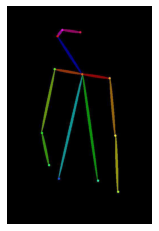

The passed generator was created on 'cpu' even though a tensor on cuda:0 was expected. Tensors will be created on 'cpu' and then moved to cuda:0. Note that one can probably slighly speed up this function by passing a generator that was created on the cuda:0 device.


prompt= a high-quality, white-background image of a man in a white t - shirt and jeans


  0%|          | 0/100 [00:00<?, ?it/s]

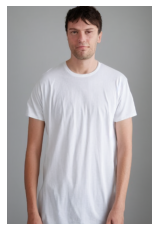

The passed generator was created on 'cpu' even though a tensor on cuda:0 was expected. Tensors will be created on 'cpu' and then moved to cuda:0. Note that one can probably slighly speed up this function by passing a generator that was created on the cuda:0 device.


prompt= a high-quality, white-background image of a man standing in front of a white wall


  0%|          | 0/100 [00:00<?, ?it/s]

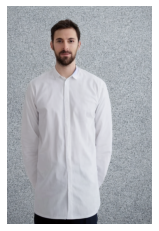

The passed generator was created on 'cpu' even though a tensor on cuda:0 was expected. Tensors will be created on 'cpu' and then moved to cuda:0. Note that one can probably slighly speed up this function by passing a generator that was created on the cuda:0 device.


prompt= a high-quality, white-background image of a woman in a black sweater and jeans and hijab


  0%|          | 0/100 [00:00<?, ?it/s]

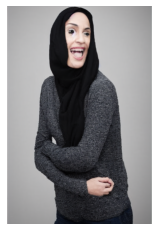

The passed generator was created on 'cpu' even though a tensor on cuda:0 was expected. Tensors will be created on 'cpu' and then moved to cuda:0. Note that one can probably slighly speed up this function by passing a generator that was created on the cuda:0 device.


prompt= a high-quality, white-background image of a woman in a striped shirt and jeans


  0%|          | 0/100 [00:00<?, ?it/s]

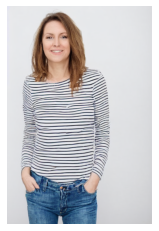

condition image 2


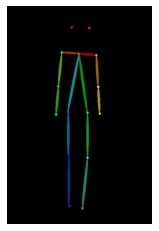

The passed generator was created on 'cpu' even though a tensor on cuda:0 was expected. Tensors will be created on 'cpu' and then moved to cuda:0. Note that one can probably slighly speed up this function by passing a generator that was created on the cuda:0 device.


prompt= a high-quality, white-background image of a man in a white t - shirt and jeans


  0%|          | 0/100 [00:00<?, ?it/s]

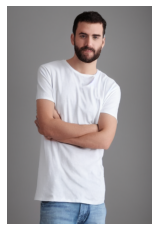

The passed generator was created on 'cpu' even though a tensor on cuda:0 was expected. Tensors will be created on 'cpu' and then moved to cuda:0. Note that one can probably slighly speed up this function by passing a generator that was created on the cuda:0 device.


prompt= a high-quality, white-background image of a man standing in front of a white wall


  0%|          | 0/100 [00:00<?, ?it/s]

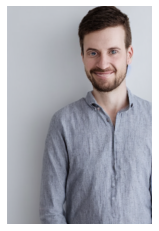

The passed generator was created on 'cpu' even though a tensor on cuda:0 was expected. Tensors will be created on 'cpu' and then moved to cuda:0. Note that one can probably slighly speed up this function by passing a generator that was created on the cuda:0 device.


prompt= a high-quality, white-background image of a woman in a black sweater and jeans and hijab


  0%|          | 0/100 [00:00<?, ?it/s]

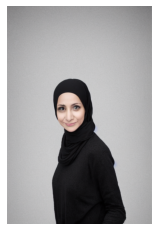

The passed generator was created on 'cpu' even though a tensor on cuda:0 was expected. Tensors will be created on 'cpu' and then moved to cuda:0. Note that one can probably slighly speed up this function by passing a generator that was created on the cuda:0 device.


prompt= a high-quality, white-background image of a woman in a striped shirt and jeans


  0%|          | 0/100 [00:00<?, ?it/s]

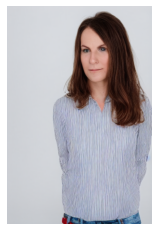

In [39]:


# file_path = os.path.join("controlNetData","test_circle_prompts.json")
file_path = os.path.join("controlNetData","test_pose_prompts.json")
with open(file_path,'r') as f:
    dict_inference = json.load(f)

seed = 3
generator = torch.manual_seed(seed)

for condition in range(2):
    print(f"condition image {condition+1}")
    # control_image = load_image(f"./controlNetData/conditioning_circle_image_{condition+1}.png")
    control_image = load_image(f"./controlNetData/conditioning_pose2_image_{condition+1}.jpg")
    control_image
    plt.imshow(control_image)
    plt.axis('off') 
    plt.show()  
    for key, prompt in dict_inference.items():
        print("prompt=",prompt)
        image = pipe(
        prompt, 
        num_inference_steps=100, 
        generator=generator, 
        image=control_image
        ).images[0]
        plt.imshow(image)
        plt.axis('off') 
        plt.show()  
        # image.save(f"./controlNetData/controlNet-Circle-Output/output-condition{condition+1}-{key}.png")
        image.save(f"./controlNetData/controlNet-Pose2-Output/output-condition{condition+1}-{key}.png")

images_files ['controlNetData/controlNet-Circle-Output/condition1/output-condition1-0.png', 'controlNetData/controlNet-Circle-Output/condition1/output-condition1-1.png', 'controlNetData/controlNet-Circle-Output/condition1/output-condition1-2.png', 'controlNetData/controlNet-Circle-Output/condition1/output-condition1-3.png', 'controlNetData/controlNet-Circle-Output/condition1.png']
Image grid saved to controlNetData/controlNet-Circle-Output


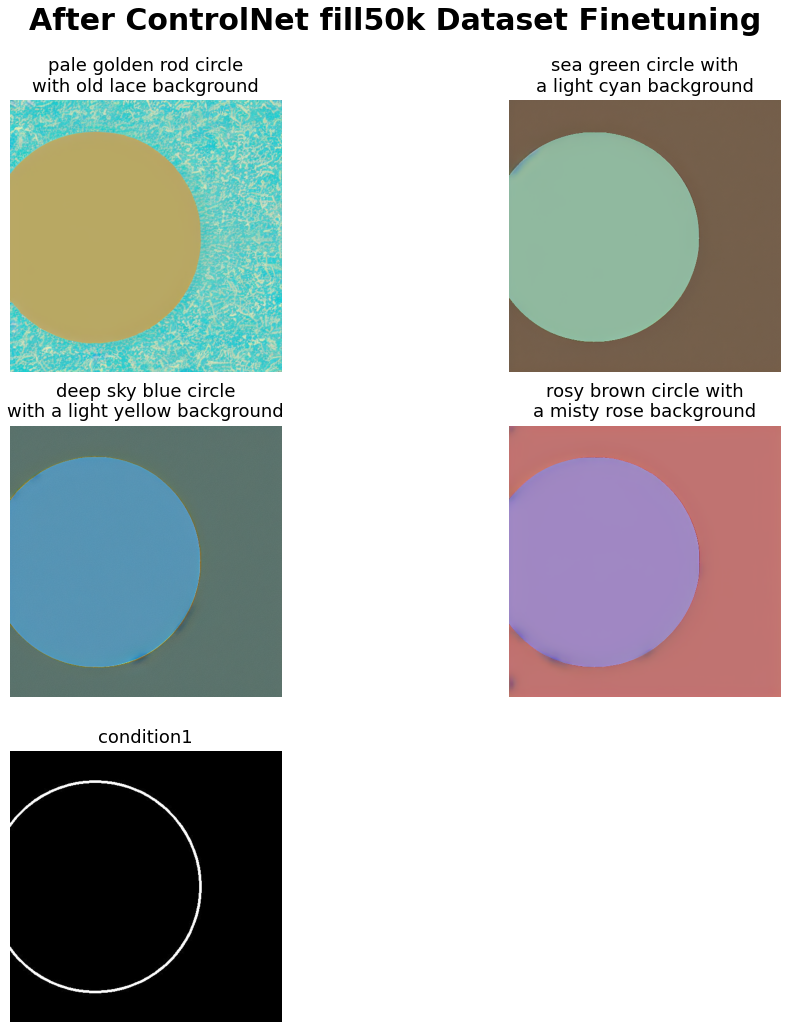

In [29]:
# create 4 images for documentation
# Uses a condition

# result = "controlNet-Pose2-Output"
# picTitle = "After controlnet_pose_merlinyx Finetuning" 
# imageSavingName = "After-pose_merlinyx-ControlNet"
condition = "condition1"
condition = "condition2"
result = "controlNet-Circle-Output"
picTitle = "After ControlNet fill50k Dataset Finetuning" 
imageSavingName = "After-fill50k-ControlNet"

main_dir = "controlNetData/"
branch_dir = f"controlNetData/{result}"
sub_branch_dir = f'{branch_dir}/{condition}'
prompts_file = os.path.join(main_dir, "test_circle_prompts.json")
# prompts_file = os.path.join(main_dir, "test_pose_prompts.json")

# Load prompts from the JSON file
with open(prompts_file, 'r') as f:
    dict_inference = json.load(f)

# Get all image file paths
images_files = [os.path.join(sub_branch_dir, f) 
               for f in os.listdir(sub_branch_dir) 
               if f.endswith(('.png', '.jpg', '.jpeg'))]
images_files.sort()
#circle
final_image_path = os.path.join(branch_dir, f'{condition}.png')
#pose
# final_image_path = os.path.join(branch_dir, f'{condition}.jpg')
images_files.insert(4, final_image_path)

print("images_files",images_files)
# Sort image files for consistency with prompt keys
num_images = len(images_files)
rows = math.ceil(len(images_files) / 2)
cols = 2

# Check if there are images to display
if not images_files:
    print("No images found in the directory.")
else:
    # Display images
    plt.figure(figsize=(15, 15))  # Set figure size for larger images
    plt.suptitle(picTitle, fontsize=30, weight='bold', y=0.95)  # Add main title

    for i, img_path in enumerate(images_files):
        img = Image.open(img_path)

        plt.subplot(rows, cols, i + 1)

        plt.imshow(img)
        plt.axis('off')
        # Set titles for each image
        if i < num_images - 1:
            prompt = dict_inference.get(str(i), "No prompt available")

            # Split the prompt into two lines at halfway point
            halfway = len(prompt) // 2
            split_index = prompt.rfind(' ', 0, halfway)  # Find the closest space before halfway
            if split_index == -1:  # If no space is found, split exactly at halfway
                split_index = halfway
            prompt = prompt[:split_index] + '\n' + prompt[split_index:].strip()
        else:
            prompt = condition  # Title for the final image (condition1)
            
        
        plt.title(prompt, fontsize=18, y=1.01)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    output_path = os.path.join(branch_dir, f"{imageSavingName}-{condition}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Image grid saved to {branch_dir}")

    plt.show()


Image grid saved to controlNetData/


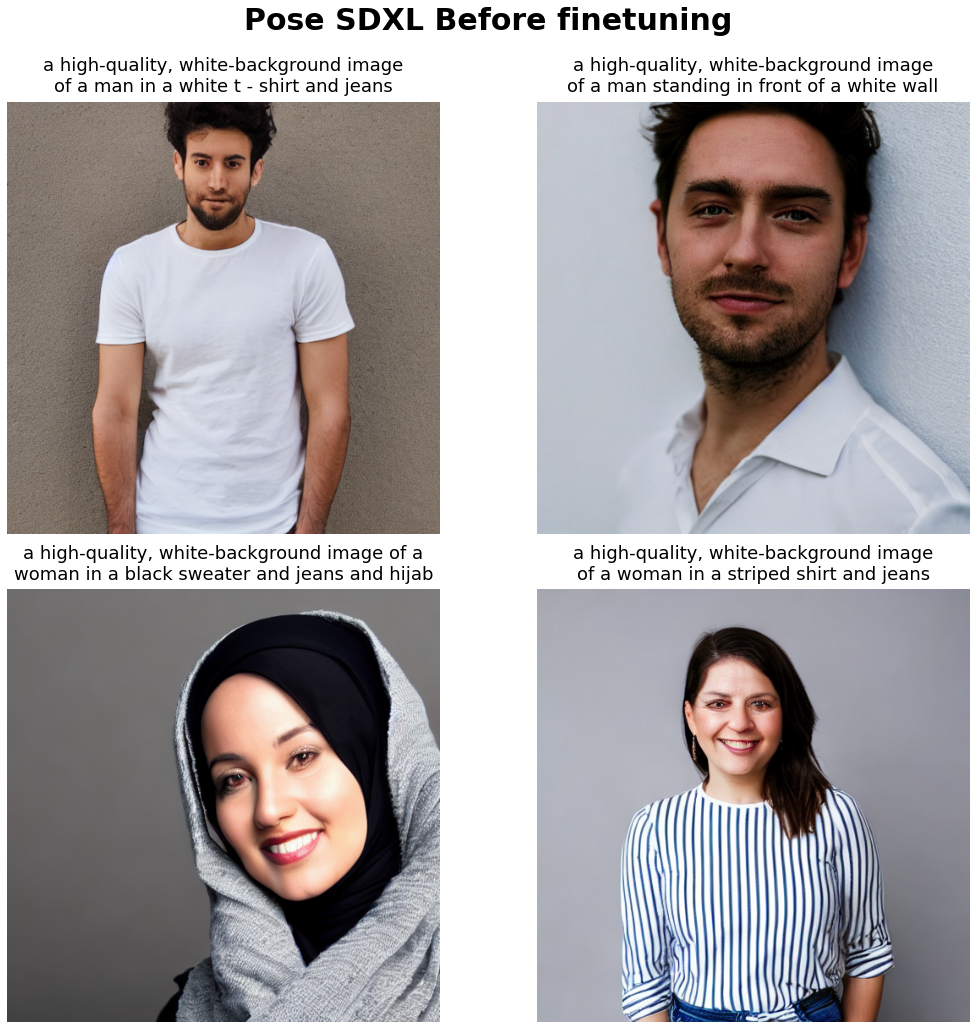

In [18]:
# create 4 images for documentation
# Do NOT use a condition

# result = "SDImages"
result = "SDImages-pose"
picTitle = "Pose SDXL Before finetuning" 
imageSavingName = "Pose-SDXL-Before-Training"

main_dir = "controlNetData/"
branch_dir = f"controlNetData/{result}"
# prompts_file = os.path.join(main_dir, "test_circle_prompts.json")
prompts_file = os.path.join(main_dir, "test_pose_prompts.json")

# Load prompts from the JSON file
with open(prompts_file, 'r') as f:
    dict_inference = json.load(f)

# Get all image file paths
image_files = [os.path.join(branch_dir, f) for f in os.listdir(branch_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Sort image files for consistency with prompt keys
image_files.sort()

# Check if there are images to display
if not image_files:
    print("No images found in the directory.")
else:
    # Display images
    plt.figure(figsize=(15, 15))  # Set figure size for larger images
    plt.suptitle(picTitle, fontsize=30, weight='bold', y=0.95)  # Add main title

    for i, img_path in enumerate(image_files):
        img = Image.open(img_path)
        plt.subplot(math.ceil(len(image_files) // 2), 2, i + 1)
        plt.imshow(img)
        plt.axis('off')
        # Add a prompt for each image
        prompt = dict_inference.get(str(i), "No prompt available")
        # Split the prompt into two lines at halfway point
        halfway = len(prompt) // 2
        split_index = prompt.rfind(' ', 0, halfway)  # Find the closest space before halfway
        if split_index == -1:  # If no space is found, split exactly at halfway
            split_index = halfway
        prompt = prompt[:split_index] + '\n' + prompt[split_index:].strip()

        plt.title(prompt, fontsize=18, y=1.01)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    output_path = os.path.join(main_dir, f"{imageSavingName}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Image grid saved to {main_dir}")

    plt.show()
